# Modelado

## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

Cargo las librerías a usar y  realizo configuraciones generales.

In [27]:
# Instalación de dependencias
# !pip install optuna catboost lightgbm xgboost shap imbalanced-learn --quiet

In [28]:
# Bibliotecas estándar
import numpy as np
import pandas as pd
import os
import json
import pickle
import joblib
import warnings
import time
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: modelos y métricas
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    learning_curve,
    GridSearchCV,
    validation_curve
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    confusion_matrix,
    classification_report,
    make_scorer
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight

# Modelos de Gradient Boosting
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Optimización de hiperparámetros
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Google Colab (descomentar si se usa en Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
# Realizo configuraciones globales
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

Creo una función para mostrar logs

In [30]:
def log(mensaje):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensaje}")

Defino variables globales.

In [31]:
# Configuro la semilla para reproducibilidad, requisito fundamental según TRIPOD-AI (ítem 14) [TRIPOD] y el AI Act [AI Act] para sistemas de alto riesgo
RANDOM_STATE = 1976

# Defino las rutas a los ficheros
# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\Procesado\\' # Local
# DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/Procesado/' # Google Drive

# Configuro las rutas para guardar modelos y resultados
MODELS_PATH = os.path.join(DRIVE_PATH, 'modelos')
RESULTS_PATH = os.path.join(DRIVE_PATH, 'resultados')
FIGURES_PATH = os.path.join(DRIVE_PATH, 'figuras')

for path in [MODELS_PATH, RESULTS_PATH, FIGURES_PATH]:
    os.makedirs(path, exist_ok=True)

# Defino los ficheros de características
X_TRAIN_FILE = os.path.join(DRIVE_PATH, 'X_train_selected.csv')
X_VAL_FILE = os.path.join(DRIVE_PATH, 'X_val_selected.csv')
X_CAL_FILE = os.path.join(DRIVE_PATH, 'X_cal_selected.csv')
X_TEST_FILE = os.path.join(DRIVE_PATH, 'X_test_selected.csv')

# Defino los ficheros de la variable objetivo
Y_TRAIN_FILE = os.path.join(DRIVE_PATH, 'y_train.csv')
Y_VAL_FILE = os.path.join(DRIVE_PATH, 'y_val.csv')
Y_CAL_FILE = os.path.join(DRIVE_PATH, 'y_cal.csv')
Y_TEST_FILE = os.path.join(DRIVE_PATH, 'y_test.csv')

# Defino el archivo de mapeo de encoders
ENCODERS_FILE = os.path.join(DRIVE_PATH, 'encoders_mapping.json')

# Defino los archivos de salida
CONFIG_FILE = os.path.join(RESULTS_PATH, 'experiment_config.json')
METRICS_FILE = os.path.join(RESULTS_PATH, 'model_metrics.csv')
CLASS_WEIGHTS_FILE = os.path.join(RESULTS_PATH, 'class_weights.json')

Carga de ficheros



In [32]:
# Función de carga de fichero csv
# Cargo el fichero
def load_csv(filePath, squeeze=False):
  try:
      if squeeze:
          data = pd.read_csv(filePath, low_memory=False).squeeze()
          print(f"Fichero {filePath} cargado con éxito. Elementos: {data.size}")
      else:
          data = pd.read_csv(filePath, low_memory=False)
          print(f"Fichero {filePath} cargado con éxito. Forma: {data.shape}")

      return data
  except FileNotFoundError:
      print(f"ERROR: No se encontró el fichero en {filePath}")
  except Exception as e:
      print(f"ERROR: Se produjo un error al cargar el fichero: {e}")

Grabación de ficheros

In [33]:
# Almaceno un df en formato csv en disco
def save_csv(filePath, df, saveIndex=False):
  try:
    df.to_csv(
        filePath,
        index=saveIndex,
        sep=',',
        encoding='utf-8',
        header=True
    )
    print(f"Fichero en {filePath} almacenado.")
  except Exception as e:
    print(f"ERROR: Se produjo un error al grabar el fichero: {e}")

Configuración común de gráficos

In [34]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

Defino las variables categóricas del dataset y las clases del problema de clasificación.

In [35]:
# Cargo los nombres de las clases desde el fichero de mapeo de encoders
with open(ENCODERS_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)
CLASS_NAMES = data["cardiopatia"]
CLASS_NAMES = {int(k): v
               for k, v in CLASS_NAMES.items()
               if v != "No se puede determinar"
               } # Filtro la clase "No se puede determinar" pues se eliminó en la fase de preprocesado
N_CLASSES = 4

# Defino las variables categóricas, aunque sean codificadas como números
CATEGORICAL_FEATURES = ['sex_encoded', 'race_ethnicity_encoded']

## Configuración previa para el modelado

### Carga de los ficheros
Cargo los datasets preparados en la fase anterior de EDA y preparación de datos.

In [36]:
# Cargo las características
X_train = load_csv(X_TRAIN_FILE)
X_val = load_csv(X_VAL_FILE)
X_cal = load_csv(X_CAL_FILE)
X_test = load_csv(X_TEST_FILE)

# Cargo las variables objetivo targets
y_train = load_csv(Y_TRAIN_FILE, squeeze=True)
y_val = load_csv(Y_VAL_FILE, squeeze=True)
y_cal = load_csv(Y_CAL_FILE, squeeze=True)
y_test = load_csv(Y_TEST_FILE, squeeze=True)

# Obtengo los nombres de las características
FEATURE_NAMES = X_train.columns.tolist()

Fichero D:\Desarrollo\TFG\Procesado\X_train_selected.csv cargado con éxito. Forma: (65878, 48)
Fichero D:\Desarrollo\TFG\Procesado\X_val_selected.csv cargado con éxito. Forma: (2053, 48)
Fichero D:\Desarrollo\TFG\Procesado\X_cal_selected.csv cargado con éxito. Forma: (2053, 48)
Fichero D:\Desarrollo\TFG\Procesado\X_test_selected.csv cargado con éxito. Forma: (4815, 48)
Fichero D:\Desarrollo\TFG\Procesado\y_train.csv cargado con éxito. Elementos: 65878
Fichero D:\Desarrollo\TFG\Procesado\y_val.csv cargado con éxito. Elementos: 2053
Fichero D:\Desarrollo\TFG\Procesado\y_cal.csv cargado con éxito. Elementos: 2053
Fichero D:\Desarrollo\TFG\Procesado\y_test.csv cargado con éxito. Elementos: 4815


### Análisis del desbalance de clases

Se analiza la distribución de clases para confirmar el desbalance y calcular los pesos apropiados.

**Contexto clínico:**
El desbalance de clases es común en datasets médicos [1].

En el caso de este estudio, la clase minoritaria detectada en el EDA (Estenosis, 1.80%) representa una patología que, aunque menos frecuente, tiene importantes implicaciones clínicas y no debe ser ignorada por el modelo.

Distribución de clases - Entrenamiento (TRAIN)
 Class_Cod    Class_Name  Frequency  Percentage
         0         Ambas       8538   12.960321
         1     Estenosis       1185    1.798780
         2 Insuficiencia      43006   65.281278
         3       Ninguna      13149   19.959622
Ratio máximo/mínimo: 36.29:1
Distribución de clases - Validación (VAL)
 Class_Cod    Class_Name  Frequency  Percentage
         0         Ambas        324   15.781783
         1     Estenosis         54    2.630297
         2 Insuficiencia       1219   59.376522
         3       Ninguna        456   22.211398
Ratio máximo/mínimo: 22.57:1
Distribución de clases - Calibración (CAL)
 Class_Cod    Class_Name  Frequency  Percentage
         0         Ambas        324   15.781783
         1     Estenosis         54    2.630297
         2 Insuficiencia       1219   59.376522
         3       Ninguna        456   22.211398
Ratio máximo/mínimo: 22.57:1
Distribución de clases - Test (TEST)
 Class_Cod    Class_Name

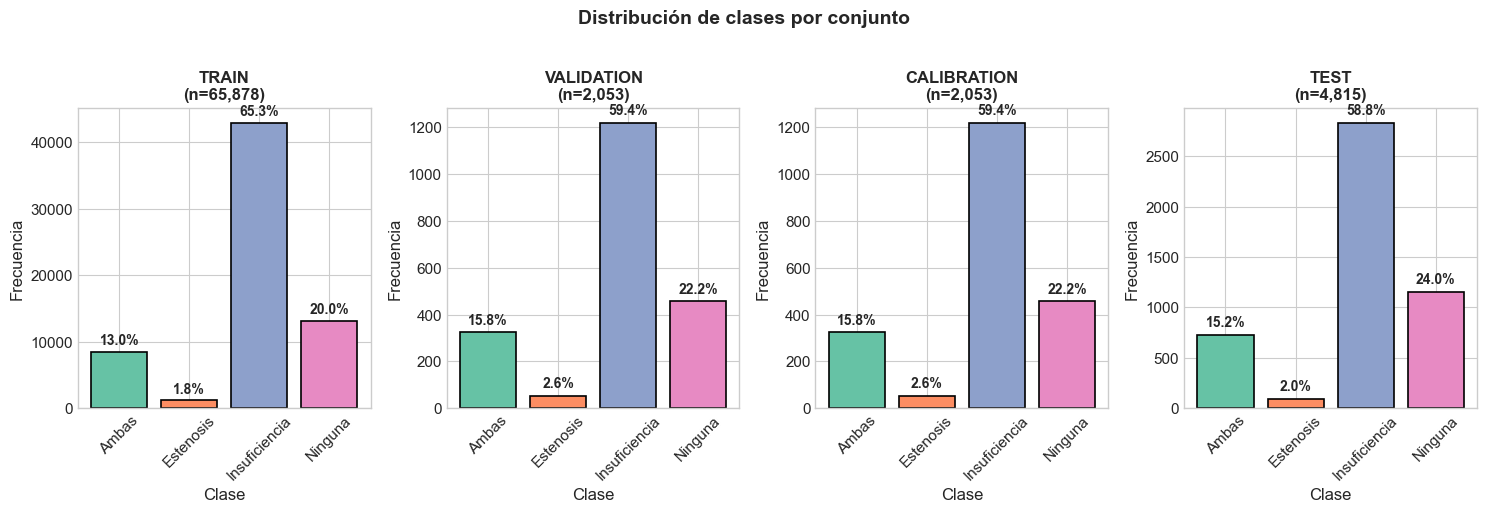

In [37]:
# Creo una función para analizar la distribución de clases
def classes_distribution(y: pd.Series, name: str = "Dataset") -> pd.DataFrame:
    # Calculo la distribución
    distribution = y.value_counts().sort_index()
    percentage = (y.value_counts(normalize=True) * 100).sort_index()

    # Creo un dataFrame de  resumen
    df_dist = pd.DataFrame({
        'Class_Cod': distribution.index,
        'Class_Name': [CLASS_NAMES.get(i, f'Clase_{i}') for i in distribution.index],
        'Frequency': distribution.values,
        'Percentage': percentage.values
    })

    print(f"Distribución de clases - {name}")
    print(df_dist.to_string(index=False))

    # Calculo el ratio de desbalance
    ratio_max_min = distribution.max() / distribution.min()
    print(f"Ratio máximo/mínimo: {ratio_max_min:.2f}:1")

    return df_dist

# Analizo la distribución en cada conjunto
dist_train = classes_distribution(y_train, "Entrenamiento (TRAIN)")
dist_val = classes_distribution(y_val, "Validación (VAL)")
dist_cal = classes_distribution(y_val, "Calibración (CAL)")
dist_test = classes_distribution(y_test, "Test (TEST)")

# Visualizo el desbalance
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

datasets = [
    (y_train, 'TRAIN', axes[0]),
    (y_val, 'VALIDATION', axes[1]),
    (y_cal, 'CALIBRATION', axes[2]),
    (y_test, 'TEST', axes[3])
]

colors = plt.cm.Set2(range(N_CLASSES))

for y_data, title, ax in datasets:
    counts = y_data.value_counts().sort_index()
    bars = ax.bar(
        [CLASS_NAMES[i] for i in counts.index],
        counts.values,
        color=colors,
        edgecolor='black',
        linewidth=1.2
    )

    # Añado las etiquetas en las barras
    for bar, count in zip(bars, counts.values):
        pct = count / len(y_data) * 100
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + len(y_data)*0.01,
            f'{pct:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    ax.set_title(f'{title}\n(n={len(y_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Distribución de clases por conjunto', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

### Cálculo de pesos de clase

Se calculan los pesos de clase para compensar el desbalance durante el entrenamiento.

Este enfoque evita que el modelo ignore las clases minoritarias (especialmente Estenosis), lo cual sería problemático en el un contexto del presente trabajo. [2]

**Metodología:**
Se utiliza el método `balanced` de scikit-learn que calcula los pesos de forma inversamente proporcional a la frecuencia de cada clase [3]:

$$w_j = \frac{n_{samples}}{n_{classes} \times n_{samples_j}}$$
[4]

Donde:
- $w_j$ = peso de la clase j
- $n_{samples}$ = número total de muestras
- $n_{classes}$ = número de clases
- $n_{samples_j}$ = número de muestras de la clase j

In [38]:
# Calculo los pesos de clase para el conjunto de entrenamiento
# Función para calcular los pesos de clase
def weight_by_class(y: pd.Series) -> Dict[int, float]:
    classes = np.unique(y)

    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )

    return dict(zip(classes.astype(int), weights))

# Calculo los pesos de clase
CLASS_WEIGHTS = weight_by_class(y_train)

for clas, weight in CLASS_WEIGHTS.items():
    name = CLASS_NAMES.get(clas, f'Clase_{clas}')
    freq = (y_train == clas).sum() / len(y_train) * 100
    print(f"{name:15s} (Clase {clas}): peso = {weight:.4f} | freq = {freq:.2f}%")

# Guardo los pesos para usarlos como referencia
with open(CLASS_WEIGHTS_FILE, 'w') as f:
    json.dump({
        'class_weights': {str(k): float(v) for k, v in CLASS_WEIGHTS.items()},
        'class_names': {str(k): v for k, v in CLASS_NAMES.items()},
        'method': 'balanced'
    }, f, indent=2)

Ambas           (Clase 0): peso = 1.9290 | freq = 12.96%
Estenosis       (Clase 1): peso = 13.8983 | freq = 1.80%
Insuficiencia   (Clase 2): peso = 0.3830 | freq = 65.28%
Ninguna         (Clase 3): peso = 1.2525 | freq = 19.96%


### Definición de métricas de evaluación

Se definen las métricas de evaluación de los modelos considerando el contexto clínico del problema.

**Selección de métricas (TRIPOD-AI ítem 10a):**

| Métrica | Justificación Clínica |
|---------|----------------------|
| **Macro F1-Score** | Rendimiento equilibrado en todas las clases, crítico para clases minoritarias [4] |
| **Sensibilidad (Recall)** | Capacidad de detectar cada patología - minimiza falsos negativos [5] |
| **Especificidad** | Evita diagnósticos innecesarios - minimiza falsos positivos |
| **AUC-ROC** | Capacidad discriminativa independiente del umbral [6] |
| **Log-Loss** | Calidad de las probabilidades predichas - esencial para UQ posterior [7] |
| **Brier Score** | Error cuadrático de probabilidades - calibración [8] |
| **Balanced Accuracy** | Promedio de sensibilidades - robusto a desbalance [9] |

In [39]:
# Calculo métricas completas de clasificación multiclase
# Función para calcular métricas completas de clasificación multiclase
def calculate_all_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray
) -> Dict[str, Any]:
    class_names = CLASS_NAMES

    n_classes = len(class_names)
    classes = list(range(n_classes))

    # Binarizo para las métricas OvR (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=classes)

    # Métricas globales
    metrics = {
        # Accuracy
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),

        # F1-Score
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),

        # Precision y Recall (macro)
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),

        # Métricas probabilísticas
        'log_loss': log_loss(y_true, y_prob),
    }

    # AUC-ROC (macro y por clase)
    try:
        metrics['auc_roc_macro'] = roc_auc_score(
            y_true_bin, y_prob, average='macro', multi_class='ovr'
        )
        metrics['auc_roc_weighted'] = roc_auc_score(
            y_true_bin, y_prob, average='weighted', multi_class='ovr'
        )
    except ValueError:
        metrics['auc_roc_macro'] = np.nan
        metrics['auc_roc_weighted'] = np.nan

    # Brier Score (promedio multiclase)
    brier_scores = []
    for i in range(n_classes):
        brier_scores.append(brier_score_loss(y_true_bin[:, i], y_prob[:, i]))
    metrics['brier_score_macro'] = np.mean(brier_scores)

    # Métricas por clase
    metrics['by_class'] = {}

    # Calculo las métricas individuales por clase
    precision_by_class = precision_score(y_true, y_pred, average=None, labels=classes)
    recall_by_class = recall_score(y_true, y_pred, average=None, labels=classes)
    f1_by_class = f1_score(y_true, y_pred, average=None, labels=classes)

    for i, clas in enumerate(classes):
        name = class_names.get(clas, f'Class_{clas}')
        metrics['by_class'][name] = {
            'precision': precision_by_class[i],
            'recall': recall_by_class[i],
            'f1': f1_by_class[i],
            'brier_score': brier_scores[i],
            'support': int(np.sum(y_true == clas))
        }

        # AUC-ROC por clase
        try:
            metrics['by_class'][name]['auc_roc'] = roc_auc_score(
                y_true_bin[:, i], y_prob[:, i]
            )
        except ValueError:
            metrics['by_class'][name]['auc_roc'] = np.nan

        # AUC-PR por clase (más informativo para clases minoritarias)
        try:
            metrics['by_class'][name]['auc_pr'] = average_precision_score(
                y_true_bin[:, i], y_prob[:, i]
            )
        except ValueError:
            metrics['by_class'][name]['auc_pr'] = np.nan

    # Matriz de confusión
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred, labels=classes)

    return metrics

In [40]:
# Función para mostrar las métricas formateadas
def show_metrics(metrics, title) -> None:
    print(f"{title}")
    # Métricas globales
    print(f"Métricas globales:")
    print(f"{'Accuracy:':<25} {metrics['accuracy']:.4f}")
    print(f"{'Balanced Accuracy:':<25} {metrics['balanced_accuracy']:.4f}")
    print(f"{'Macro F1-Score:':<25} {metrics['f1_macro']:.4f}")
    print(f"{'Weighted F1-Score:':<25} {metrics['f1_weighted']:.4f}")
    print(f"{'AUC-ROC (macro):':<25} {metrics['auc_roc_macro']:.4f}")
    print(f"{'Log-Loss:':<25} {metrics['log_loss']:.4f}")
    print(f"{'Brier Score (macro):':<25} {metrics['brier_score_macro']:.4f}")

    # Métricas por clase
    print(f"Métricas por clase:")
    print(f"{'Clase':<15} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC-ROC':>10} {'AUC-PR':>10} {'Support':>10}")

    for clase, m in metrics['by_class'].items():
        print(f"{clase:<15} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} "
              f"{m['auc_roc']:>10.4f} {m['auc_pr']:>10.4f} {m['support']:>10d}")

In [41]:
# Función para mostrar las matrices de confusión
def plot_confusion_matrix_comparison(cm_train, cm_val, class_names, model_title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalizo
    cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]

    # TRAIN
    sns.heatmap(cm_train_norm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Valor Real')
    axes[0].set_title(f'TRAIN - {model_title}', fontweight='bold')

    # VALIDATION
    sns.heatmap(cm_val_norm, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Valor Real')
    axes[1].set_title(f'VALIDATION - {model_title}', fontweight='bold')

    plt.suptitle(f'Comparación de Matrices de Confusión - {model_title}', fontsize=14, fontweight='bold')
    plt.tight_layout()

    plt.show()
    plt.close()

### Valores de referencia para interpretación del rendimiento

Se definen valores de referencia orientativos para contextualizar el rendimiento de los modelos.

**NOTA IMPORTANTE:**

Estos valores **NO son umbrales validados clínicamente** ni criterios de descarte. Son referencias orientativas basadas en:
1. El propósito del sistema como **soporte a la decisión clínica** (no diagnóstico autónomo)
2. Prácticas generales en machine learning para clasificación médica
3. Consideraciones sobre el desbalance de clases presente en el dataset

**Limitaciones:**
- Los valores de rendimiento aceptables deben ser definidos por especialistas clínicos antes de cualquier uso real
- El AI Act (2024/1689) exige rendimiento "adecuado" pero no especifica umbrales concretos [AI Act]
- La validación clínica formal está fuera del alcance de este TFG

Los valores se presentan como **contexto para el análisis**, no como criterios de aceptación/rechazo.

In [42]:
# Defino valores de referencia para su interpretación
REFERENCE_VALUES = {
    'description': '''
    Valores orientativos para contextualizar el rendimiento de los modelos.
    NO son umbrales validados clínicamente ni criterios de descarte.
    Deben ser definidos por especialistas antes de cualquier uso real.
    ''',

    # Contexto: Sistema de soporte a la decisión (no diagnóstico autónomo)
    'context': 'soporte_decision_clinica',

    # Rangos orientativos de la sensibilidad por clase
    # Basados en el desbalance y la importancia relativa de cada patología
    'guideline_sensitivity': {
        'Ambas': {
            'value': 0.75,
            'note': 'Patología combinada que requiere una buena detección'
        },
        'Estenosis': {
            'value': 0.70,
            'note': 'Clase muy minoritaria (1.8%) por lo que es esperable una menor sensibilidad'
        },
        'Insuficiencia': {
            'value': 0.80,
            'note': 'Clase mayoritaria (65%) lo que predispone una mayor facilidad de detección'
        },
        'Ninguna': {
            'value': 0.70,
            'note': 'Detectar la ausencia de patología para evitar el sobrediagnóstico'
        }
    },

    # Rangos para interpretar las métricas globales
    'global_metrics': {
        'f1_macro': {
            'low': 0.50,
            'moderate': 0.65,
            'good': 0.75,
            'note': 'Se ve afectado por el desbalance severo de las clases'
        },
        'auc_roc_macro': {
            'low': 0.70,
            'moderate': 0.80,
            'good': 0.90,
            'note': 'Capacidad discriminativa global'
        },
        'log_loss': {
            'low': 0.50,
            'moderate': 0.80,
            'good': 1.20,
            'note': 'Calidad de probabilidades. Es esencial para UQ'
        }
    },

    # Indicadores de generalización (overfitting)
    'gap_train_val': {
        'good': 0.05,
        'moderate': 0.10,
        'alarm': 0.15,
        'note': 'Diferencia entre métricas de TRAIN y VALIDATION'
    }
}

print(f"Contexto de uso: Sistema de SOPORTE a la decisión clínica")
print(f"Valores orientativos de sensibilidad por clase:")
for clas, info in REFERENCE_VALUES['guideline_sensitivity'].items():
    print(f"{clas}: ~{info['value']:.0%} ({info['note']})")

Contexto de uso: Sistema de SOPORTE a la decisión clínica
Valores orientativos de sensibilidad por clase:
Ambas: ~75% (Patología combinada que requiere una buena detección)
Estenosis: ~70% (Clase muy minoritaria (1.8%) por lo que es esperable una menor sensibilidad)
Insuficiencia: ~80% (Clase mayoritaria (65%) lo que predispone una mayor facilidad de detección)
Ninguna: ~70% (Detectar la ausencia de patología para evitar el sobrediagnóstico)


In [43]:
# Función para analizar el rendimiento del modelo
# Pretendo proporcionar un análisis descriptivo sin juicios de cumple/no cumple.
def analyze_performance(metrics: Dict[str, Any], metrics_train: Dict[str, Any] = None) -> Dict[str, Any]:
    analysis = {
        'global_metrics': {},
        'class_sensitivity': {},
        'observations': []
    }

    # Análisis de métricas globales
    refs = REFERENCE_VALUES['global_metrics']

    f1 = metrics['f1_macro']
    if f1 >= refs['f1_macro']['good']:
        nivel_f1 = 'good'
    elif f1 >= refs['f1_macro']['moderate']:
        nivel_f1 = 'moderate'
    else:
        nivel_f1 = 'low'

    analysis['global_metrics']['f1_macro'] = {
        'valor': f1,
        'nivel': nivel_f1,
        'referencia': refs['f1_macro']
    }

    auc = metrics['auc_roc_macro']
    if auc >= refs['auc_roc_macro']['bueno']:
        nivel_auc = 'bueno'
    elif auc >= refs['auc_roc_macro']['moderado']:
        nivel_auc = 'moderado'
    else:
        nivel_auc = 'bajo'

    analysis['global_metrics']['auc_roc_macro'] = {
        'valor': auc,
        'nivel': nivel_auc,
        'referencia': refs['auc_roc_macro']
    }

    ll = metrics['log_loss']
    if ll <= refs['log_loss']['bueno']:
        nivel_ll = 'bueno'
    elif ll <= refs['log_loss']['moderado']:
        nivel_ll = 'moderado'
    else:
        nivel_ll = 'alto'

    analysis['global_metrics']['log_loss'] = {
        'value': ll,
        'level': nivel_ll,
        'reference': refs['log_loss']
    }

    # Análisis de sensibilidad por clase
    refs_sens = REFERENCE_VALUES['guideline_sensitivity']
    for clas, info in refs_sens.items():
        if clas in metrics['by_class']:
            recall = metrics['by_class'][clas]['recall']
            ref_value = info['value']
            difference = recall - ref_value

            analysis['sensitivity_by_class'][clas] = {
                'value': recall,
                'reference': ref_value,
                'difference': difference,
                'note': info['note']
            }

            # Añado observaciones relevantes
            if difference < -0.15:
                analysis['observations'].append(
                    f"Sensibilidad en {clas} ({recall:.1%}) notablemente inferior al valor orientativo ({ref_value:.0%})"
                )

    # Análisis de generalización (gap)
    if metrics_train is not None:
        gap_f1 = metrics_train['f1_macro'] - metrics['f1_macro']
        refs_gap = REFERENCE_VALUES['gap_train_val']

        if gap_f1 <= refs_gap['good']:
            gap_level = 'good'
        elif gap_f1 <= refs_gap['moderate']:
            gap_level = 'moderate'
        else:
            gap_level = 'alarm'

        analysis['generalization'] = {
            'gap_f1': gap_f1,
            'level': gap_level,
            'reference': refs_gap
        }

        if gap_f1 > refs_gap['moderate']:
            analysis['observations'].append(
                f"Gap TRAIN-VAL ({gap_f1:.1%}) sugiere posible overfitting"
            )

    return analysis

# Función para mostrar el análisis de rendimiento
def show_analyze_performance(analysis: Dict[str, Any]) -> None:

    print(f"ANÁLISIS DE RENDIMIENTO (Comparación con valores de referencia)")
    print(f"Los valores de referencia son orientativos, NO umbrales validados")

    # Métricas globales
    print(f"MÉTRICAS GLOBALES:")
    for name, info in analysis['global_metrics'].items():
        print(f"{name}: {info['value']:.4f} (nivel: {info['level']})")

    # Sensibilidad por clase
    print(f"SENSIBILIDAD POR CLASE:")
    print(f"{'Clase':<15} {'Valor':>10} {'Ref.':>10} {'Dif.':>10}")
    for clase, info in analysis['sensitivity_by_class'].items():
        dif_str = f"{info['difference']:+.1%}"
        print(f"{clase:<15} {info['value']:>10.1%} {info['reference']:>10.0%} {dif_str:>10}")

    # Generalización
    if 'generalization' in analysis:
        print(f"GENERALIZACIÓN:")
        gen = analysis['generalization']
        print(f"Gap TRAIN-VAL (F1): {gen['gap_f1']:.1%} (nivel: {gen['level']})")

    # Observaciones
    if analysis['observations']:
        print(f"OBSERVACIONES:")
        for obs in analysis['observations']:
            print(f"* {obs}")

### Configuración del pipeline de validación cruzada

Se configura Stratified K-Fold Cross-Validation para mantener la proporción de clases en cada fold.

La validación cruzada estratificada es esencial en problemas con clases desbalanceadas para garantizar que cada fold tenga una representación similar de todas las clases [10]. Esto proporciona estimaciones más consistentes del rendimiento del modelo.

In [44]:
# Defino el número de folds
N_SPLITS = 5

# Configuro Stratified K-Fold
cv_strategy = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

# Función para evaluar un modelo con validación cruzada
def evaluate_crossvalidation(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    cv=None,
    model_name: str = "Modelo"
) -> Dict[str, Any]:
    # Evalúo un modelo usando validación cruzada estratificada.

    if cv is None:
        cv = cv_strategy

    log(f"Evaluando {model_name} con {N_SPLITS}-Fold CV...")

    # Scorers personalizados
    scoring = {
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'f1_macro': make_scorer(f1_score, average='macro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'roc_auc_ovr': make_scorer(
            roc_auc_score,
            needs_proba=True,
            multi_class='ovr',
            average='macro'
        ),
        'neg_log_loss': 'neg_log_loss'
    }

    # Ejecuto CV
    cv_results = cross_validate(
        model,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Proceso los resultados
    results = {
        'name': model_name,
        'n_folds': N_SPLITS
    }

    for metric in scoring.keys():
        train_key = f'train_{metric}'
        test_key = f'test_{metric}'

        # Converto neg_log_loss a positivo
        if 'neg_log_loss' in metric:
            train_scores = -cv_results[train_key]
            test_scores = -cv_results[test_key]
            metric_name = 'log_loss'
        else:
            train_scores = cv_results[train_key]
            test_scores = cv_results[test_key]
            metric_name = metric

        results[f'{metric_name}_train_mean'] = np.mean(train_scores)
        results[f'{metric_name}_train_std'] = np.std(train_scores)
        results[f'{metric_name}_val_mean'] = np.mean(test_scores)
        results[f'{metric_name}_val_std'] = np.std(test_scores)
        results[f'{metric_name}_gap'] = np.mean(train_scores) - np.mean(test_scores)

    # Tiempo de ajuste
    results['fit_time_mean'] = np.mean(cv_results['fit_time'])
    results['fit_time_std'] = np.std(cv_results['fit_time'])

    return results

# Función para mostrar los resultados de validación cruzada
def show_crossvalidation_results(results: Dict[str, Any]) -> None:
    # Muestro los resultados de validación cruzada de forma formateada.
    print(f"Resultados CV: {results['name']} ({results['n_folds']}-Fold)")

    metrics = ['accuracy', 'balanced_accuracy', 'f1_macro', 'roc_auc_ovr', 'log_loss']

    print(f"{'Métrica':<20} {'TRAIN':>15} {'VAL':>15} {'GAP':>10}")

    for m in metrics:
        train = results.get(f'{m}_train_mean', np.nan)
        train_std = results.get(f'{m}_train_std', 0)
        val = results.get(f'{m}_val_mean', np.nan)
        val_std = results.get(f'{m}_val_std', 0)
        gap = results.get(f'{m}_gap', np.nan)

        print(f"{m:<20} {train:.4f}+-{train_std:.4f}  {val:.4f}+-{val_std:.4f}  {gap:>+.4f}")

    print(f"Tiempo de ajuste: {results['fit_time_mean']:.2f}+-{results['fit_time_std']:.2f} seg")

### Función general para entrenar modelos

In [45]:
# Función para entrenar y envaluar modelos
def train_evaluate_model(model, name, X_tr, y_tr, X_vl, y_vl, sample_weight=None):
    results = {
        'name': name,
        'model': None,
        'metrics_train': None,
        'metrics_val': None,
        'y_pred_val': None,
        'y_proba_val': None,
        'train_time': 0
    }

    log(f"Entrenando modelo {name}.")

    start_time = time.time()

    cv_results = evaluate_crossvalidation(
        model=model,
        X=X_tr,
        y=y_tr,
        model_name=name
    )
    results['cv_results'] = cv_results
    log(f"Ejecutada validación cruzada para {name}.")

    if sample_weight is not None:
        try:
            model.fit(X_tr, y_tr, sample_weight=sample_weight)
        except:
            model.fit(X_tr, y_tr)
    else:
        model.fit(X_tr, y_tr)

    # Predicciones
    y_pred_tr = model.predict(X_tr)
    y_proba_tr = model.predict_proba(X_tr)
    y_pred_vl = model.predict(X_vl)
    y_proba_vl = model.predict_proba(X_vl)

    # Métricas
    metricas_tr = calculate_all_metrics(y_tr.values, y_pred_tr, y_proba_tr)
    metricas_vl = calculate_all_metrics(y_vl.values, y_pred_vl, y_proba_vl)

    train_time = time.time() - start_time

    log(f"Modelo {name} entrenado en {train_time:.2f}s.")

    results.update({
        'model': model,
        'metrics_train': metricas_tr,
        'metrics_val': metricas_vl,
        'train_time': train_time,
        'y_pred_val': y_pred_vl,
        'y_proba_val': y_proba_vl
    })

    return results

### Funciones para guardar y cargar modelos

La persistencia de modelos es esencial para la reproducibilidad (TRIPOD-AI ítem 14).

In [46]:
# Funciones para guardar y cargar modelos
def save_model(model, name, metrics=None, params=None, path=None):
    # Guardo un modelo junto con sus metadatos.
    if path is None:
        path = MODELS_PATH

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_file = os.path.join(path, f"{name}_{timestamp}.joblib")
    meta_file = os.path.join(path, f"{name}_{timestamp}_meta.json")

    joblib.dump(model, model_file)

    # Convirto los datos en objecto válidos de JSON
    def to_serializable(obj):
        # Diccionarios: converto keys y values
        if isinstance(obj, dict):
            new_dict = {}
            for k, v in obj.items():
                if isinstance(k, (np.integer, np.int64, np.int32)):
                    k = str(int(k))
                elif isinstance(k, (np.floating, np.float64, np.float32)):
                    k = str(float(k))
                else:
                    k = str(k)
                new_dict[k] = to_serializable(v)
            return new_dict

        # Listas: converto los contents
        if isinstance(obj, list):
            return [to_serializable(i) for i in obj]

        # numpy arrays
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        # numpy scalars
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            return float(obj)
        if isinstance(obj, (np.bool_)):
            return bool(obj)

        # Si no...
        return obj

    metadata = to_serializable({
        'name': name, 'timestamp': timestamp,
        'model_type': type(model).__name__,
        'parameters': params, 'metrics': metrics,
        'random_state': RANDOM_STATE
    })

    with open(meta_file, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)

    log(f"Modelo guardado: {name}")
    return model_file

# Función para cargar un modelo guardado
def load_model(name, path=None):
    # Cargo un modelo guardado junto con sus metadatos.
    if path is None:
        path = MODELS_PATH
    files = [f for f in os.listdir(path) if f.startswith(name) and f.endswith('.joblib')]
    if not files:
        raise FileNotFoundError(f"No se encontró modelo: {name}")
    files.sort(reverse=True)
    model_file = os.path.join(path, files[0])
    meta_file = model_file.replace('.joblib', '_meta.json')

    model = joblib.load(model_file)
    metadata = {}
    if os.path.exists(meta_file):
        with open(meta_file, 'r') as f:
            metadata = json.load(f)
    return model, metadata

# Función para verificar si un modelo existe
def model_exists(name, path=None):
    # Compruebo si un modelo con el nombre dado ya existe
    if path is None:
        path = MODELS_PATH
    if not os.path.exists(path):
        return False
    return len([f for f in os.listdir(path) if f.startswith(name) and f.endswith('.joblib')]) > 0

In [47]:
# # Cargo configuración en caso de reinicio
# CONFIG_FILE = os.path.join(RESULTS_PATH, 'experiment_config.json')
# if os.path.exists(CONFIG_FILE):
#     with open(CONFIG_FILE, 'r') as f:
#         EXPERIMENT_CONFIG = json.load(f)
#     log(f"Configuración cargada desde: {CONFIG_FILE}")
# else:
#     log("Configuración de Fase 1 no encontrada. Usando valores por defecto.")
#     EXPERIMENT_CONFIG = {}

In [48]:
def recall_analysis(results):
    # Análisis de sensibilidad por clase
    print(f"ANÁLISIS DE SENSIBILIDAD POR CLASE (VALIDATION)")

    # Creo la tabla de sensibilidad
    sens_data = []
    for r in results:
        row = {'Model': r['name']}
        for clas in CLASS_NAMES.values():
            row[clas] = r['metrics_val']['by_class'][clas]['recall']
        sens_data.append(row)

    df_recall = pd.DataFrame(sens_data)

    # Muestro la tabla
    print(f"Sensibilidad (Recall) por clase:")
    print(df_recall.to_string(index=False, float_format='{:.4f}'.format))

    # Muestro los valores de referencia
    print(f"Valores de referencia orientativos:")
    for clas, ref in REFERENCE_VALUES['guideline_sensitivity'].items():
        print(f"{clas}: {ref['value']:.0%}  ->  {ref['note']}")

    # Preparo las observaciones descriptivas
    print(f"OBSERVACIONES:")
    for r in results:
        observations = []
        for clas in CLASS_NAMES.values():
            recall = r['metrics_val']['by_class'][clas]['recall']
            ref = REFERENCE_VALUES['guideline_sensitivity'][clas]
            diff = recall - ref['value']
            if diff < -0.10:
                observations.append(f"{clas} ({recall:.1%}, ref: {ref['value']:.0%})")

        if observations:
            print(f"{r['name']}: Sensibilidad inferior al valor orientativo en: {', '.join(observations)}")
        else:
            print(f"{r['name']}: Sensibilidad cercana o superior a valores orientativos en todas las clases")

## Modelo Baseline (Decision Tree)

Se pretended establecer un modelo base utilizando un Árbol de Decisión. Este modelo servirá como referencia para comparar el rendimiento de los modelos más complejos (Random Forest, XGBoost, CatBoost, LightGBM).

El árbol de decisión es una elección apropiada como baseline porque [16]:
1. Es altamente interpretable (importante para contexto médico)
2. No requiere normalización de datos
3. Maneja naturalmente variables categóricas codificadas
4. Proporciona una línea base realista para

Se entrena un Árbol de Decisión con parámetros por defecto y pesos de clase balanceados, debido  el severo desbalance de clases (ratio 36:1), es esencial usar pesos que compensen la baja frecuencia de las clases minoritarias [...].

### Entrenamiento del modelos base

In [49]:

# Creo un modelo con parámetros por defecto
dt_default = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Comienzo con el entrenamiento
dt_results = train_evaluate_model(
    model=dt_default,
    name="Decision Tree (Baseline)",
    X_tr=X_train,
    y_tr=y_train,
    X_vl=X_val,
    y_vl=y_val
)

[2026-01-11 18:11:35] Entrenando modelo Decision Tree (Baseline).
[2026-01-11 18:11:35] Evaluando Decision Tree (Baseline) con 5-Fold CV...
[2026-01-11 18:11:45] Ejecutada validación cruzada para Decision Tree (Baseline).
[2026-01-11 18:11:54] Modelo Decision Tree (Baseline) entrenado en 19.65s.


In [50]:
# Muestro las métricas
show_metrics(dt_results['metrics_train'], "TRAIN - Decision Tree (Baseline)")
show_metrics(dt_results['metrics_val'], "VALIDATION - Decision Tree (Baseline)")
show_crossvalidation_results(dt_results['cv_results'])

TRAIN - Decision Tree (Baseline)
Métricas globales:
Accuracy:                 1.0000
Balanced Accuracy:        1.0000
Macro F1-Score:           1.0000
Weighted F1-Score:        1.0000
AUC-ROC (macro):          1.0000
Log-Loss:                 0.0000
Brier Score (macro):      0.0000
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               1.0000     1.0000     1.0000     1.0000     1.0000       8538
Estenosis           1.0000     1.0000     1.0000     1.0000     1.0000       1185
Insuficiencia       1.0000     1.0000     1.0000     1.0000     1.0000      43006
Ninguna             1.0000     1.0000     1.0000     1.0000     1.0000      13149
VALIDATION - Decision Tree (Baseline)
Métricas globales:
Accuracy:                 0.4744
Balanced Accuracy:        0.3108
Macro F1-Score:           0.3118
Weighted F1-Score:        0.4717
AUC-ROC (macro):          0.5371
Log-Loss:                 18.9435
Brier Score (macro):      0.262

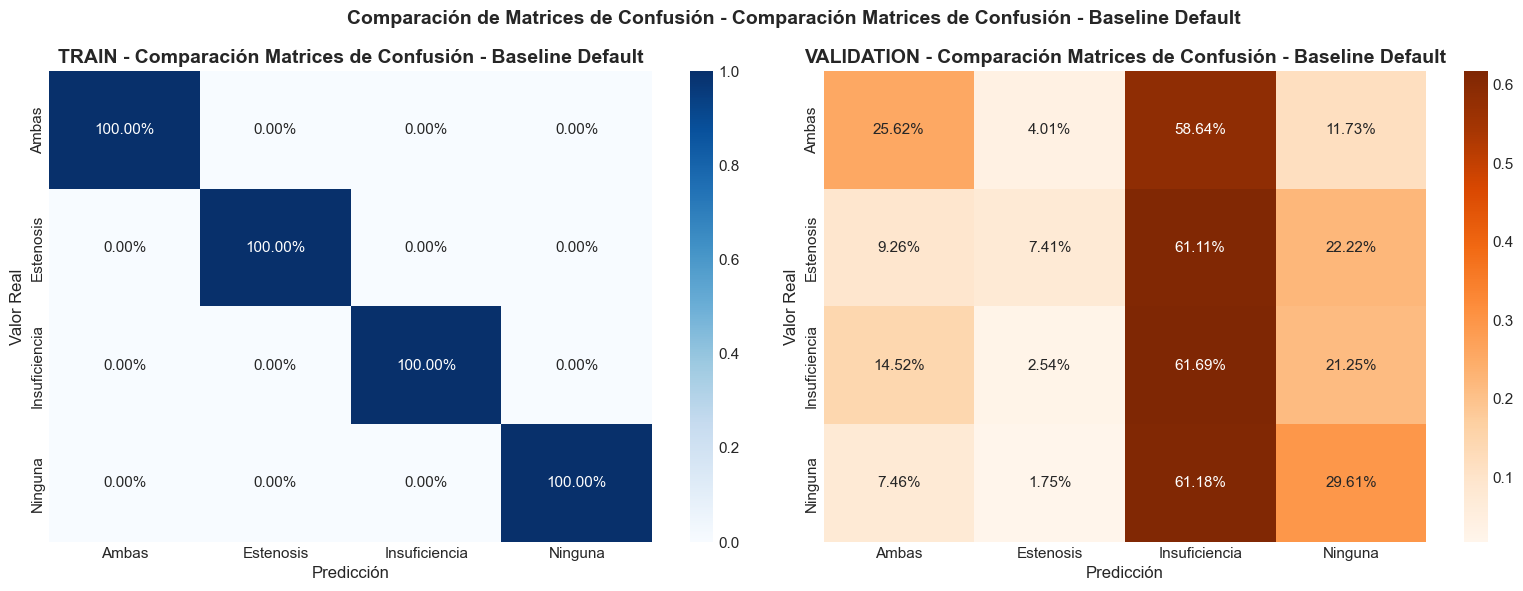

In [51]:
# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    dt_results['metrics_train']['confusion_matrix'],
    dt_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "Comparación Matrices de Confusión - Baseline Default"
)

### Optimización de hiperparámetros

Se hace una búsqueda exhaustiva de hiperparámetros para encontrar la mejor configuración. Se usa GridSearchCV

**Parámetros a optimizar:**
- `max_depth`: Controla la profundidad máxima del árbol (regularización)
- `min_samples_split`: Muestras mínimas para dividir un nodo
- `min_samples_leaf`: Muestras mínimas en cada hoja
- `criterion`: Función de impureza (gini o entropy)

**Métrica de optimización:** Macro F1-Score (apropiada para clases desbalanceadas)

In [52]:
# Defino el grid de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Calculo el número de combinaciones
n_combinations = 1
for v in param_grid.values():
    n_combinations *= len(v)
print(f"Total de combinaciones a evaluar: {n_combinations}")

# Creo el modelo base
dt_base = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

# Configuro GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Ejecuto la búsqueda
log("Iniciando GridSearchCV...")
grid_search.fit(X_train, y_train)
log("GridSearchCV completado.")

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

Total de combinaciones a evaluar: 224
[2026-01-11 18:11:55] Iniciando GridSearchCV...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[2026-01-11 18:23:38] GridSearchCV completado.
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor F1-Score (CV): 0.3244


In [53]:
# Guardo los resultados del grid search
resuls_grid = pd.DataFrame(grid_search.cv_results_)
resuls_grid = resuls_grid.sort_values('rank_test_score')
resuls_grid.to_csv(os.path.join(RESULTS_PATH, 'baseline_gridsearch_results.csv'), index=False)

# Muestro las 10 mejores configuraciones
print(f"10 mejores configuraciones:")
cols_to_show = ['rank_test_score', 'mean_test_score', 'std_test_score',
                'mean_train_score', 'param_max_depth', 'param_min_samples_split',
                'param_min_samples_leaf', 'param_criterion']
print(resuls_grid[cols_to_show].head(10).to_string(index=False))

10 mejores configuraciones:
 rank_test_score  mean_test_score  std_test_score  mean_train_score param_max_depth  param_min_samples_split  param_min_samples_leaf param_criterion
               1         0.324359        0.003701          0.749099              20                        2                       1            gini
               2         0.324141        0.003173          0.973972            None                        5                       1         entropy
               3         0.324109        0.003961          1.000000            None                        2                       1         entropy
               4         0.323869        0.003880          1.000000            None                        2                       1            gini
               5         0.323508        0.002902          0.958425            None                        5                       1            gini
               6         0.322925        0.004178          0.733101           

Se evalua el modelo con los mejores hiperparámetros encontrados.

In [54]:
# Obtengo el mejor modelo
dt_optimized = dt_optimized = DecisionTreeClassifier(
    **grid_search.best_params_,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

dt_opt_results = train_evaluate_model(
    model=dt_optimized,
    name="Decision Tree (Optimizado)",
    X_tr=X_train,
    y_tr=y_train,
    X_vl=X_val,
    y_vl=y_val
)

[2026-01-11 18:23:39] Entrenando modelo Decision Tree (Optimizado).
[2026-01-11 18:23:39] Evaluando Decision Tree (Optimizado) con 5-Fold CV...
[2026-01-11 18:23:45] Ejecutada validación cruzada para Decision Tree (Optimizado).
[2026-01-11 18:23:52] Modelo Decision Tree (Optimizado) entrenado en 13.52s.


In [55]:
# Muestro las métricas
show_metrics(dt_opt_results['metrics_train'], "Métricas TRAIN - Decision Tree (Optimizado)")
show_metrics(dt_opt_results['metrics_val'], "Métricas VALIDATION - Decision Tree (Optimizado)")
show_crossvalidation_results(dt_opt_results['cv_results'])

Métricas TRAIN - Decision Tree (Optimizado)
Métricas globales:
Accuracy:                 0.8180
Balanced Accuracy:        0.9066
Macro F1-Score:           0.7727
Weighted F1-Score:        0.8257
AUC-ROC (macro):          0.9758
Log-Loss:                 0.3616
Brier Score (macro):      0.0573
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.7526     0.9341     0.8336     0.9870     0.9345       8538
Estenosis           0.4911     0.9992     0.6585     0.9974     0.8882       1185
Insuficiencia       0.9859     0.7522     0.8534     0.9529     0.9760      43006
Ninguna             0.6170     0.9411     0.7453     0.9660     0.8879      13149
Métricas VALIDATION - Decision Tree (Optimizado)
Métricas globales:
Accuracy:                 0.4350
Balanced Accuracy:        0.3341
Macro F1-Score:           0.3180
Weighted F1-Score:        0.4508
AUC-ROC (macro):          0.5393
Log-Loss:                 12.3055
Brier Sco

### Guardar el modelo baseline

Se almacena el modelo optimizado junto con sus métricas y configuración para comparación con los modelos de ensemble en los siguientes apartados.

In [56]:
# Preparo las métricas para guardar
save_metrics = {
    'train': {
        'accuracy': dt_opt_results['metrics_train']['accuracy'],
        'balanced_accuracy': dt_opt_results['metrics_train']['balanced_accuracy'],
        'f1_macro': dt_opt_results['metrics_train']['f1_macro'],
        'auc_roc_macro': dt_opt_results['metrics_train']['auc_roc_macro'],
        'log_loss': dt_opt_results['metrics_train']['log_loss'],
        'brier_score_macro': dt_opt_results['metrics_train']['brier_score_macro']
    },
    'validation': {
        'accuracy': dt_opt_results['metrics_val']['accuracy'],
        'balanced_accuracy': dt_opt_results['metrics_val']['balanced_accuracy'],
        'f1_macro': dt_opt_results['metrics_val']['f1_macro'],
        'auc_roc_macro': dt_opt_results['metrics_val']['auc_roc_macro'],
        'log_loss': dt_opt_results['metrics_val']['log_loss'],
        'brier_score_macro': dt_opt_results['metrics_val']['brier_score_macro']
    },
    'by_clase_val': dt_opt_results['metrics_val']['by_class']
}

# Guardo el modelo
model_path = save_model(
    model=dt_optimized,
    name='baseline_decision_tree',
    metrics=save_metrics,
    params=grid_search.best_params_
)


[2026-01-11 18:23:52] Modelo guardado: baseline_decision_tree


### Estudio de resultados

#### Análisis del efecto de max_depth

Se muestra cómo la profundidad máxima afecta el rendimiento y el overfitting.

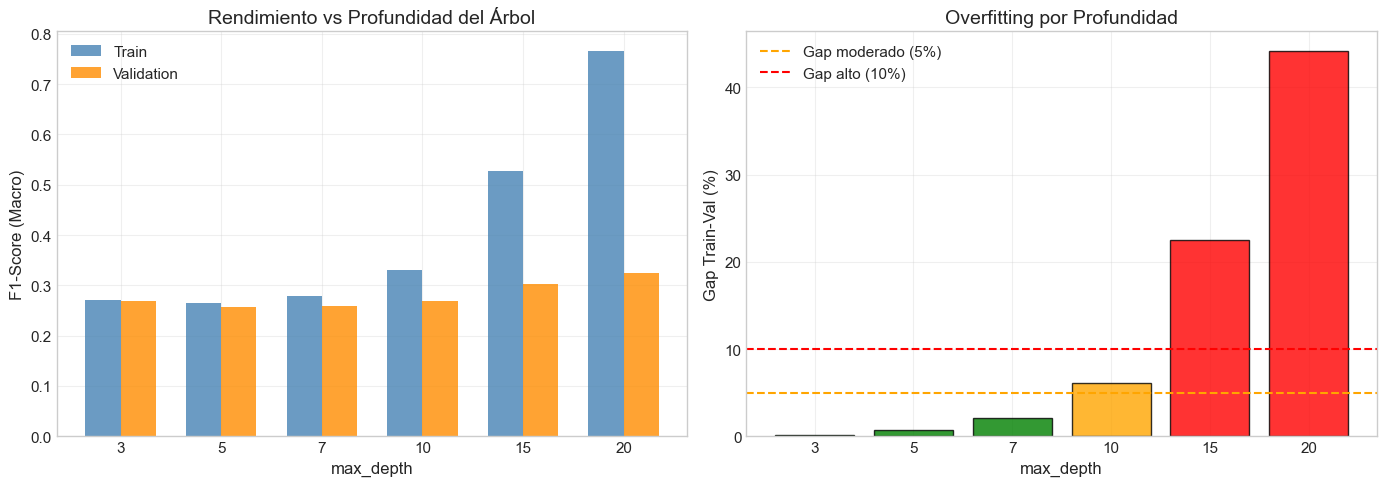

In [57]:
# Extraigo las métricas por max_depth
depth_analysis = resuls_grid.groupby('param_max_depth').agg({
    'mean_test_score': 'max',
    'mean_train_score': 'max',
    'std_test_score': 'mean'
}).reset_index()

# Preparo los datos para su visualización
depths = depth_analysis['param_max_depth'].astype(str).replace('None', 'Inf.')
test_scores = depth_analysis['mean_test_score']
train_scores = depth_analysis['mean_train_score']
gap = train_scores - test_scores

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Scores por profundidad
ax1 = axes[0]
x = range(len(depths))
width = 0.35
ax1.bar([i - width/2 for i in x], train_scores, width, label='Train', color='steelblue', alpha=0.8)
ax1.bar([i + width/2 for i in x], test_scores, width, label='Validation', color='darkorange', alpha=0.8)
ax1.set_xlabel('max_depth')
ax1.set_ylabel('F1-Score (Macro)')
ax1.set_title('Rendimiento vs Profundidad del Árbol')
ax1.set_xticks(x)
ax1.set_xticklabels(depths)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Gap (overfitting)
ax2 = axes[1]
colors = ['green' if g < 0.05 else 'orange' if g < 0.10 else 'red' for g in gap]
ax2.bar(x, gap * 100, color=colors, alpha=0.8, edgecolor='black')
ax2.axhline(y=5, color='orange', linestyle='--', label='Gap moderado (5%)')
ax2.axhline(y=10, color='red', linestyle='--', label='Gap alto (10%)')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('Gap Train-Val (%)')
ax2.set_title('Overfitting por Profundidad')
ax2.set_xticks(x)
ax2.set_xticklabels(depths)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

#### Evaluación del modelo optimizado

COMPARACIÓN: Modelo por defecto contra el modelos optimizado (VALIDATION)
Métrica                        Default   Optimizado        Delta
accuracy                        0.4744       0.4350     -0.0395 menor
balanced_accuracy               0.3108       0.3341     +0.0233 mayor
f1_macro                        0.3118       0.3180     +0.0061 mayor
auc_roc_macro                   0.5371       0.5393     +0.0022 mayor
log_loss                       18.9435      12.3055     -6.6380 menor
brier_score_macro               0.2628       0.2457     -0.0171 menor


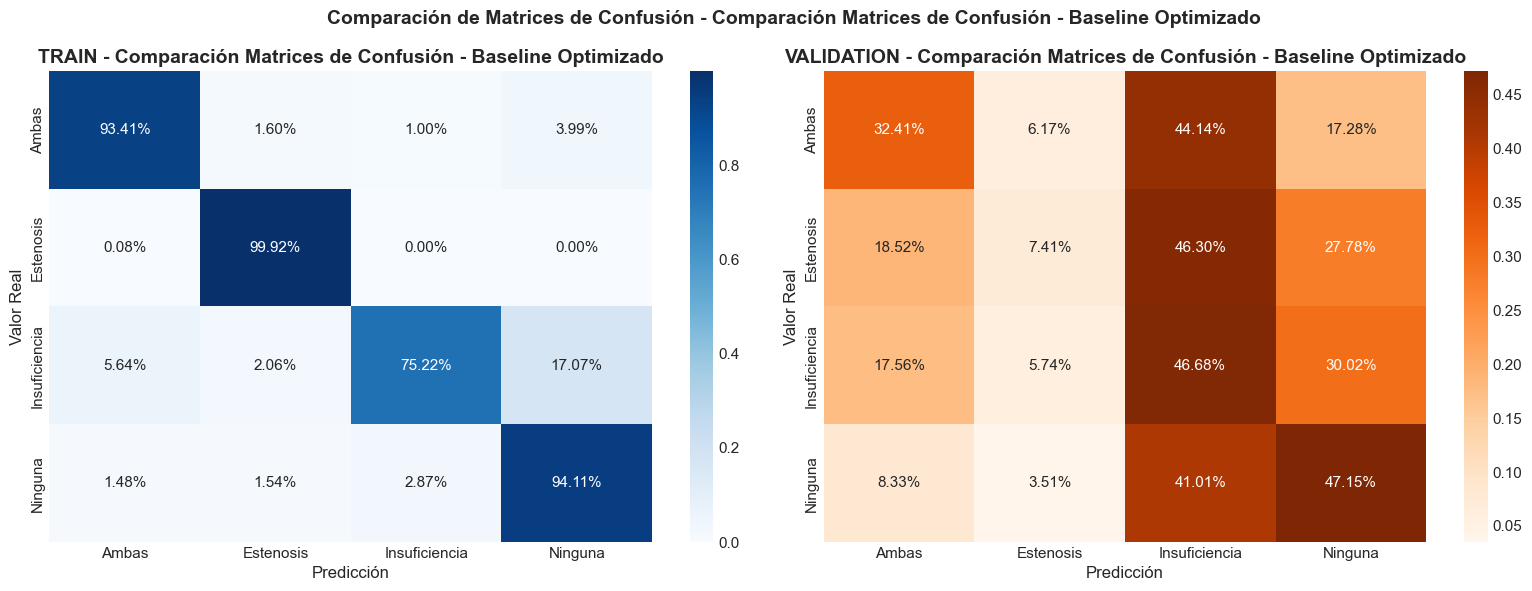

In [58]:
# Comparo el modelo con valores por defecto con el optimizado
print(f"COMPARACIÓN: Modelo por defecto contra el modelos optimizado (VALIDATION)")

metrics_comp = ['accuracy', 'balanced_accuracy', 'f1_macro', 'auc_roc_macro', 'log_loss', 'brier_score_macro']

print(f"{'Métrica':<25} {'Default':>12} {'Optimizado':>12} {'Delta':>12}")
for m in metrics_comp:
    val_default = dt_results['metrics_val'][m]
    val_opt = dt_opt_results['metrics_val'][m]
    delta = val_opt - val_default

    # Para log_loss y brier, menor es mejor
    if m in ['log_loss', 'brier_score_macro']:
        better = "menor" if delta < 0 else "mayor" if delta > 0 else "="
    else:
        better = "mayor" if delta > 0 else "menor" if delta < 0 else "="

    print(f"{m:<25} {val_default:>12.4f} {val_opt:>12.4f} {delta:>+11.4f} {better}")

# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    dt_opt_results['metrics_train']['confusion_matrix'],
    dt_opt_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "Comparación Matrices de Confusión - Baseline Optimizado"
)

#### Curva de aprendizaje

Se analiza si el modelo se beneficiaría de más datos de entrenamiento

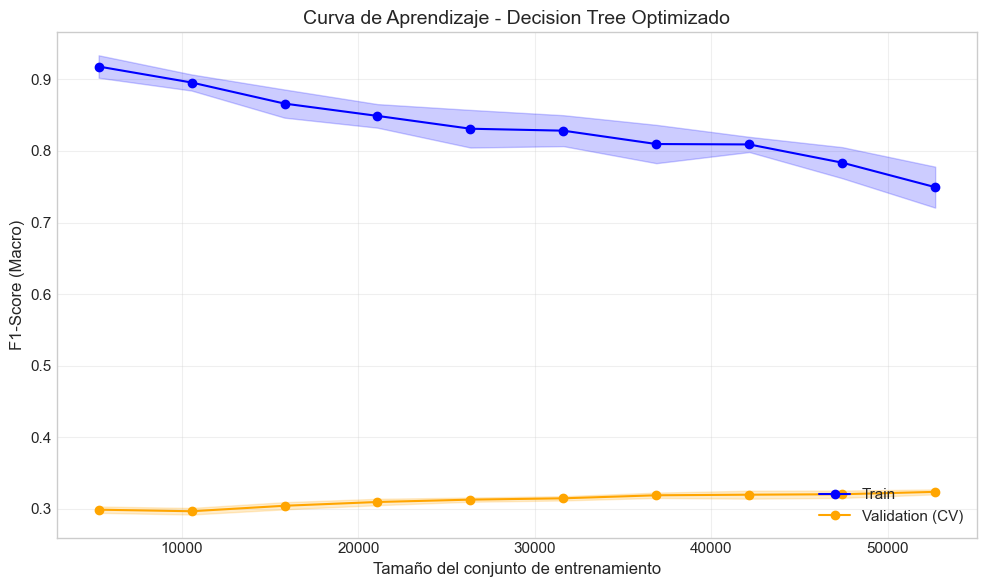

ANÁLISIS DE LA CURVA DE APRENDIZAJE:
Score final (Train):      0.7494 ± 0.0286
Score final (Validation): 0.3238 ± 0.0035
Gap final:                0.4256
Observación: Gap significativo - modelo con alta varianza (overfitting)


In [59]:
# Calculo la curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    dt_optimized,
    X_train, y_train,
    cv=cv_strategy,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculo medias y desviaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Visualizo los resultados
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Train')
ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation (CV)')

ax.set_xlabel('Tamaño del conjunto de entrenamiento')
ax.set_ylabel('F1-Score (Macro)')
ax.set_title('Curva de Aprendizaje - Decision Tree Optimizado')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

# Análisis
print(f"ANÁLISIS DE LA CURVA DE APRENDIZAJE:")
print(f"Score final (Train):      {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Score final (Validation): {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Gap final:                {train_mean[-1] - val_mean[-1]:.4f}")

if train_mean[-1] - val_mean[-1] > 0.10:
    print(f"Observación: Gap significativo - modelo con alta varianza (overfitting)")
elif val_mean[-1] < 0.60:
    print(f"Observación: Score bajo - modelo con alto sesgo (underfitting)")
else:
    print(f"Observación: Balance razonable entre sesgo y varianza")

#### Características más importantes

Se analizan qué características son más importantes para el modelo baseline. Esto será útil para la fase de XAI posterior.

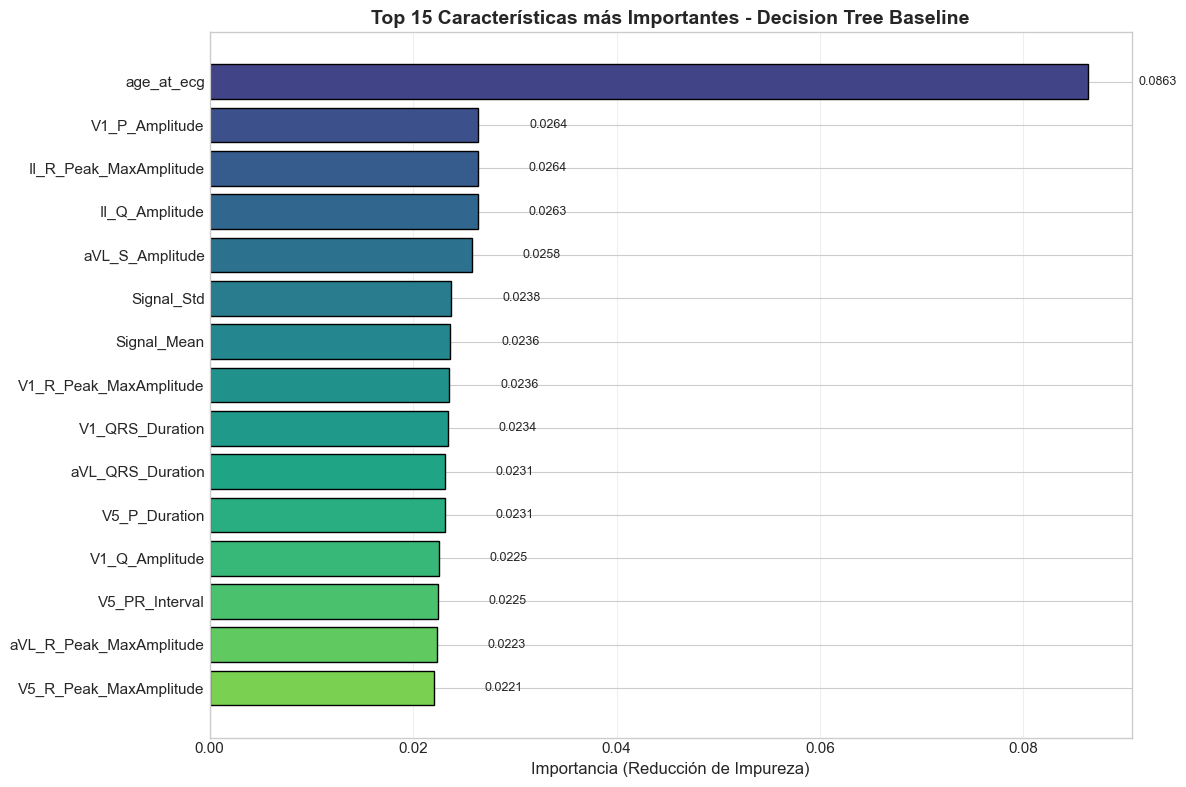

10 características más importantes:
               feature  importance
            age_at_ecg    0.086326
        V1_P_Amplitude    0.026394
II_R_Peak_MaxAmplitude    0.026373
        II_Q_Amplitude    0.026331
       aVL_S_Amplitude    0.025787
            Signal_Std    0.023766
           Signal_Mean    0.023648
V1_R_Peak_MaxAmplitude    0.023574
       V1_QRS_Duration    0.023421
      aVL_QRS_Duration    0.023142


In [60]:
# Obtengo la importancia de las características
importancies = pd.DataFrame({
    'feature': FEATURE_NAMES,
    'importance': dt_optimized.feature_importances_
}).sort_values('importance', ascending=False)

# Mejores 15 características
top_n = 15
top_features = importancies.head(top_n)

# Visualizo los resultados
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(range(top_n), top_features['importance'].values, color=colors, edgecolor='black')

ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importancia (Reducción de Impureza)', fontsize=12)
ax.set_title(f'Top {top_n} Características más Importantes - Decision Tree Baseline',
             fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

# Añado los valores
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values)):
    ax.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

# Guardo las importancias
importancies.to_csv(os.path.join(RESULTS_PATH, 'baseline_feature_importance.csv'), index=False)

# Muestro top 10
print(f"10 características más importantes:")
print(importancies.head(10).to_string(index=False))

### Resumen del modelo usado como baseline (Decision tree)

Se presenta un análisis descriptivo del rendimiento del modelo baseline.

In [61]:
print(f"RESUMEN DEL MODELO BASELINE (Decision Tree)")

print(f"CONFIGURACIÓN DEL MODELO:")
print(f"Tipo: DecisionTreeClassifier")
print(f"class_weight: balanced")
for param, valor in grid_search.best_params_.items():
    print(f"{param}: {valor}")

print(f"RENDIMIENTO EN VALIDATION:")
print(f"Accuracy:          {dt_opt_results['metrics_val']['accuracy']:.4f}")
print(f"Balanced Accuracy: {dt_opt_results['metrics_val']['balanced_accuracy']:.4f}")
print(f"Macro F1-Score:    {dt_opt_results['metrics_val']['f1_macro']:.4f}")
print(f"AUC-ROC (macro):   {dt_opt_results['metrics_val']['auc_roc_macro']:.4f}")
print(f"Log-Loss:          {dt_opt_results['metrics_val']['log_loss']:.4f}")
print(f"Brier Score:       {dt_opt_results['metrics_val']['brier_score_macro']:.4f}")

# Análisis descriptivo de sensibilidad por clase
print(f"SENSIBILIDAD POR CLASE (VALIDATION):")
print(f"Comparación con valores de referencia orientativos")
print(f"Los valores de referencia NO son umbrales validados clínicamente")
print(f"{'Clase':<15} {'Sensibilidad':>12} {'Ref. Orientativo':>18} {'Diferencia':>12}")

for clas in CLASS_NAMES.values():
    recall = dt_opt_results['metrics_val']['by_class'][clas]['recall']
    ref = REFERENCE_VALUES['guideline_sensitivity'].get(clas, 0.70)
    print(type(recall), recall)
    print(type(ref), ref)
    diff = recall - ref['value']
    print(f"{clas:<15} {recall:>12.1%} {ref['value']:>18.0%} {diff:>+12.1%}")

# Análisis de generalización
gap_f1 = dt_opt_results['metrics_train']['f1_macro'] - dt_opt_results['metrics_val']['f1_macro']
print(f"GENERALIZACIÓN:")
print(f"Gap F1 (TRAIN - VAL): {gap_f1:.4f} ({gap_f1*100:.1f}%)")
if gap_f1 < 0.05:
    print(f"Nivel: Bueno (gap < 5%)")
elif gap_f1 < 0.10:
    print(f"Nivel: Moderado (5% ≤ gap < 10%)")
else:
    print(f"Nivel: Preocupante - posible overfitting (gap ≥ 10%)")

# Observaciones
print(f"OBSERVACIONES:")
# Identifico clases con sensibilidad notablemente baja
for clas in CLASS_NAMES.values():
    recall = dt_opt_results['metrics_val']['by_class'][clas]['recall']
    ref = REFERENCE_VALUES['guideline_sensitivity'].get(clas, 0.70)
    if recall < ref['value'] - 0.10:
        print(f"* {clas}: Sensibilidad ({recall:.1%}) notablemente inferior al valor orientativo ({ref['value']:.0%})")

if dt_opt_results['metrics_val']['f1_macro'] < 0.50:
    print(f"* Macro F1-Score bajo - el modelo tiene dificultades con clases minoritarias")
elif dt_opt_results['metrics_val']['f1_macro'] < 0.65:
    print(f"* Macro F1-Score moderado - esperable para un baseline simple")
else:
    print(f"* Macro F1-Score razonable para un modelo baseline")

RESUMEN DEL MODELO BASELINE (Decision Tree)
CONFIGURACIÓN DEL MODELO:
Tipo: DecisionTreeClassifier
class_weight: balanced
criterion: gini
max_depth: 20
min_samples_leaf: 1
min_samples_split: 2
RENDIMIENTO EN VALIDATION:
Accuracy:          0.4350
Balanced Accuracy: 0.3341
Macro F1-Score:    0.3180
AUC-ROC (macro):   0.5393
Log-Loss:          12.3055
Brier Score:       0.2457
SENSIBILIDAD POR CLASE (VALIDATION):
Comparación con valores de referencia orientativos
Los valores de referencia NO son umbrales validados clínicamente
Clase           Sensibilidad   Ref. Orientativo   Diferencia
<class 'numpy.float64'> 0.32407407407407407
<class 'dict'> {'value': 0.75, 'note': 'Patología combinada que requiere una buena detección'}
Ambas                  32.4%                75%       -42.6%
<class 'numpy.float64'> 0.07407407407407407
<class 'dict'> {'value': 0.7, 'note': 'Clase muy minoritaria (1.8%) por lo que es esperable una menor sensibilidad'}
Estenosis               7.4%                70% 

## Entrenamiento de modelos ensamble

Se procede a entrenar y evaluar cuatro modelos de ensemble para compararlos con el baseline:
1. **Random Forest** - Bagging de árboles de decisión
2. **XGBoost** - Gradient Boosting optimizado
3. **CatBoost** - Gradient Boosting con manejo nativo de categóricas
4. **LightGBM** - Gradient Boosting eficiente basado en histogramas

**Estrategia:**
En esta fase se entrenan los modelos con parámetros por defecto (incluyendo class_weight) para establecer un rendimiento inicial. La optimización de hiperparámetros se realizará posteriormente.

### Random Forest

Random Forest es un método de ensemble que combina múltiples árboles de decisión mediante bagging (Bootstrap Aggregating). Cada árbol se entrena con una muestra bootstrap del dataset y considera un subconjunto aleatorio de features en cada split.

**Ventajas para este modelo:**
- Robusto al overfitting comparadolo con un único árbol
- Maneja bien el desbalance con class_weight='balanced'
- Proporciona la importancia de las características
- Paralelizable (n_jobs=-1)

In [62]:
# Defino el modelo
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

# Entreno el modelo
rf_results = train_evaluate_model(
    rf_model, "RandomForest",
    X_train, y_train, X_val, y_val
)

[2026-01-11 18:24:12] Entrenando modelo RandomForest.
[2026-01-11 18:24:12] Evaluando RandomForest con 5-Fold CV...
[2026-01-11 18:25:13] Ejecutada validación cruzada para RandomForest.
[2026-01-11 18:25:30] Modelo RandomForest entrenado en 78.22s.


In [63]:
# Muestro las métricas
show_metrics(rf_results['metrics_train'], "RANDOM FOREST - TRAIN")
show_metrics(rf_results['metrics_val'], "RANDOM FOREST - VALIDATION")
show_crossvalidation_results(rf_results['cv_results'])

RANDOM FOREST - TRAIN
Métricas globales:
Accuracy:                 1.0000
Balanced Accuracy:        1.0000
Macro F1-Score:           1.0000
Weighted F1-Score:        1.0000
AUC-ROC (macro):          1.0000
Log-Loss:                 0.1990
Brier Score (macro):      0.0159
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               1.0000     1.0000     1.0000     1.0000     1.0000       8538
Estenosis           1.0000     1.0000     1.0000     1.0000     1.0000       1185
Insuficiencia       1.0000     1.0000     1.0000     1.0000     1.0000      43006
Ninguna             1.0000     1.0000     1.0000     1.0000     1.0000      13149
RANDOM FOREST - VALIDATION
Métricas globales:
Accuracy:                 0.5952
Balanced Accuracy:        0.2548
Macro F1-Score:           0.1981
Weighted F1-Score:        0.4509
AUC-ROC (macro):          0.6373
Log-Loss:                 0.9779
Brier Score (macro):      0.1363
Métricas por clase:
C

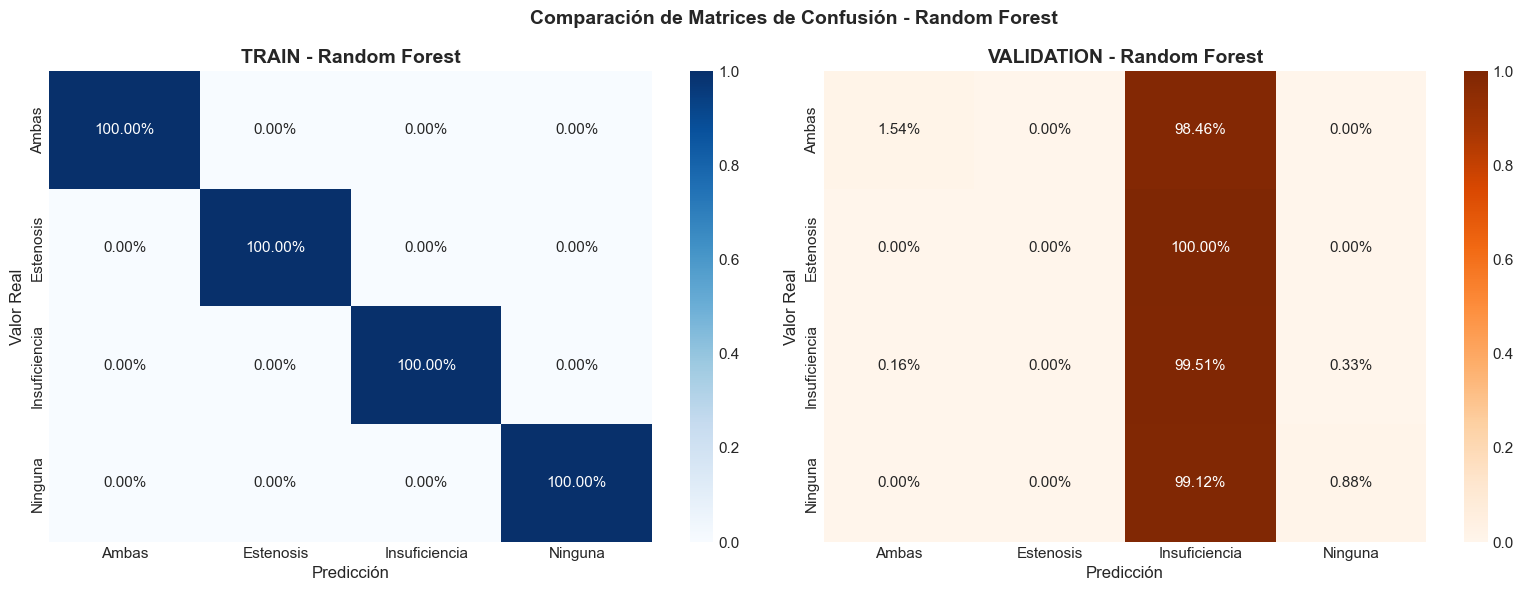

In [64]:
# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    rf_results['metrics_train']['confusion_matrix'],
    rf_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "Random Forest"
)

### XGBoost

XGBoost (eXtreme Gradient Boosting) es una implementación optimizada de gradient boosting. Utiliza regularización L1/L2 para prevenir overfitting.

**Configuración para multiclase desbalanceado:**
- `objective='multi:softprob'`: Clasificación multiclase con probabilidades
- `eval_metric='mlogloss'`: Optimiza log-loss
- `sample_weight`: Pesos calculados por clase para compensar desbalance

**Para usar GPU** hay que usar los parámetros: tree_method='gpu_hist', predictor='gpu_predictor'

In [65]:
# Defino el modelo
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=N_CLASSES,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
    #,device='cuda' # Los incluyo para usar la GPU
)

# Defino los pesos en sample_weight
sample_weights_train = np.array([CLASS_WEIGHTS[int(y)] for y in y_train])

# Entreno el modelo
xgb_results = train_evaluate_model(
    xgb_model, "XGBoost",
    X_train, y_train, X_val, y_val,
    sample_weight=sample_weights_train
)

[2026-01-11 18:25:30] Entrenando modelo XGBoost.
[2026-01-11 18:25:30] Evaluando XGBoost con 5-Fold CV...
[2026-01-11 18:25:54] Ejecutada validación cruzada para XGBoost.
[2026-01-11 18:25:58] Modelo XGBoost entrenado en 28.15s.


In [66]:
# Muestro las métricas
show_metrics(xgb_results['metrics_train'], "XGBOOST - TRAIN")
show_metrics(xgb_results['metrics_val'], "XGBOOST - VALIDATION")
show_crossvalidation_results(xgb_results['cv_results'])

XGBOOST - TRAIN
Métricas globales:
Accuracy:                 0.6619
Balanced Accuracy:        0.8054
Macro F1-Score:           0.6355
Weighted F1-Score:        0.6742
AUC-ROC (macro):          0.9113
Log-Loss:                 0.8556
Brier Score (macro):      0.1192
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.4881     0.8216     0.6124     0.9159     0.6899       8538
Estenosis           0.4402     1.0000     0.6113     0.9999     0.9930       1185
Insuficiencia       0.9342     0.5693     0.7075     0.8570     0.9211      43006
Ninguna             0.4831     0.8305     0.6109     0.8725     0.6509      13149
XGBOOST - VALIDATION
Métricas globales:
Accuracy:                 0.4403
Balanced Accuracy:        0.4017
Macro F1-Score:           0.3511
Weighted F1-Score:        0.4505
AUC-ROC (macro):          0.6697
Log-Loss:                 1.1416
Brier Score (macro):      0.1620
Métricas por clase:
Clase        

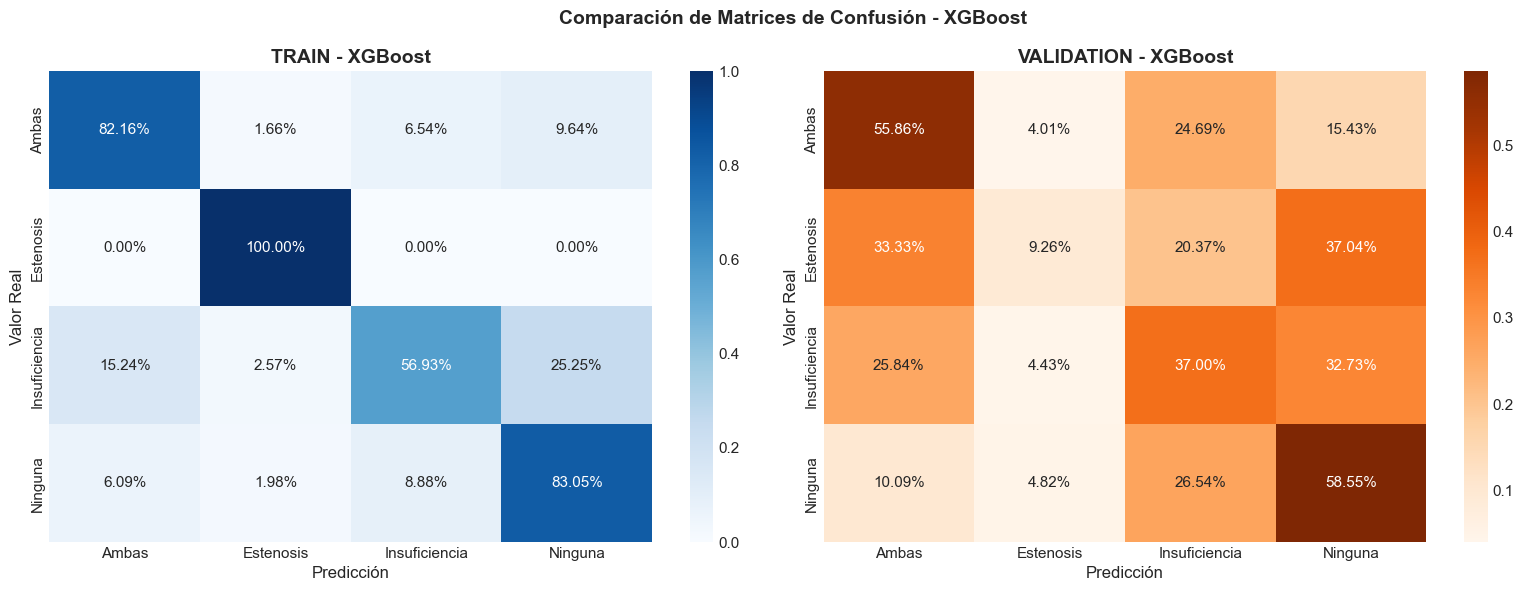

In [67]:
# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    xgb_results['metrics_train']['confusion_matrix'],
    xgb_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "XGBoost"
)

### CatBoost

CatBoost (Categorical Boosting) es un algoritmo de gradient boosting desarrollado por Yandex que maneja de forma nativa las variables categóricas.

**Ventajas específicas:**
- Manejo nativo de variables categóricas (cat_features)
- Mejor calibración de probabilidades out-of-the-box
- Menos propenso a overfitting (ordered boosting)
- Soporta class_weights directamente

**Para usar GPU** hay que usar el parámetro: task_type='GPU'

In [68]:
# PARAMETROS DE CATBOOST
# Defino los pesos en sample_weight
catboost_class_weights = [CLASS_WEIGHTS[i] for i in range(N_CLASSES)]
# Defino los indices de las variables categóricas
CATEGORICAL_INDEXES = [FEATURE_NAMES.index(col) for col in CATEGORICAL_FEATURES if col in FEATURE_NAMES]

In [69]:
# Defino el modelo
cat_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    class_weights=catboost_class_weights,
    cat_features=CATEGORICAL_INDEXES,
    random_seed=RANDOM_STATE,
    verbose=False,
    allow_writing_files=False
    #,task_type='GPU' # Lo incluyo para usar la GPU
)

# Entreno el modelo
cat_results = train_evaluate_model(
    cat_model, "CatBoost",
    X_train, y_train, X_val, y_val
)

[2026-01-11 18:25:59] Entrenando modelo CatBoost.
[2026-01-11 18:25:59] Evaluando CatBoost con 5-Fold CV...
[2026-01-11 18:26:40] Ejecutada validación cruzada para CatBoost.
[2026-01-11 18:26:58] Modelo CatBoost entrenado en 59.15s.


In [70]:
# Muestro las métricas
show_metrics(cat_results['metrics_train'], "CATBOOST - TRAIN")
show_metrics(cat_results['metrics_val'], "CATBOOST - VALIDATION")
show_crossvalidation_results(cat_results['cv_results'])

CATBOOST - TRAIN
Métricas globales:
Accuracy:                 0.4445
Balanced Accuracy:        0.6077
Macro F1-Score:           0.3985
Weighted F1-Score:        0.4604
AUC-ROC (macro):          0.7863
Log-Loss:                 1.1540
Brier Score (macro):      0.1616
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.3125     0.6222     0.4160     0.7863     0.3945       8538
Estenosis           0.1469     0.8312     0.2497     0.9670     0.5765       1185
Insuficiencia       0.8096     0.3394     0.4783     0.6633     0.7827      43006
Ninguna             0.3474     0.6379     0.4498     0.7287     0.3887      13149
CATBOOST - VALIDATION
Métricas globales:
Accuracy:                 0.3629
Balanced Accuracy:        0.3974
Macro F1-Score:           0.3129
Weighted F1-Score:        0.3681
AUC-ROC (macro):          0.6517
Log-Loss:                 1.2496
Brier Score (macro):      0.1740
Métricas por clase:
Clase      

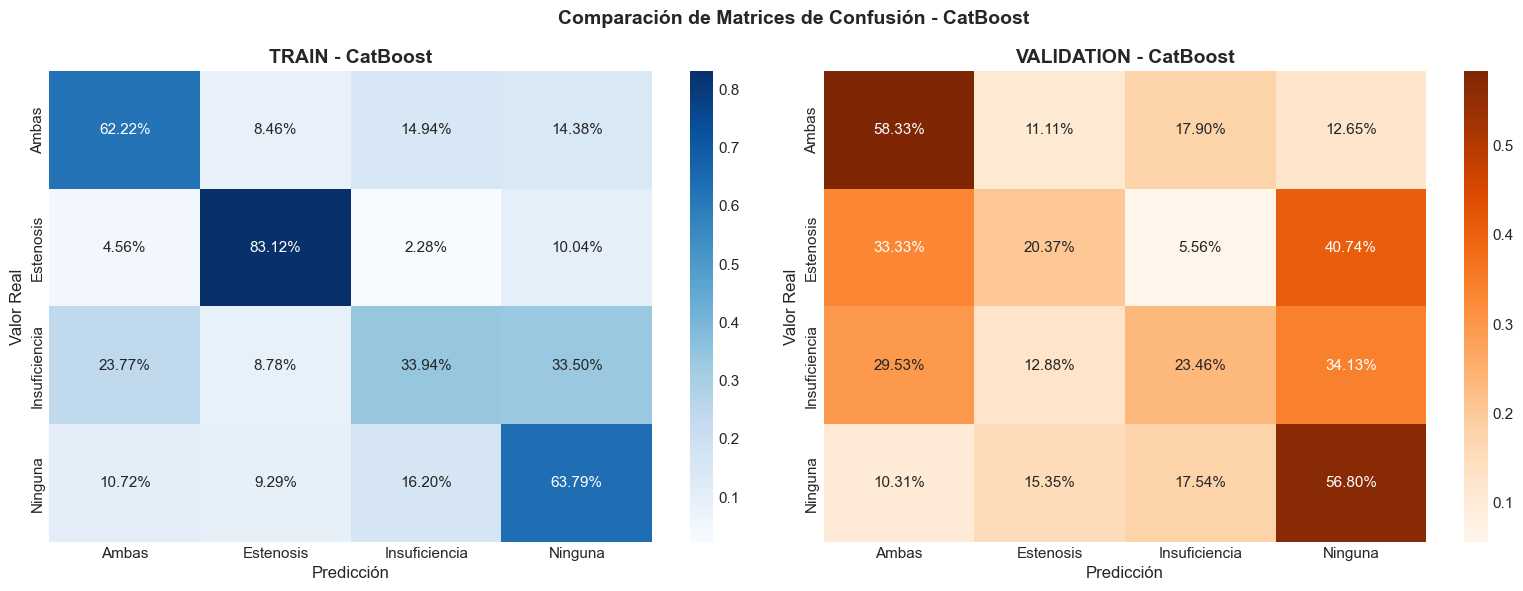

In [71]:
# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    cat_results['metrics_train']['confusion_matrix'],
    cat_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "CatBoost"
)

### LightGBM

LightGBM (Light Gradient Boosting Machine) es una implementación de gradient boosting desarrollada por Microsoft. Utiliza técnicas de histograma y crecimiento leaf-wise.

**Ventajas:**
- Muy rápido en entrenamiento
- Eficiente en memoria
- Soporta class_weight='balanced'
- Buen rendimiento en datasets grandes

**Para usar GPU** hay que usar el parámetro: device='gpu'

In [72]:
# Defino el modelo
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    class_weight='balanced',
    objective='multiclass',
    num_class=N_CLASSES,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True
    #,device='gpu' # Lo incluyo para usar la GPU
)

# Entreno el modelo
lgbm_results = train_evaluate_model(
    lgbm_model, "LightGBM",
    X_train, y_train, X_val, y_val
)

[2026-01-11 18:26:59] Entrenando modelo LightGBM.
[2026-01-11 18:26:59] Evaluando LightGBM con 5-Fold CV...
[2026-01-11 18:27:12] Ejecutada validación cruzada para LightGBM.
[2026-01-11 18:27:15] Modelo LightGBM entrenado en 16.43s.


In [73]:
# Muestro las métricas
show_metrics(lgbm_results['metrics_train'], "LIGHTGBM - TRAIN")
show_metrics(lgbm_results['metrics_val'], "LIGHTGBM - VALIDATION")
show_crossvalidation_results(lgbm_results['cv_results'])

LIGHTGBM - TRAIN
Métricas globales:
Accuracy:                 0.6382
Balanced Accuracy:        0.7911
Macro F1-Score:           0.6196
Weighted F1-Score:        0.6502
AUC-ROC (macro):          0.8996
Log-Loss:                 0.8658
Brier Score (macro):      0.1223
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.4579     0.8113     0.5854     0.9059     0.6388       8538
Estenosis           0.4473     1.0000     0.6182     0.9998     0.9907       1185
Insuficiencia       0.9213     0.5405     0.6813     0.8327     0.9061      43006
Ninguna             0.4673     0.8128     0.5934     0.8602     0.6207      13149
LIGHTGBM - VALIDATION
Métricas globales:
Accuracy:                 0.4403
Balanced Accuracy:        0.4075
Macro F1-Score:           0.3548
Weighted F1-Score:        0.4496
AUC-ROC (macro):          0.6520
Log-Loss:                 1.1568
Brier Score (macro):      0.1647
Métricas por clase:
Clase      

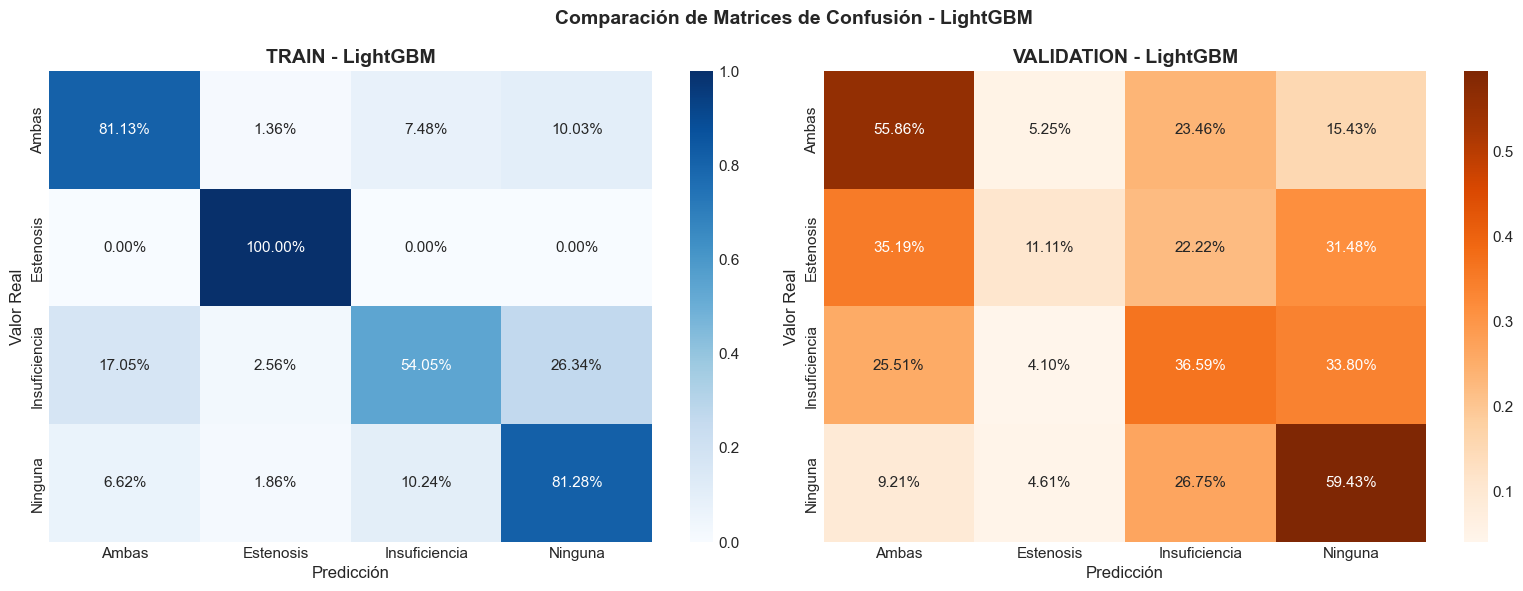

In [74]:
# Muestro las matrices de confusión
plot_confusion_matrix_comparison(
    lgbm_results['metrics_train']['confusion_matrix'],
    lgbm_results['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "LightGBM"
)

### Guardar los modelos ensamble

Se guardan todos los modelos para uso posterior.

In [75]:
# Recopilo los resultados
all_results = [rf_results, xgb_results, cat_results, lgbm_results]

# Guardo todos los modelos
for r in all_results:
    name = r['name'].lower().replace(' ', '_')
    save_metrics = {
        'train': {k: v for k, v in r['metrics_train'].items() if k != 'confusion_matrix' and k != 'by_class'},
        'validation': {k: v for k, v in r['metrics_val'].items() if k != 'confusion_matrix' and k != 'by_class'},
        'by_class_val': r['metrics_val']['by_class']
    }

    params = r['model'].get_params() if hasattr(r['model'], 'get_params') else {}
    save_model(r['model'], name, save_metrics, params)

[2026-01-11 18:27:17] Modelo guardado: randomforest
[2026-01-11 18:27:17] Modelo guardado: xgboost
[2026-01-11 18:27:17] Modelo guardado: catboost
[2026-01-11 18:27:17] Modelo guardado: lightgbm


### Estudio de resultados

#### Comparación con Baseline
Se procede a realizar una comparación de los resultados con el modelo base.

In [76]:
# Creo un dataFrame comparativo
comparation = []

# Añado el modelo baseline
comparation.append({
    'Model': 'Decision Tree (Baseline)',
    'Accuracy': dt_opt_results['metrics_val'].get('accuracy', 0),
    'Balanced Acc': dt_opt_results['metrics_val'].get('balanced_accuracy', 0),
    'Macro F1': dt_opt_results['metrics_val'].get('f1_macro', 0),
    'AUC-ROC': dt_opt_results['metrics_val'].get('auc_roc_macro', 0),
    'Log-Loss': dt_opt_results['metrics_val'].get('log_loss', 0),
    'Brier Score': dt_opt_results['metrics_val'].get('brier_score_macro', 0),
    'Time in segs': 0
})

for r in all_results:
    m = r['metrics_val']
    comparation.append({
        'Model': r['name'],
        'Accuracy': m['accuracy'],
        'Balanced Acc': m['balanced_accuracy'],
        'Macro F1': m['f1_macro'],
        'AUC-ROC': m['auc_roc_macro'],
        'Log-Loss': m['log_loss'],
        'Brier Score': m['brier_score_macro'],
        'Time in segs': r['train_time']
    })

df_comparation = pd.DataFrame(comparation)

print(f"COMPARACIÓN DE MODELOS (VALIDATION)")
print(df_comparation.to_string(index=False, float_format='{:.4f}'.format))

# Guardo el resultado de la comparación
df_comparation.to_csv(os.path.join(RESULTS_PATH, 'TFG-Modelado_comparacion_modelos.csv'), index=False)

COMPARACIÓN DE MODELOS (VALIDATION)
                   Model  Accuracy  Balanced Acc  Macro F1  AUC-ROC  Log-Loss  Brier Score  Time in segs
Decision Tree (Baseline)    0.4350        0.3341    0.3180   0.5393   12.3055       0.2457        0.0000
            RandomForest    0.5952        0.2548    0.1981   0.6373    0.9779       0.1363       78.2223
                 XGBoost    0.4403        0.4017    0.3511   0.6697    1.1416       0.1620       28.1469
                CatBoost    0.3629        0.3974    0.3129   0.6517    1.2496       0.1740       59.1509
                LightGBM    0.4403        0.4075    0.3548   0.6520    1.1568       0.1647       16.4349


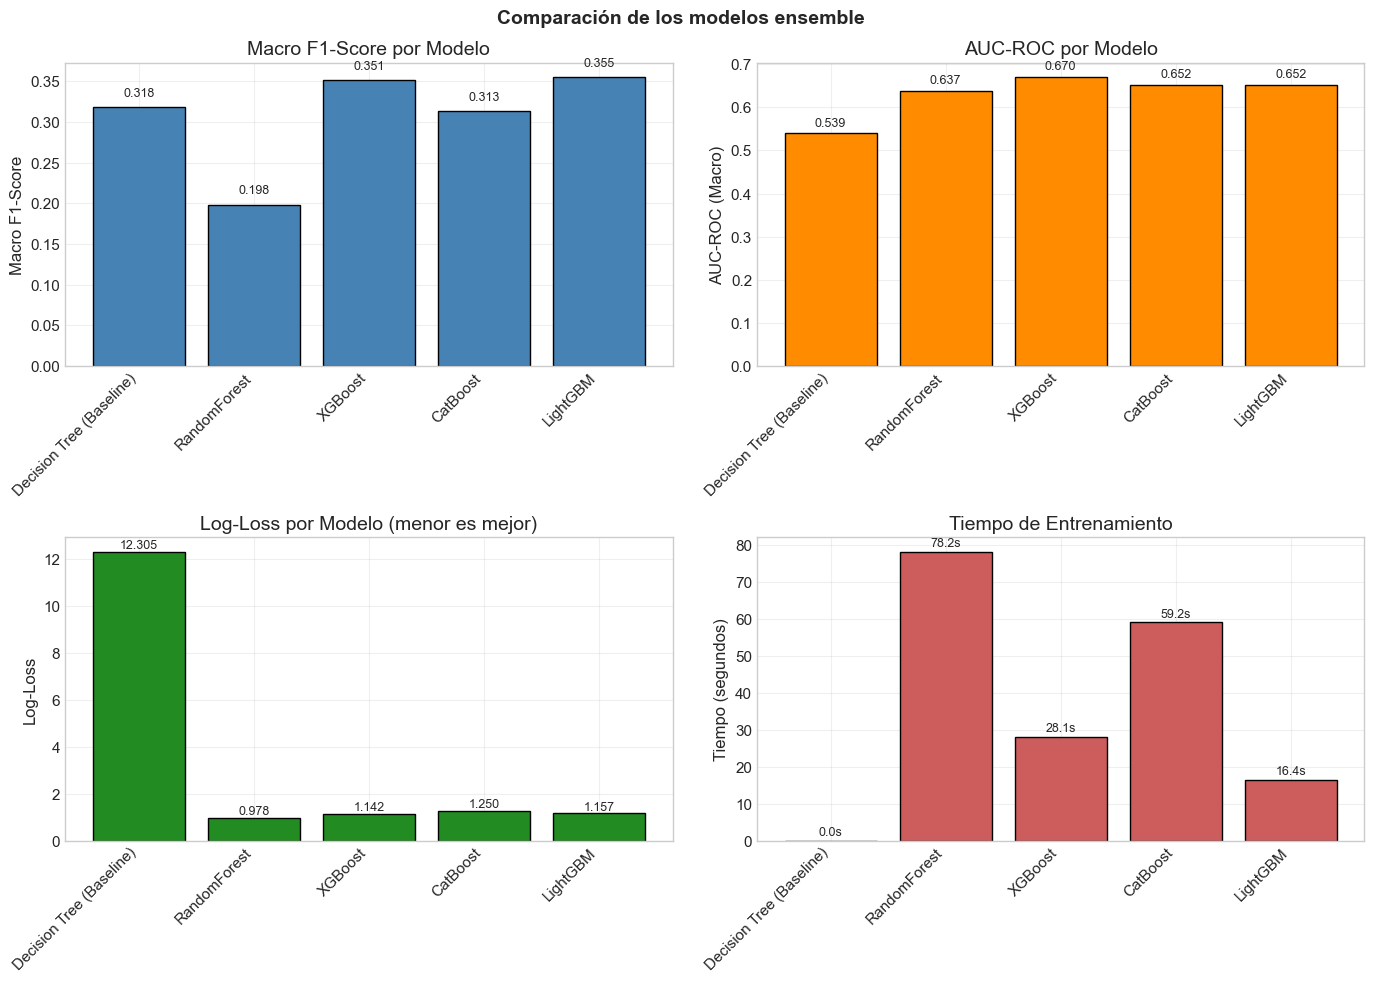

In [77]:
# Preparo los gráficos para hacer una visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

modelos = df_comparation['Model'].tolist()
x = range(len(modelos))

# Macro F1
ax1 = axes[0, 0]
bars1 = ax1.bar(x, df_comparation['Macro F1'], color='steelblue', edgecolor='black')
ax1.set_ylabel('Macro F1-Score')
ax1.set_title('Macro F1-Score por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels(modelos, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
for bar, val in zip(bars1, df_comparation['Macro F1']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9)

# AUC-ROC
ax2 = axes[0, 1]
bars2 = ax2.bar(x, df_comparation['AUC-ROC'], color='darkorange', edgecolor='black')
ax2.set_ylabel('AUC-ROC (Macro)')
ax2.set_title('AUC-ROC por Modelo')
ax2.set_xticks(x)
ax2.set_xticklabels(modelos, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars2, df_comparation['AUC-ROC']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9)

# Log-Loss
ax3 = axes[1, 0]
bars3 = ax3.bar(x, df_comparation['Log-Loss'], color='forestgreen', edgecolor='black')
ax3.set_ylabel('Log-Loss')
ax3.set_title('Log-Loss por Modelo (menor es mejor)')
ax3.set_xticks(x)
ax3.set_xticklabels(modelos, rotation=45, ha='right')
ax3.grid(True, alpha=0.3)
for bar, val in zip(bars3, df_comparation['Log-Loss']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9)

# Tiempo
ax4 = axes[1, 1]
bars4 = ax4.bar(x, df_comparation['Time in segs'], color='indianred', edgecolor='black')
ax4.set_ylabel('Tiempo (segundos)')
ax4.set_title('Tiempo de Entrenamiento')
ax4.set_xticks(x)
ax4.set_xticklabels(modelos, rotation=45, ha='right')
ax4.grid(True, alpha=0.3)
for bar, val in zip(bars4, df_comparation['Time in segs']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}s',
             ha='center', va='bottom', fontsize=9)

plt.suptitle('Comparación de los modelos ensemble', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

#### Análisis de sensibilidad por clase
Se ejecuta el análisis de sensibilidad.

In [78]:
recall_analysis(all_results)

ANÁLISIS DE SENSIBILIDAD POR CLASE (VALIDATION)
Sensibilidad (Recall) por clase:
       Model  Ambas  Estenosis  Insuficiencia  Ninguna
RandomForest 0.0154     0.0000         0.9951   0.0088
     XGBoost 0.5586     0.0926         0.3700   0.5855
    CatBoost 0.5833     0.2037         0.2346   0.5680
    LightGBM 0.5586     0.1111         0.3659   0.5943
Valores de referencia orientativos:
Ambas: 75%  ->  Patología combinada que requiere una buena detección
Estenosis: 70%  ->  Clase muy minoritaria (1.8%) por lo que es esperable una menor sensibilidad
Insuficiencia: 80%  ->  Clase mayoritaria (65%) lo que predispone una mayor facilidad de detección
Ninguna: 70%  ->  Detectar la ausencia de patología para evitar el sobrediagnóstico
OBSERVACIONES:
RandomForest: Sensibilidad inferior al valor orientativo en: Ambas (1.5%, ref: 75%), Estenosis (0.0%, ref: 70%), Ninguna (0.9%, ref: 70%)
XGBoost: Sensibilidad inferior al valor orientativo en: Ambas (55.9%, ref: 75%), Estenosis (9.3%, ref: 70%)

In [79]:
# Análisis de generalización (Gap Train-Val)
print(f"ANÁLISIS DE GENERALIZACIÓN (GAP TRAIN - VALIDATION)")

gap_data = []
for r in all_results:
    gap_f1 = r['metrics_train']['f1_macro'] - r['metrics_val']['f1_macro']
    gap_ll = r['metrics_val']['log_loss'] - r['metrics_train']['log_loss']

    # Clasificación descriptiva (sin juicios de cumple/no cumple)
    if gap_f1 < REFERENCE_VALUES['gap_train_val']['good']:
        level = "Bueno"
    elif gap_f1 < REFERENCE_VALUES['gap_train_val']['moderate']:
        level = "Moderado"
    else:
        level = "Alto"

    gap_data.append({
        'Model': r['name'],
        'F1 Train': r['metrics_train']['f1_macro'],
        'F1 Val': r['metrics_val']['f1_macro'],
        'Gap F1': gap_f1,
        'Gap F1 (%)': gap_f1 * 100,
        'LogLoss Train': r['metrics_train']['log_loss'],
        'LogLoss Val': r['metrics_val']['log_loss'],
        'Gap LL': gap_ll,
        'Level Gap': level
    })

df_gap = pd.DataFrame(gap_data)
print(df_gap[['Model', 'F1 Train', 'F1 Val', 'Gap F1 (%)', 'Level Gap']].to_string(index=False, float_format='{:.2f}'.format))

print(f"Referencia de niveles:")
print(f"Bueno:    Gap < {REFERENCE_VALUES['gap_train_val']['good']*100:.0f}%")
print(f"Moderado: Gap < {REFERENCE_VALUES['gap_train_val']['moderate']*100:.0f}%")
print(f"Alto:     Gap >= {REFERENCE_VALUES['gap_train_val']['alarm']*100:.0f}%")

# Guardo los resultados
df_gap.to_csv(os.path.join(RESULTS_PATH, 'TFG-Modelado_gap_analysis.csv'), index=False)

ANÁLISIS DE GENERALIZACIÓN (GAP TRAIN - VALIDATION)
       Model  F1 Train  F1 Val  Gap F1 (%) Level Gap
RandomForest      1.00    0.20       80.19      Alto
     XGBoost      0.64    0.35       28.44      Alto
    CatBoost      0.40    0.31        8.56  Moderado
    LightGBM      0.62    0.35       26.48      Alto
Referencia de niveles:
Bueno:    Gap < 5%
Moderado: Gap < 10%
Alto:     Gap >= 15%


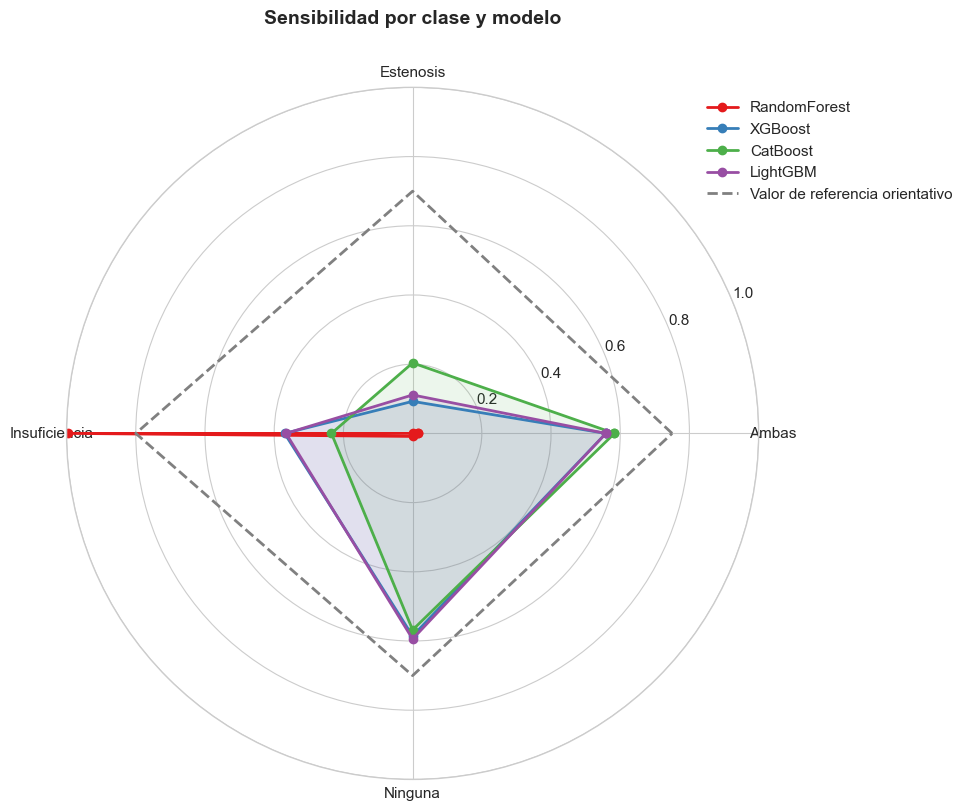

In [80]:
# Creo un gráfico de radar comparativo de sensibilidad por clase
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = list(CLASS_NAMES.values())
n_cats = len(categories)
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]

colors_radar = plt.cm.Set1(range(len(all_results)))

for idx, r in enumerate(all_results):
    values = [r['metrics_val']['by_class'][c]['recall'] for c in categories]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=r['name'], color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.1, color=colors_radar[idx])

# Añado los valores de referencia (línea punteada, no "umbral mínimo")
ref_values = [REFERENCE_VALUES['guideline_sensitivity'][c]['value'] for c in categories]
ref_values += ref_values[:1]
ax.plot(angles, ref_values, '--', linewidth=2, label='Valor de referencia orientativo', color='gray')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Sensibilidad por clase y modelo', fontweight='bold', size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()
plt.close()

### Resumen del entrenamiento de modelos ensamble

In [81]:
print(f"RESUMEN DEL ENTRENAMIENTO DE MODELOS ENSEMBLE")

print(f"MODELOS ENTRENADOS:")
for r in all_results:
    m = r['metrics_val']
    gap = r['metrics_train']['f1_macro'] - m['f1_macro']
    print(f"{r['name']}:")
    print(f"Macro F1 (Val): {m['f1_macro']:.4f}")
    print(f"AUC-ROC (Val):  {m['auc_roc_macro']:.4f}")
    print(f"Log-Loss (Val): {m['log_loss']:.4f}")
    print(f"Gap Train-Val:  {gap:.4f} ({gap*100:.1f}%)")
    print(f"Tiempo (s):         {r['train_time']:.2f}s")

# Mejor modelo por métrica
print(f"MEJOR MODELO POR MÉTRICA (Parámetros por defecto):")
best_f1 = df_comparation.loc[df_comparation['Macro F1'].idxmax()]
best_auc = df_comparation.loc[df_comparation['AUC-ROC'].idxmax()]
best_ll = df_comparation.loc[df_comparation['Log-Loss'].idxmin()]

print(f"Macro F1-Score: {best_f1['Model']} ({best_f1['Macro F1']:.4f})")
print(f"AUC-ROC:        {best_auc['Model']} ({best_auc['AUC-ROC']:.4f})")
print(f"Log-Loss:       {best_ll['Model']} ({best_ll['Log-Loss']:.4f})")

RESUMEN DEL ENTRENAMIENTO DE MODELOS ENSEMBLE
MODELOS ENTRENADOS:
RandomForest:
Macro F1 (Val): 0.1981
AUC-ROC (Val):  0.6373
Log-Loss (Val): 0.9779
Gap Train-Val:  0.8019 (80.2%)
Tiempo (s):         78.22s
XGBoost:
Macro F1 (Val): 0.3511
AUC-ROC (Val):  0.6697
Log-Loss (Val): 1.1416
Gap Train-Val:  0.2844 (28.4%)
Tiempo (s):         28.15s
CatBoost:
Macro F1 (Val): 0.3129
AUC-ROC (Val):  0.6517
Log-Loss (Val): 1.2496
Gap Train-Val:  0.0856 (8.6%)
Tiempo (s):         59.15s
LightGBM:
Macro F1 (Val): 0.3548
AUC-ROC (Val):  0.6520
Log-Loss (Val): 1.1568
Gap Train-Val:  0.2648 (26.5%)
Tiempo (s):         16.43s
MEJOR MODELO POR MÉTRICA (Parámetros por defecto):
Macro F1-Score: LightGBM (0.3548)
AUC-ROC:        XGBoost (0.6697)
Log-Loss:       RandomForest (0.9779)


## Optimización de modelos ensamble

Se pretende optimizar los hiperparámetros de los cuatro modelos ensemble utilizando optimización bayesiana con Optuna.

### Configuración de Optuna para optimización de hiperparámetros

Se definen los espacios de búsqueda para la optimización bayesiana con Optuna [11].

Los rangos de hiperparámetros se han definido considerando:

1. **Características del dataset:**
   - 72475 muestras de entrenamiento permite modelos complejos
   - 48 características es un espacio moderado
   - El desbalance severo (36:1) requiere regularización

2. **Literatura en clasificación cardiovascular:**
   - Budholiya et al. (2022) usaron optimización bayesiana para XGBoost en predicción cardíaca [12]
   - El estudio de Scientific Reports (2025) sobre PSO-XGBoost define rangos similares [13]
   - Bentéjac et al. (2021) comparan GBDT para datos tabulares médicos [14]

3. **Valores por defecto de las bibliotecas:**
   - Los rangos se centran alrededor de los valores por defecto
   - Se amplían para permitir exploración pero evitando extremos poco prácticos

4. **Consideraciones computacionales:**
   - n_estimators está limitado a 500 para mantener tiempos razonables
   - learning_rate en escala logarítmica, pues es más sensible a valores bajos

**Tabla resumen de hiperparámetros por modelo:**

| Hiperparámetro | Descripción | Rango | Justificación |
|----------------|-------------|-------|---------------|
| **n_estimators** | Número de árboles | 100-500 | Más árboles mejora pero con rendimientos decrecientes [15] |
| **max_depth** | Profundidad máxima | 3-20 (GBDT), 5-30 (RF) | Controla la complejidad. GBDT prefiere árboles poco profundos |
| **learning_rate** | Tasa de aprendizaje | 0.01-0.3 (log) | Valores bajos requieren más árboles pero generalizan mejor |
| **min_samples_split/leaf** | Muestras mínimas | 2-50 / 1-20 | Regularización para evitar el overfitting |
| **subsample/feature_fraction** | Submuestreo | 0.6-1.0 | Introduce aleatorización para reducir la varianza |
| **reg_alpha/lambda** | Regularización L1/L2 | 1e-8 a 10 (log) | Penaliza la complejidad. La escala log mejora la sensibilidad |

In [82]:
# Defino el número de trials para optimización bayesiana
N_TRIALS_OPTUNA = 50

# Defino los espacios de búsqueda para la optimización de hiperparámetros
SEARCH_SPACES = {
    'DecisionTree': {
        'max_depth': ('int', 3, 20), # Limitado para evitar un overfitting extremo
        'min_samples_split': ('int', 2, 50), # Default=2; explora la regularización
        'min_samples_leaf': ('int', 1, 20), # Default=1; controla el tamaño de las hojas
        'criterion': ('categorical', ['gini', 'entropy']), # Ambos criterios son válidos
        'max_features': ('categorical', ['sqrt', 'log2', None])  # Subselección de características
    },

    'RandomForest': { # RF es robusto a los hiperparámetros, siendo n_estimators es el más importante [17]
        'n_estimators': ('int', 100, 500), # Default=100. Un valor mayour es mejor pero con límite
        'max_depth': ('int', 5, 30), # None permite árboles profundos y se limitar para la validación cruzada
        'min_samples_split': ('int', 2, 20), # Regularización moderada
        'min_samples_leaf': ('int', 1, 10), # Controla el tamaño mínimo de las hojas
        'max_features': ('categorical', ['sqrt', 'log2']), # sqrt es el valor por defecto
        'bootstrap': ('categorical', [True, False])  # True es el valor por defecto y False usa todo el dataset
    },

    'XGBoost': { # learning_rate bajo + más árboles = mejor generalización. La regularización L1/L2 es importante para datos desbalanceados[12]
        'n_estimators': ('int', 100, 500), # Número de rondas de boosting
        'max_depth': ('int', 3, 12), # GBDT prefiere los árboles poco profundos [1]
        'learning_rate': ('float_log', 0.01, 0.3), # Log-scale: Es más sensible a valores bajos
        'subsample': ('float', 0.6, 1.0), # Row subsampling
        'colsample_bytree': ('float', 0.6, 1.0), # Feature subsampling por árbol
        'reg_alpha': ('float_log', 1e-8, 10.0), # Regularización L1
        'reg_lambda': ('float_log', 1e-8, 10.0),# Regularización L2
        'min_child_weight': ('int', 1, 10)# Es similar a min_samples_leaf
    },

    'CatBoost': { # CatBoost tiene buenos valores por defecto y el manejo nativo de variables categóricas es su ventaja principal [CATBOOST]
        'iterations': ('int', 100, 500), # Es equivalente a n_estimators
        'depth': ('int', 4, 10), # CatBoost usa árboles simétricos por lo que tienen menor profundidad
        'learning_rate': ('float_log', 0.01, 0.3), # Similar a XGBoost
        'l2_leaf_reg': ('float', 1.0, 10.0), # Regularización L2
        'border_count': ('int', 32, 255), # Bins para características numéricas
        'bagging_temperature': ('float', 0.0, 1.0) # Controla aleatorización del bagging
    },

    'LightGBM': { # num_leaves es clave: 2^max_depth aproximado pero más flexible. Leaf-wise growth es más propenso a overfitting, por lo que necesita regularización [LIGHTGBM]
        'n_estimators': ('int', 100, 500), # Número de árboles
        'num_leaves': ('int', 20, 150), # Clave para LightGBM. El valor por defecto es 31
        'max_depth': ('int', 3, 20), # Limita profundidad
        'learning_rate': ('float_log', 0.01, 0.3), # Tasa de aprendizaje
        'feature_fraction': ('float', 0.6, 1.0), # Submuestreo de características
        'bagging_fraction': ('float', 0.6, 1.0), # Submuestreo de filas
        'bagging_freq': ('int', 1, 7), # Frecuencia de bagging
        'min_child_samples': ('int', 5, 100) # Muestras mínimas en las hoja
    }
}

# Muestro un resumen
print(f"RESUMEN DE ESPACIOS DE BÚSQUEDA:")
for model, params in SEARCH_SPACES.items():
    n_params = len(params)
    print(f"{model}: {n_params} hiperparámetros")
    for param, config in params.items():
        typ = config[0]
        if typ == 'int':
            print(f"* {param}: [{config[1]}, {config[2]}] (int)")
        elif typ in ['float', 'float_log']:
            escale = " (log)" if typ == 'float_log' else ""
            print(f"* {param}: [{config[1]}, {config[2]}]{escale}")
        elif typ == 'categorical':
            print(f"* {param}: {config[1]}")

# Función para crear la función objetivo de Optuna
def optuna_objective(model_name, search_space, X, y, cv,
                          class_weights=None, cat_features=None, metric='f1_macro'):
    # Creo la función objetivo para Optuna
    def objetive(trial):
        params = {}
        for param, config in search_space.items():
            typ = config[0]
            if typ == 'int':
                params[param] = trial.suggest_int(param, config[1], config[2])
            elif typ == 'float':
                params[param] = trial.suggest_float(param, config[1], config[2])
            elif typ == 'float_log':
                params[param] = trial.suggest_float(param, config[1], config[2], log=True)
            elif typ == 'categorical':
                params[param] = trial.suggest_categorical(param, config[1])

        # Aplico la configuración específica para cada modelo
        sample_weight = None

        if model_name == 'RandomForestClassifier':
            params['class_weight'] = class_weights
            params['n_jobs'] = -1
            params['random_state'] = RANDOM_STATE
            model = RandomForestClassifier(**params)

        elif model_name == 'XGBClassifier':
            params['objective'] = 'multi:softprob'
            params['num_class'] = N_CLASSES
            params['eval_metric'] = 'mlogloss'
            params['use_label_encoder'] = False
            params['verbosity'] = 0
            params['n_jobs'] = -1
            params['random_state'] = RANDOM_STATE
            model = XGBClassifier(**params)
            sample_weight = np.array([class_weights[yi] for yi in y])

        elif model_name == 'CatBoostClassifier':
            params['class_weights'] = list(class_weights.values()) if class_weights else None
            params['cat_features'] = cat_features
            params['verbose'] = False
            params['allow_writing_files'] = False
            params['random_seed']= RANDOM_STATE
            model = CatBoostClassifier(**params)

        elif model_name == 'LGBMClassifier':
            params['class_weight'] = class_weights
            params['objective'] = 'multiclass'
            params['num_class'] = N_CLASSES
            params['verbosity'] = -1
            params['force_col_wise'] = True
            params['random_state'] = RANDOM_STATE
            model = LGBMClassifier(**params)

        if model_name == XGBClassifier and class_weights:
            sample_weight = np.array([class_weights[yi] for yi in y])

        try:
            scorer = make_scorer(f1_score, average='macro') if metric == 'f1_macro' else metric
            if sample_weight is not None:
                scores = cross_val_score(model, X, y, cv=cv, scoring=scorer,
                                        fit_params={'sample_weight': sample_weight})
            else:
                scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
            return np.mean(scores)
        except:
            return 0.0

    return objetive

RESUMEN DE ESPACIOS DE BÚSQUEDA:
DecisionTree: 5 hiperparámetros
* max_depth: [3, 20] (int)
* min_samples_split: [2, 50] (int)
* min_samples_leaf: [1, 20] (int)
* criterion: ['gini', 'entropy']
* max_features: ['sqrt', 'log2', None]
RandomForest: 6 hiperparámetros
* n_estimators: [100, 500] (int)
* max_depth: [5, 30] (int)
* min_samples_split: [2, 20] (int)
* min_samples_leaf: [1, 10] (int)
* max_features: ['sqrt', 'log2']
* bootstrap: [True, False]
XGBoost: 8 hiperparámetros
* n_estimators: [100, 500] (int)
* max_depth: [3, 12] (int)
* learning_rate: [0.01, 0.3] (log)
* subsample: [0.6, 1.0]
* colsample_bytree: [0.6, 1.0]
* reg_alpha: [1e-08, 10.0] (log)
* reg_lambda: [1e-08, 10.0] (log)
* min_child_weight: [1, 10] (int)
CatBoost: 6 hiperparámetros
* iterations: [100, 500] (int)
* depth: [4, 10] (int)
* learning_rate: [0.01, 0.3] (log)
* l2_leaf_reg: [1.0, 10.0]
* border_count: [32, 255] (int)
* bagging_temperature: [0.0, 1.0]
LightGBM: 8 hiperparámetros
* n_estimators: [100, 500] (in

In [83]:
# Función para optimizar un modelo
def optimize_model(model_name, search_space, X_train, y_train, X_val, y_val,
                      cv, class_weights, n_trials, cat_features=None):

    results = {
        'name': model_name,
        'model': None,
        'study': None,
        'best_params': None,
        'best_cv_score': None,
        'metrics_train': None,
        'metrics_val': None,
        'opt_time': None,
        'n_trials': None
    }

    log(f"Entrenando modelo {model_name}.")

    start_time = time.time()

    log(f"Iniciando optimización de {model_name} ({n_trials} trials)...")
    start_time = time.time()

    # Creo el estudio Optuna
    sampler = TPESampler(seed=RANDOM_STATE)
    pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=5)

    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=pruner,
        study_name=f'{model_name}_optimization'
    )

    # Ejecuto el objetivo
    objetive = optuna_objective(
        model_name, search_space,
        X_train.values, y_train.values,
        cv, class_weights, cat_features
    )

    study.optimize(objetive, n_trials=n_trials, show_progress_bar=False)

    opt_time = time.time() - start_time
    log(f"{model_name} optimizado en {opt_time:.1f}s")
    print(f"Mejor F1-Score (CV): {study.best_value:.4f}")

    # Entreno el modelo final con los mejores parámetros
    best_params = study.best_params.copy()

    if model_name == 'RandomForest':
        best_params['class_weight'] = class_weights
        best_params['n_jobs'] = -1
        best_params['random_state'] = RANDOM_STATE
        final_model = RandomForestClassifier(**best_params)
        final_model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        best_params['objective'] = 'multi:softprob'
        best_params['num_class'] = N_CLASSES
        best_params['eval_metric'] = 'mlogloss'
        best_params['use_label_encoder'] = False
        best_params['verbosity'] = 0
        best_params['n_jobs'] = -1
        best_params['random_state'] = RANDOM_STATE
        final_model = XGBClassifier(**best_params)
        sample_weight = np.array([class_weights[yi] for yi in y_train])
        final_model.fit(X_train, y_train, sample_weight=sample_weight)

    elif model_name == 'CatBoost':
        best_params['class_weights'] = [class_weights[i] for i in range(N_CLASSES)]
        best_params['cat_features'] = cat_features
        best_params['verbose'] = False
        best_params['allow_writing_files'] = False
        best_params['random_seed'] = RANDOM_STATE
        final_model = CatBoostClassifier(**best_params)
        final_model.fit(X_train, y_train)

    elif model_name == 'LightGBM':
        best_params['class_weight'] = class_weights
        best_params['objective'] = 'multiclass'
        best_params['num_class'] = N_CLASSES
        best_params['verbosity'] = -1
        best_params['force_col_wise'] = True
        best_params['n_jobs'] = -1
        best_params['random_state'] = RANDOM_STATE
        final_model = LGBMClassifier(**best_params)
        final_model.fit(X_train, y_train)
    
    log(f"Entrenamiento finalizado para {model_name}.")  
    
    cv_results = evaluate_crossvalidation(
        model=final_model,
        X=X_train,
        y=y_train,
        model_name=model_name
    )
    results['cv_results'] = cv_results
    
    log(f"Ejecutada validación cruzada para {model_name}.")

    # Calculo las métricas
    y_pred_train = final_model.predict(X_train)
    y_proba_train = final_model.predict_proba(X_train)
    y_pred_val = final_model.predict(X_val)
    y_proba_val = final_model.predict_proba(X_val)

    metrics_train = calculate_all_metrics(y_train.values, y_pred_train, y_proba_train)
    metrics_val = calculate_all_metrics(y_val.values, y_pred_val, y_proba_val)

    results.update({
        'model': final_model,
        'name': model_name,
        'study': study,
        'best_params': study.best_params,
        'best_cv_score': study.best_value,
        'metrics_train': metrics_train,
        'metrics_val': metrics_val,
        'opt_time': opt_time,
        'n_trials': n_trials
    })

    return results

### Random Forest

In [84]:
# Procedo a optimizar Random Forest
rf_opt = optimize_model(
    'RandomForest',
    SEARCH_SPACES['RandomForest'],
    X_train, y_train, X_val, y_val,
    cv_strategy, CLASS_WEIGHTS, N_TRIALS_OPTUNA
)

print(f"Mejores hiperparámetros (Random Forest):")
for param, value in rf_opt['best_params'].items():
    print(f"{param}: {value}")

[2026-01-11 18:27:18] Entrenando modelo RandomForest.
[2026-01-11 18:27:18] Iniciando optimización de RandomForest (50 trials)...
[2026-01-11 18:27:18] RandomForest optimizado en 0.4s
Mejor F1-Score (CV): 0.0000
[2026-01-11 18:27:36] Entrenamiento finalizado para RandomForest.
[2026-01-11 18:27:36] Evaluando RandomForest con 5-Fold CV...
[2026-01-11 18:28:55] Ejecutada validación cruzada para RandomForest.
Mejores hiperparámetros (Random Forest):
n_estimators: 407
max_depth: 16
min_samples_split: 16
min_samples_leaf: 10
max_features: log2
bootstrap: True


In [85]:
# Muestro las métricas
show_metrics(rf_opt['metrics_train'], "RANDOM FOREST OPTIMIZADO - TRAIN")
show_metrics(rf_opt['metrics_val'], "RANDOM FOREST OPTIMIZADO - VALIDATION")
show_crossvalidation_results(rf_opt['cv_results'])

RANDOM FOREST OPTIMIZADO - TRAIN
Métricas globales:
Accuracy:                 0.7797
Balanced Accuracy:        0.8716
Macro F1-Score:           0.8109
Weighted F1-Score:        0.7896
AUC-ROC (macro):          0.9556
Log-Loss:                 0.8431
Brier Score (macro):      0.1163
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.6110     0.8703     0.7180     0.9570     0.8326       8538
Estenosis           0.9992     1.0000     0.9996     1.0000     1.0000       1185
Insuficiencia       0.9663     0.7202     0.8253     0.9461     0.9689      43006
Ninguna             0.5752     0.8958     0.7006     0.9192     0.7799      13149
RANDOM FOREST OPTIMIZADO - VALIDATION
Métricas globales:
Accuracy:                 0.4803
Balanced Accuracy:        0.3858
Macro F1-Score:           0.3487
Weighted F1-Score:        0.4845
AUC-ROC (macro):          0.6537
Log-Loss:                 1.0895
Brier Score (macro):      0.1538

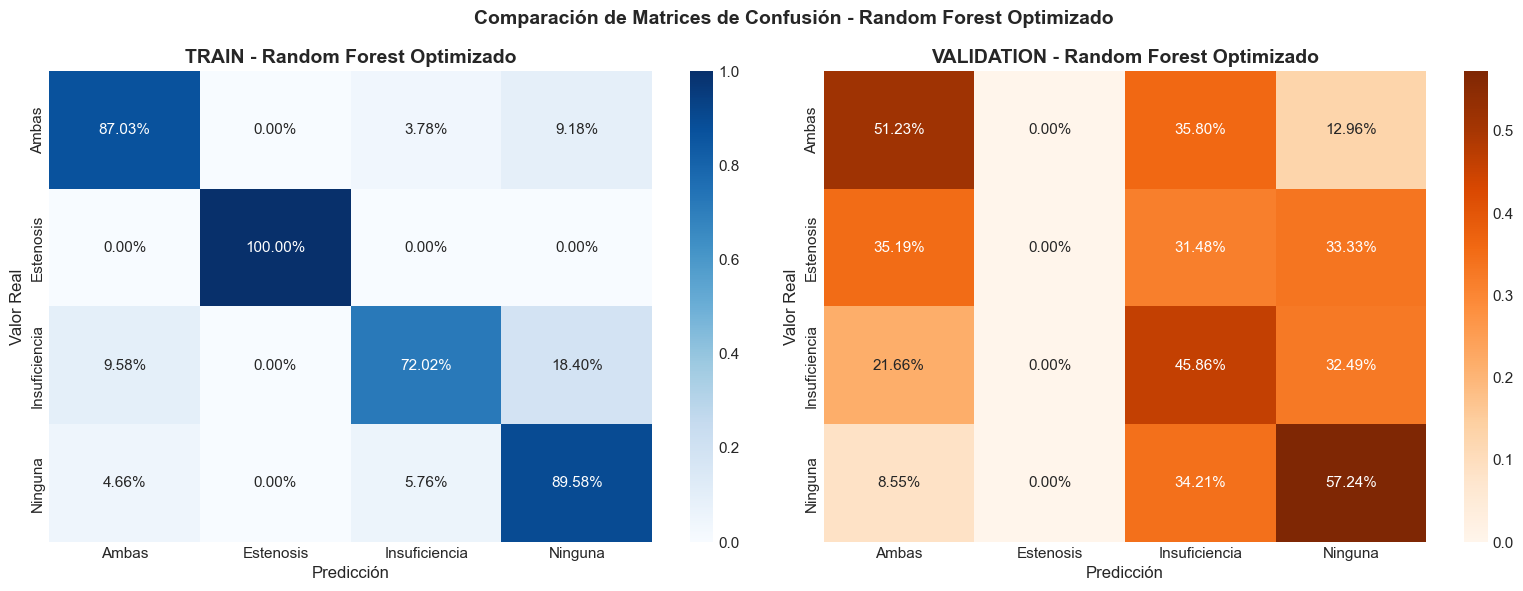

In [86]:
# Muestro las matrices de confusión TRAIN vs VALIDATION
plot_confusion_matrix_comparison(
    rf_opt['metrics_train']['confusion_matrix'],
    rf_opt['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "Random Forest Optimizado"
)

### XGBoost

In [87]:
# Procedo a optimizar Random Forest
xgb_opt = optimize_model(
    'XGBoost',
    SEARCH_SPACES['XGBoost'],
    X_train, y_train, X_val, y_val,
    cv_strategy, CLASS_WEIGHTS, N_TRIALS_OPTUNA
)

print(f"Mejores hiperparámetros (XGBoost):")
for param, value in xgb_opt['best_params'].items():
    print(f"{param}: {value}")

[2026-01-11 18:28:57] Entrenando modelo XGBoost.
[2026-01-11 18:28:57] Iniciando optimización de XGBoost (50 trials)...
[2026-01-11 18:28:57] XGBoost optimizado en 0.6s
Mejor F1-Score (CV): 0.0000
[2026-01-11 18:29:09] Entrenamiento finalizado para XGBoost.
[2026-01-11 18:29:09] Evaluando XGBoost con 5-Fold CV...
[2026-01-11 18:29:59] Ejecutada validación cruzada para XGBoost.
Mejores hiperparámetros (XGBoost):
n_estimators: 407
max_depth: 7
learning_rate: 0.13682714533110604
subsample: 0.9728519019177034
colsample_bytree: 0.7117904177067402
reg_alpha: 0.14365126073130094
reg_lambda: 0.0007934184709126453
min_child_weight: 5


In [88]:
# Muestro las métricas
show_metrics(xgb_opt['metrics_train'], "XGBOOST OPTIMIZADO - TRAIN")
show_metrics(xgb_opt['metrics_val'], "XGBOOST OPTIMIZADO - VALIDATION")
show_crossvalidation_results(xgb_opt['cv_results'])

XGBOOST OPTIMIZADO - TRAIN
Métricas globales:
Accuracy:                 0.9371
Balanced Accuracy:        0.9738
Macro F1-Score:           0.9459
Weighted F1-Score:        0.9385
AUC-ROC (macro):          0.9977
Log-Loss:                 0.3715
Brier Score (macro):      0.0447
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.8937     0.9961     0.9421     0.9989     0.9928       8538
Estenosis           0.9975     1.0000     0.9987     1.0000     1.0000       1185
Insuficiencia       0.9976     0.9068     0.9501     0.9970     0.9985      43006
Ninguna             0.8114     0.9924     0.8928     0.9951     0.9822      13149
XGBOOST OPTIMIZADO - VALIDATION
Métricas globales:
Accuracy:                 0.5261
Balanced Accuracy:        0.3617
Macro F1-Score:           0.3527
Weighted F1-Score:        0.5237
AUC-ROC (macro):          0.6528
Log-Loss:                 1.0280
Brier Score (macro):      0.1479
Métricas po

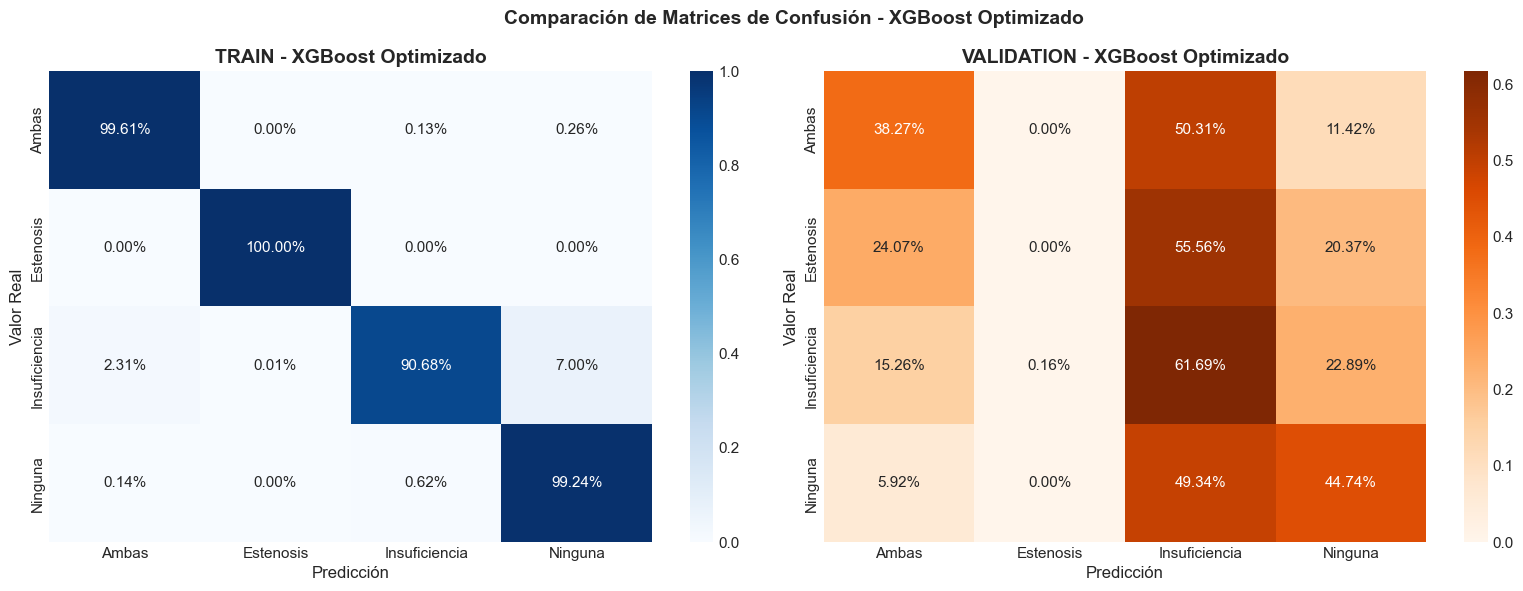

In [89]:
# Muestro las matrices de confusión TRAIN vs VALIDATION
plot_confusion_matrix_comparison(
    xgb_opt['metrics_train']['confusion_matrix'],
    xgb_opt['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "XGBoost Optimizado"
)

### CatBoost

In [90]:
# Procedo a optimizar Random Forest
cat_opt = optimize_model(
    'CatBoost',
    SEARCH_SPACES['CatBoost'],
    X_train, y_train, X_val, y_val,
    cv_strategy, CLASS_WEIGHTS, N_TRIALS_OPTUNA,
    cat_features=CATEGORICAL_INDEXES
)

print(f"Mejores hiperparámetros (CatBoost):")
for param, value in cat_opt['best_params'].items():
    print(f"{param}: {value}")

[2026-01-11 18:30:00] Entrenando modelo CatBoost.
[2026-01-11 18:30:00] Iniciando optimización de CatBoost (50 trials)...
[2026-01-11 18:30:01] CatBoost optimizado en 0.5s
Mejor F1-Score (CV): 0.0000
[2026-01-11 18:30:41] Entrenamiento finalizado para CatBoost.
[2026-01-11 18:30:41] Evaluando CatBoost con 5-Fold CV...
[2026-01-11 18:32:07] Ejecutada validación cruzada para CatBoost.
Mejores hiperparámetros (CatBoost):
iterations: 407
depth: 7
learning_rate: 0.13682714533110604
l2_leaf_reg: 9.389167793148328
border_count: 94
bagging_temperature: 0.7952566046508542


In [91]:
# Muestro las métricas
show_metrics(cat_opt['metrics_train'], "CATBOOST OPTIMIZADO - TRAIN")
show_metrics(cat_opt['metrics_val'], "CATBOOST OPTIMIZADO - VALIDATION")
show_crossvalidation_results(cat_opt['cv_results'])

CATBOOST OPTIMIZADO - TRAIN
Métricas globales:
Accuracy:                 0.6009
Balanced Accuracy:        0.7652
Macro F1-Score:           0.6124
Weighted F1-Score:        0.6126
AUC-ROC (macro):          0.8778
Log-Loss:                 0.9010
Brier Score (macro):      0.1297
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.4138     0.7864     0.5423     0.8846     0.5799       8538
Estenosis           0.5494     1.0000     0.7092     1.0000     0.9978       1185
Insuficiencia       0.8922     0.4999     0.6408     0.7976     0.8798      43006
Ninguna             0.4353     0.7747     0.5574     0.8291     0.5631      13149
CATBOOST OPTIMIZADO - VALIDATION
Métricas globales:
Accuracy:                 0.4262
Balanced Accuracy:        0.4037
Macro F1-Score:           0.3454
Weighted F1-Score:        0.4301
AUC-ROC (macro):          0.6684
Log-Loss:                 1.1333
Brier Score (macro):      0.1629
Métricas 

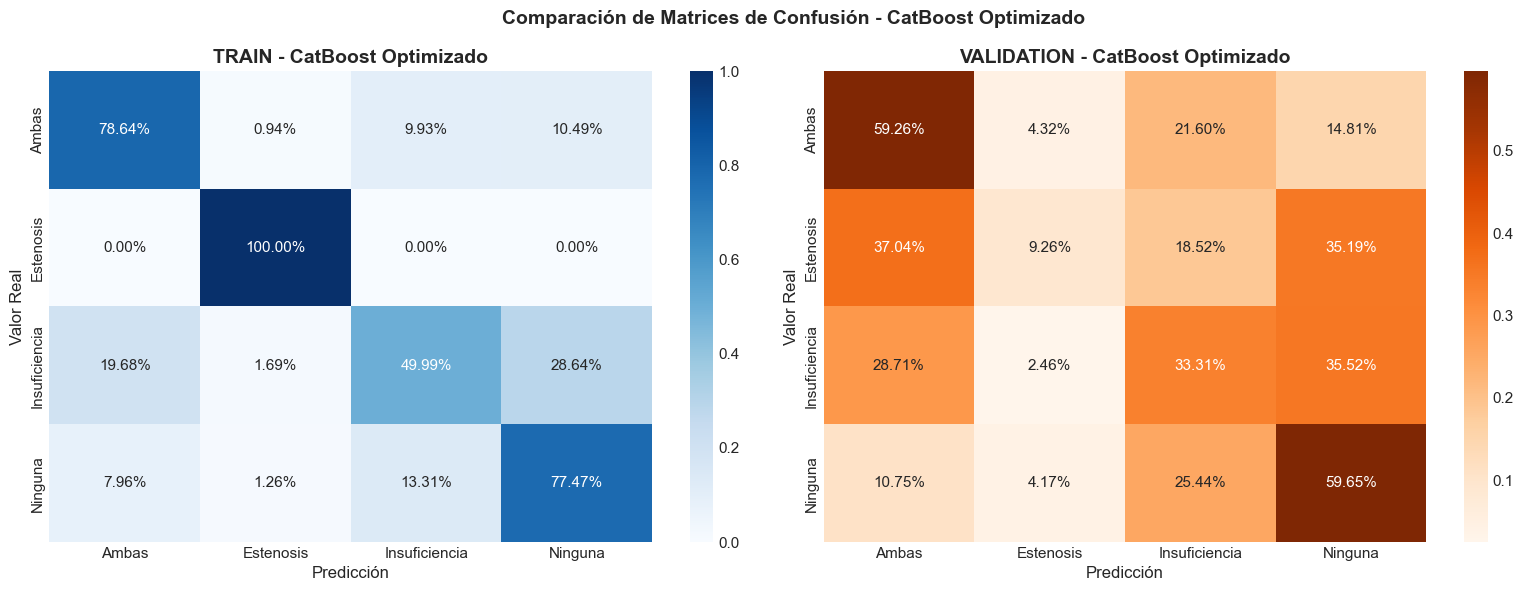

In [92]:
# Muestro las matrices de confusión TRAIN vs VALIDATION
plot_confusion_matrix_comparison(
    cat_opt['metrics_train']['confusion_matrix'],
    cat_opt['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "CatBoost Optimizado"
)

### LightGBM

In [93]:
# Procedo a optimizar Random Forest
lgbm_opt = optimize_model(
    'LightGBM',
    SEARCH_SPACES['LightGBM'],
    X_train, y_train, X_val, y_val,
    cv_strategy, CLASS_WEIGHTS, N_TRIALS_OPTUNA
)

print(f"Mejores hiperparámetros (LightGBM):")
for param, value in lgbm_opt['best_params'].items():
    print(f"{param}: {value}")

[2026-01-11 18:32:08] Entrenando modelo LightGBM.
[2026-01-11 18:32:08] Iniciando optimización de LightGBM (50 trials)...
[2026-01-11 18:32:09] LightGBM optimizado en 0.7s
Mejor F1-Score (CV): 0.0000
[2026-01-11 18:32:15] Entrenamiento finalizado para LightGBM.
[2026-01-11 18:32:15] Evaluando LightGBM con 5-Fold CV...
[2026-01-11 18:33:04] Ejecutada validación cruzada para LightGBM.
Mejores hiperparámetros (LightGBM):
n_estimators: 407
num_leaves: 77
max_depth: 16
learning_rate: 0.2381599184688302
feature_fraction: 0.7117904177067402
bagging_fraction: 0.9181026418603417
bagging_freq: 4
min_child_samples: 52


In [94]:
# Muestro las métricas
show_metrics(lgbm_opt['metrics_train'], "LIGHTGBM OPTIMIZADO - TRAIN")
show_metrics(lgbm_opt['metrics_val'], "LIGHTGBM OPTIMIZADO - VALIDATION")
show_crossvalidation_results(lgbm_opt['cv_results'])

LIGHTGBM OPTIMIZADO - TRAIN
Métricas globales:
Accuracy:                 1.0000
Balanced Accuracy:        1.0000
Macro F1-Score:           1.0000
Weighted F1-Score:        1.0000
AUC-ROC (macro):          1.0000
Log-Loss:                 0.0652
Brier Score (macro):      0.0029
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               1.0000     1.0000     1.0000     1.0000     1.0000       8538
Estenosis           1.0000     1.0000     1.0000     1.0000     1.0000       1185
Insuficiencia       1.0000     1.0000     1.0000     1.0000     1.0000      43006
Ninguna             0.9998     1.0000     0.9999     1.0000     1.0000      13149
LIGHTGBM OPTIMIZADO - VALIDATION
Métricas globales:
Accuracy:                 0.5772
Balanced Accuracy:        0.3317
Macro F1-Score:           0.3377
Weighted F1-Score:        0.5405
AUC-ROC (macro):          0.6348
Log-Loss:                 1.3141
Brier Score (macro):      0.1521
Métricas 

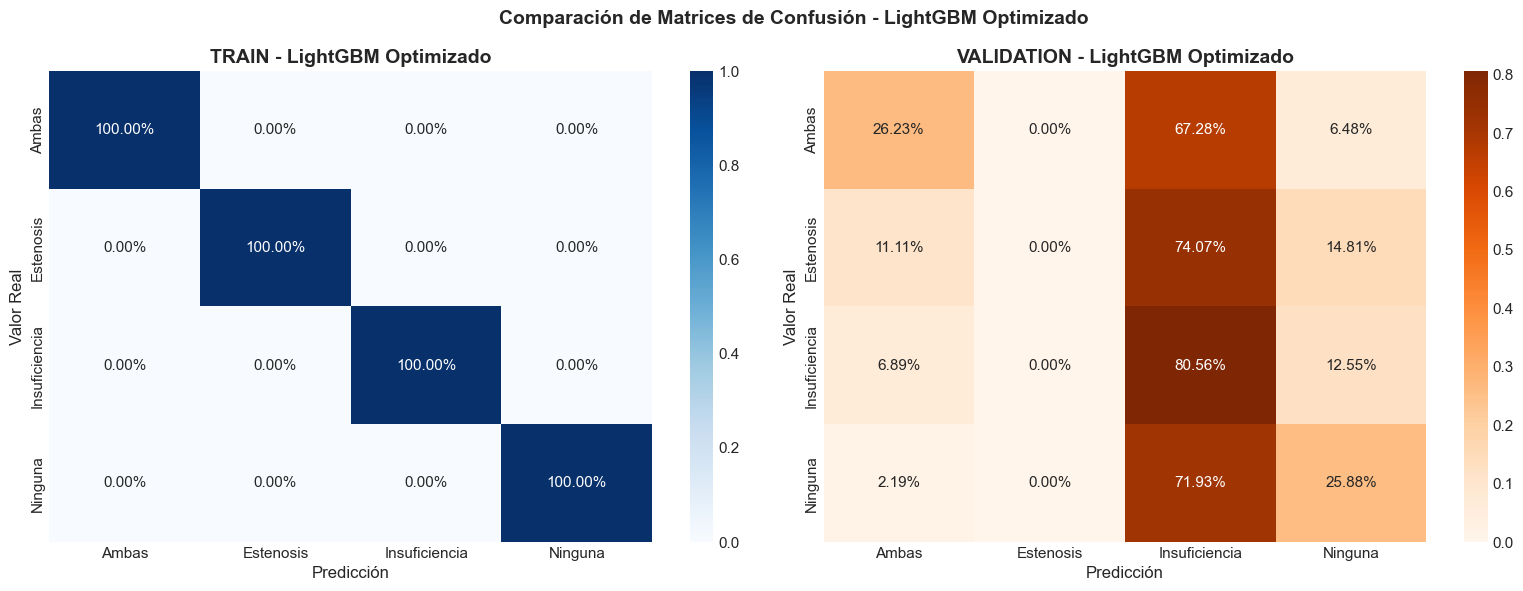

In [95]:
# Muestro las matrices de confusión TRAIN vs VALIDATION
plot_confusion_matrix_comparison(
    lgbm_opt['metrics_train']['confusion_matrix'],
    lgbm_opt['metrics_val']['confusion_matrix'],
    [CLASS_NAMES[i] for i in range(N_CLASSES)],
    "LightGBM Optimizado"
)

### Guardar los modelos optimizados

In [96]:
# Recopilo los resultados
all_results_opt = [rf_opt, xgb_opt, cat_opt, lgbm_opt]

# Guardo todos los modelos
for r in all_results_opt:
    name = r['name'].lower().replace(' ', '_')
    save_metrics = {
        'train': {k: v for k, v in r['metrics_train'].items() if k != 'confusion_matrix' and k != 'by_class'},
        'validation': {k: v for k, v in r['metrics_val'].items() if k != 'confusion_matrix' and k != 'by_class'},
        'by_class_val': r['metrics_val']['by_class'],
        'cv_score': r['best_cv_score']
    }

    params = r['model'].get_params() if hasattr(r['model'], 'get_params') else {}
    save_model(r['model'], name, save_metrics, params)

[2026-01-11 18:33:08] Modelo guardado: randomforest
[2026-01-11 18:33:08] Modelo guardado: xgboost
[2026-01-11 18:33:08] Modelo guardado: catboost
[2026-01-11 18:33:08] Modelo guardado: lightgbm


### Estudio de resultados

#### Comparación de los modelos optimizados

In [97]:
# Creo un dataFrame comparativo
comparation = []

for r in all_results_opt:
    m = r['metrics_val']
    comparation.append({
        'Model': r['name'],
        'Accuracy': m['accuracy'],
        'Balanced Acc': m['balanced_accuracy'],
        'Macro F1': m['f1_macro'],
        'AUC-ROC': m['auc_roc_macro'],
        'Log-Loss': m['log_loss'],
        'Brier Score': m['brier_score_macro'],
        'CV Score': r['best_cv_score'],
        'Time in segs': r['opt_time']
    })

df_comparation = pd.DataFrame(comparation)

print(f"COMPARACIÓN DE MODELOS OPTIMIZADOS (VALIDATION)")
print(df_comparation.to_string(index=False, float_format='{:.4f}'.format))

# Guardo el resultado de la comparación
df_comparation.to_csv(os.path.join(RESULTS_PATH, 'TFG-Modelado_comparacion_optimizados.csv'), index=False)

COMPARACIÓN DE MODELOS OPTIMIZADOS (VALIDATION)
       Model  Accuracy  Balanced Acc  Macro F1  AUC-ROC  Log-Loss  Brier Score  CV Score  Time in segs
RandomForest    0.4803        0.3858    0.3487   0.6537    1.0895       0.1538    0.0000        0.3599
     XGBoost    0.5261        0.3617    0.3527   0.6528    1.0280       0.1479    0.0000        0.5564
    CatBoost    0.4262        0.4037    0.3454   0.6684    1.1333       0.1629    0.0000        0.5271
    LightGBM    0.5772        0.3317    0.3377   0.6348    1.3141       0.1521    0.0000        0.6667


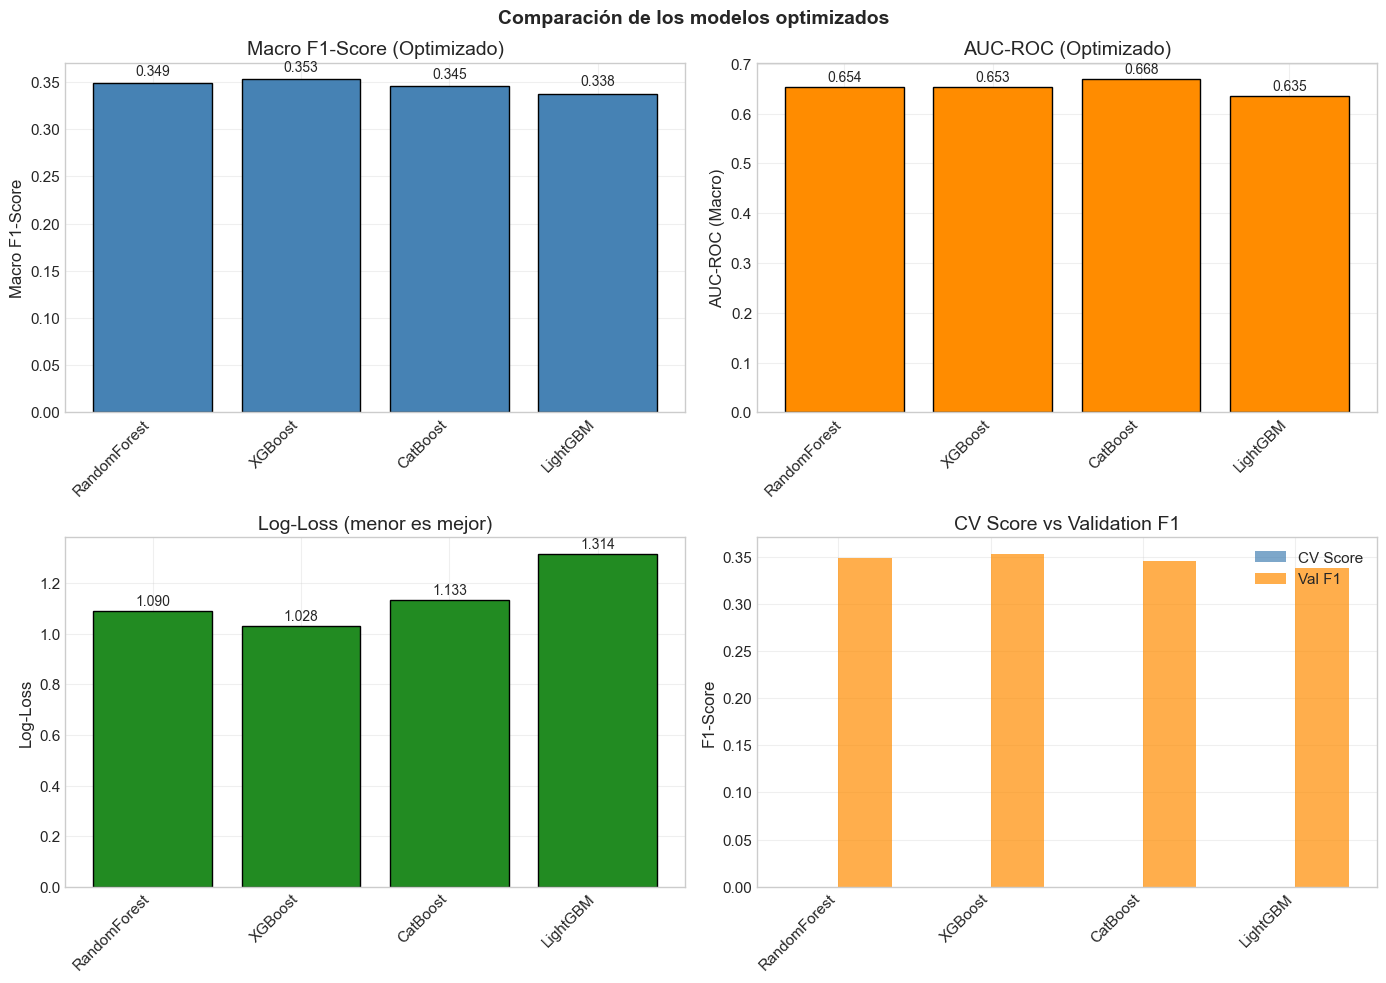

In [98]:
# Preparo los gráficos para hacer una visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = df_comparation['Model'].tolist()
x = range(len(models))

# Macro F1
ax1 = axes[0, 0]
bars1 = ax1.bar(x, df_comparation['Macro F1'], color='steelblue', edgecolor='black')
ax1.set_ylabel('Macro F1-Score')
ax1.set_title('Macro F1-Score (Optimizado)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
for bar, val in zip(bars1, df_comparation['Macro F1']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}',
             ha='center', va='bottom', fontsize=10)

# AUC-ROC
ax2 = axes[0, 1]
bars2 = ax2.bar(x, df_comparation['AUC-ROC'], color='darkorange', edgecolor='black')
ax2.set_ylabel('AUC-ROC (Macro)')
ax2.set_title('AUC-ROC (Optimizado)')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars2, df_comparation['AUC-ROC']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}',
             ha='center', va='bottom', fontsize=10)

# Log-Loss
ax3 = axes[1, 0]
bars3 = ax3.bar(x, df_comparation['Log-Loss'], color='forestgreen', edgecolor='black')
ax3.set_ylabel('Log-Loss')
ax3.set_title('Log-Loss (menor es mejor)')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.grid(True, alpha=0.3)
for bar, val in zip(bars3, df_comparation['Log-Loss']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}',
             ha='center', va='bottom', fontsize=10)

# CV Score vs Validation
ax4 = axes[1, 1]
width = 0.35
ax4.bar([i - width/2 for i in x], df_comparation['CV Score'], width, label='CV Score', color='steelblue', alpha=0.7)
ax4.bar([i + width/2 for i in x], df_comparation['Macro F1'], width, label='Val F1', color='darkorange', alpha=0.7)
ax4.set_ylabel('F1-Score')
ax4.set_title('CV Score vs Validation F1')
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Comparación de los modelos optimizados', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

#### Análisis de sensibilidad por clase
Se ejecuta el análisis de sensibilidad.

In [99]:
recall_analysis(all_results_opt)

ANÁLISIS DE SENSIBILIDAD POR CLASE (VALIDATION)
Sensibilidad (Recall) por clase:
       Model  Ambas  Estenosis  Insuficiencia  Ninguna
RandomForest 0.5123     0.0000         0.4586   0.5724
     XGBoost 0.3827     0.0000         0.6169   0.4474
    CatBoost 0.5926     0.0926         0.3331   0.5965
    LightGBM 0.2623     0.0000         0.8056   0.2588
Valores de referencia orientativos:
Ambas: 75%  ->  Patología combinada que requiere una buena detección
Estenosis: 70%  ->  Clase muy minoritaria (1.8%) por lo que es esperable una menor sensibilidad
Insuficiencia: 80%  ->  Clase mayoritaria (65%) lo que predispone una mayor facilidad de detección
Ninguna: 70%  ->  Detectar la ausencia de patología para evitar el sobrediagnóstico
OBSERVACIONES:
RandomForest: Sensibilidad inferior al valor orientativo en: Ambas (51.2%, ref: 75%), Estenosis (0.0%, ref: 70%), Insuficiencia (45.9%, ref: 80%), Ninguna (57.2%, ref: 70%)
XGBoost: Sensibilidad inferior al valor orientativo en: Ambas (38.3%, re

In [100]:
# Análisis de generalización (Gap Train-Val)
print(f"ANÁLISIS DE GENERALIZACIÓN (GAP TRAIN - VALIDATION)")

gap_data = []
for r in all_results_opt:
    gap_f1 = r['metrics_train']['f1_macro'] - r['metrics_val']['f1_macro']
    gap_ll = r['metrics_val']['log_loss'] - r['metrics_train']['log_loss']

    # Clasificación descriptiva (sin juicios de cumple/no cumple)
    if gap_f1 < REFERENCE_VALUES['gap_train_val']['good']:
        level = "Bueno"
    elif gap_f1 < REFERENCE_VALUES['gap_train_val']['moderate']:
        level = "Moderado"
    else:
        level = "Alto"

    gap_data.append({
        'Model': r['name'],
        'F1 Train': r['metrics_train']['f1_macro'],
        'F1 Val': r['metrics_val']['f1_macro'],
        'Gap F1': gap_f1,
        'Gap F1 (%)': gap_f1 * 100,
        'LogLoss Train': r['metrics_train']['log_loss'],
        'LogLoss Val': r['metrics_val']['log_loss'],
        'Gap LL': gap_ll,
        'Level Gap': level
    })

df_gap = pd.DataFrame(gap_data)
print(df_gap[['Model', 'F1 Train', 'F1 Val', 'Gap F1 (%)', 'Level Gap']].to_string(index=False, float_format='{:.2f}'.format))

print(f"Referencia de niveles:")
print(f"Bueno: Gap < {REFERENCE_VALUES['gap_train_val']['good']*100:.0f}%")
print(f"Moderado: Gap < {REFERENCE_VALUES['gap_train_val']['moderate']*100:.0f}%")
print(f"Alto: Gap >= {REFERENCE_VALUES['gap_train_val']['alarm']*100:.0f}%")

# Guardo los resultados
df_gap.to_csv(os.path.join(RESULTS_PATH, 'TFG-Modelado_gap_analysis.csv'), index=False)

ANÁLISIS DE GENERALIZACIÓN (GAP TRAIN - VALIDATION)
       Model  F1 Train  F1 Val  Gap F1 (%) Level Gap
RandomForest      0.81    0.35       46.22      Alto
     XGBoost      0.95    0.35       59.32      Alto
    CatBoost      0.61    0.35       26.70      Alto
    LightGBM      1.00    0.34       66.23      Alto
Referencia de niveles:
Bueno: Gap < 5%
Moderado: Gap < 10%
Alto: Gap >= 15%


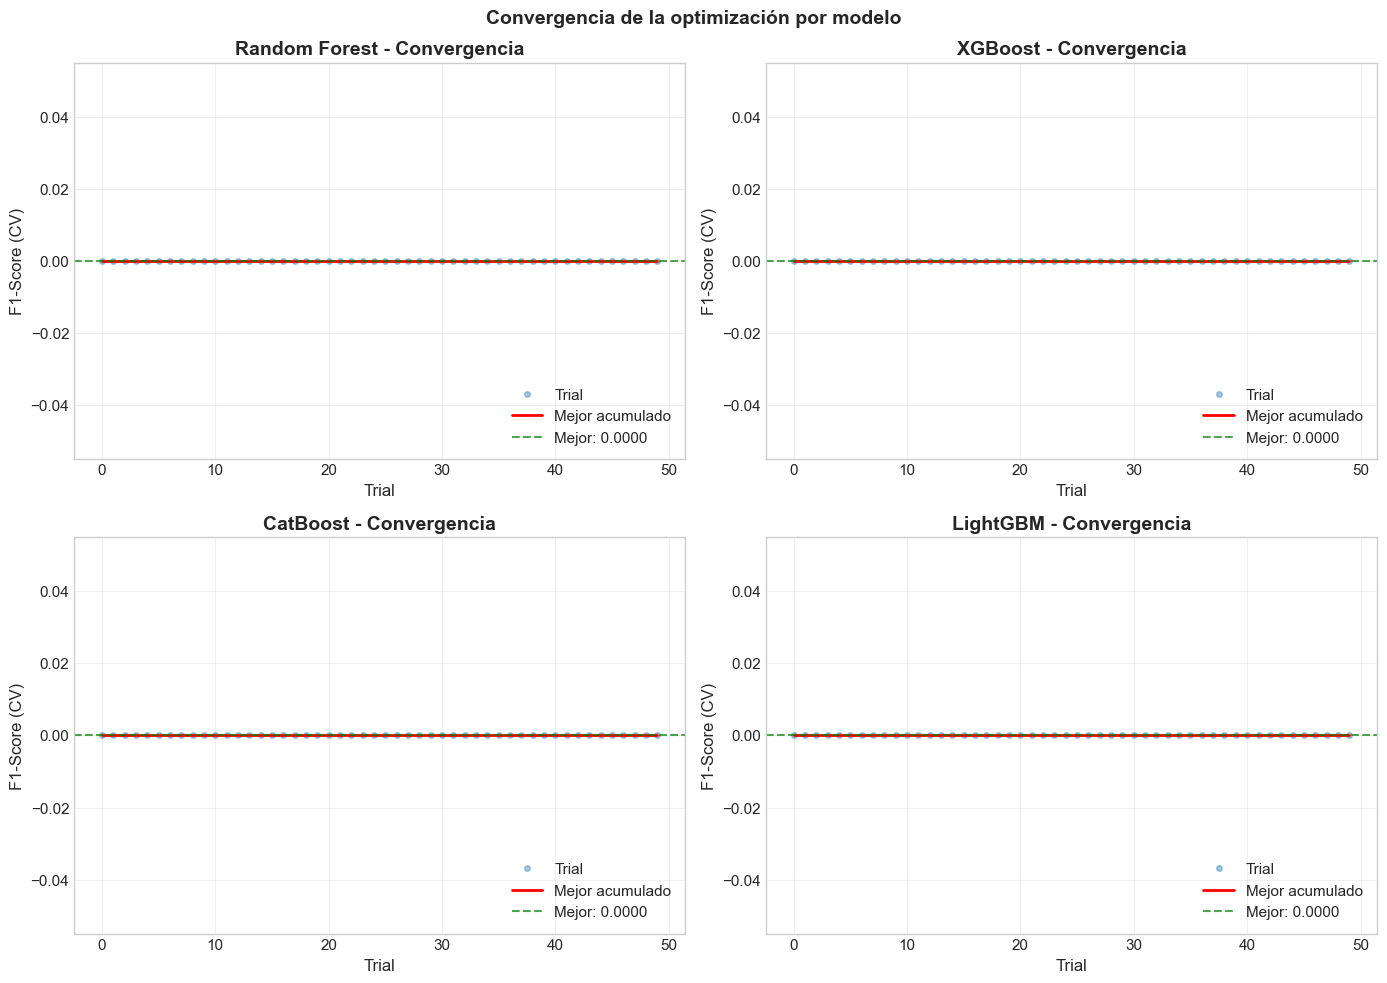

In [101]:
# Muestro el gráfico de convergencia de la optimización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

studies = [
    (rf_opt, 'Random Forest'),
    (xgb_opt, 'XGBoost'),
    (cat_opt, 'CatBoost'),
    (lgbm_opt, 'LightGBM')
]

for idx, (result, name) in enumerate(studies):
    ax = axes[idx // 2, idx % 2]
    study = result['study']

    # Obtengo el historial de los valores
    trials = study.trials
    trial_numbers = [t.number for t in trials]
    values = [t.value if t.value is not None else 0 for t in trials]
    best_values = np.maximum.accumulate(values)

    ax.plot(trial_numbers, values, 'o', alpha=0.4, markersize=4, label='Trial')
    ax.plot(trial_numbers, best_values, '-', linewidth=2, color='red', label='Mejor acumulado')
    ax.axhline(y=study.best_value, linestyle='--', color='green', alpha=0.7, label=f'Mejor: {study.best_value:.4f}')

    ax.set_xlabel('Trial')
    ax.set_ylabel('F1-Score (CV)')
    ax.set_title(f'{name} - Convergencia', fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Convergencia de la optimización por modelo', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

### Resumen de la optimización de hiperparámetros

In [102]:
print(f"RESUMEN DEL ENTRENAMIENTO DE MODELOS ENSEMBLE")

print(f"MODELOS ENTRENADOS:")
for r in all_results_opt:
    m = r['metrics_val']
    gap = r['metrics_train']['f1_macro'] - m['f1_macro']
    print(f"{r['name']}:")
    print(f"Macro F1 (Val): {m['f1_macro']:.4f}")
    print(f"AUC-ROC (Val): {m['auc_roc_macro']:.4f}")
    print(f"Log-Loss (Val): {m['log_loss']:.4f}")
    print(f"Gap Train-Val: {gap:.4f} ({gap*100:.1f}%)")
    print(f"Tiempo (s): {r['opt_time']:.2f}s")

# Mejor modelo por métrica
print(f"MEJOR MODELO POR MÉTRICA (Parámetros por defecto):")
best_f1 = df_comparation.loc[df_comparation['Macro F1'].idxmax()]
best_auc = df_comparation.loc[df_comparation['AUC-ROC'].idxmax()]
best_ll = df_comparation.loc[df_comparation['Log-Loss'].idxmin()]

print(f"Macro F1-Score: {best_f1['Model']} ({best_f1['Macro F1']:.4f})")
print(f"AUC-ROC: {best_auc['Model']} ({best_auc['AUC-ROC']:.4f})")
print(f"Log-Loss: {best_ll['Model']} ({best_ll['Log-Loss']:.4f})")

RESUMEN DEL ENTRENAMIENTO DE MODELOS ENSEMBLE
MODELOS ENTRENADOS:
RandomForest:
Macro F1 (Val): 0.3487
AUC-ROC (Val): 0.6537
Log-Loss (Val): 1.0895
Gap Train-Val: 0.4622 (46.2%)
Tiempo (s): 0.36s
XGBoost:
Macro F1 (Val): 0.3527
AUC-ROC (Val): 0.6528
Log-Loss (Val): 1.0280
Gap Train-Val: 0.5932 (59.3%)
Tiempo (s): 0.56s
CatBoost:
Macro F1 (Val): 0.3454
AUC-ROC (Val): 0.6684
Log-Loss (Val): 1.1333
Gap Train-Val: 0.2670 (26.7%)
Tiempo (s): 0.53s
LightGBM:
Macro F1 (Val): 0.3377
AUC-ROC (Val): 0.6348
Log-Loss (Val): 1.3141
Gap Train-Val: 0.6623 (66.2%)
Tiempo (s): 0.67s
MEJOR MODELO POR MÉTRICA (Parámetros por defecto):
Macro F1-Score: XGBoost (0.3527)
AUC-ROC: CatBoost (0.6684)
Log-Loss: XGBoost (1.0280)


In [103]:
print(f"RESUMEN DE LA OPTIMIZACIÓN DE HIPERPARÁMETROS")

print(f"CONFIGURACIÓN:")
print(f"Trials por modelo: {N_TRIALS_OPTUNA}")
print(f"Optimizador: TPE (Optuna)")
print(f"Métrica objetivo: Macro F1-Score")
print(f"Validación: Stratified {N_SPLITS}-Fold CV")

print(f"RESULTADOS POR MODELO:")
for r in all_results_opt:
    m = r['metrics_val']
    gap = r['metrics_train']['f1_macro'] - m['f1_macro']
    print(f"{r['name']}:")
    print(f"CV Score: {r['best_cv_score']:.4f}")
    print(f"Val F1: {m['f1_macro']:.4f}")
    print(f"Val AUC-ROC: {m['auc_roc_macro']:.4f}")
    print(f"Gap Train-Val: {gap:.4f} ({gap*100:.1f}%)")
    print(f"Tiempo Opt (s): {r['opt_time']:.1f}s")

# Mejor modelo
print(f"MEJOR MODELO:")
mejor_f1 = max(all_results_opt, key=lambda x: x['metrics_val']['f1_macro'])
mejor_auc = max(all_results_opt, key=lambda x: x['metrics_val']['auc_roc_macro'])
mejor_ll = min(all_results_opt, key=lambda x: x['metrics_val']['log_loss'])

print(f"MEJOR MODELO POR MÉTRICA:")
print(f"Macro F1-Score: {mejor_f1['name']} ({mejor_f1['metrics_val']['f1_macro']:.4f})")
print(f"AUC-ROC: {mejor_auc['name']} ({mejor_auc['metrics_val']['auc_roc_macro']:.4f})")
print(f"Log-Loss: {mejor_ll['name']} ({mejor_ll['metrics_val']['log_loss']:.4f})")

RESUMEN DE LA OPTIMIZACIÓN DE HIPERPARÁMETROS
CONFIGURACIÓN:
Trials por modelo: 50
Optimizador: TPE (Optuna)
Métrica objetivo: Macro F1-Score
Validación: Stratified 5-Fold CV
RESULTADOS POR MODELO:
RandomForest:
CV Score: 0.0000
Val F1: 0.3487
Val AUC-ROC: 0.6537
Gap Train-Val: 0.4622 (46.2%)
Tiempo Opt (s): 0.4s
XGBoost:
CV Score: 0.0000
Val F1: 0.3527
Val AUC-ROC: 0.6528
Gap Train-Val: 0.5932 (59.3%)
Tiempo Opt (s): 0.6s
CatBoost:
CV Score: 0.0000
Val F1: 0.3454
Val AUC-ROC: 0.6684
Gap Train-Val: 0.2670 (26.7%)
Tiempo Opt (s): 0.5s
LightGBM:
CV Score: 0.0000
Val F1: 0.3377
Val AUC-ROC: 0.6348
Gap Train-Val: 0.6623 (66.2%)
Tiempo Opt (s): 0.7s
MEJOR MODELO:
MEJOR MODELO POR MÉTRICA:
Macro F1-Score: XGBoost (0.3527)
AUC-ROC: CatBoost (0.6684)
Log-Loss: XGBoost (1.0280)


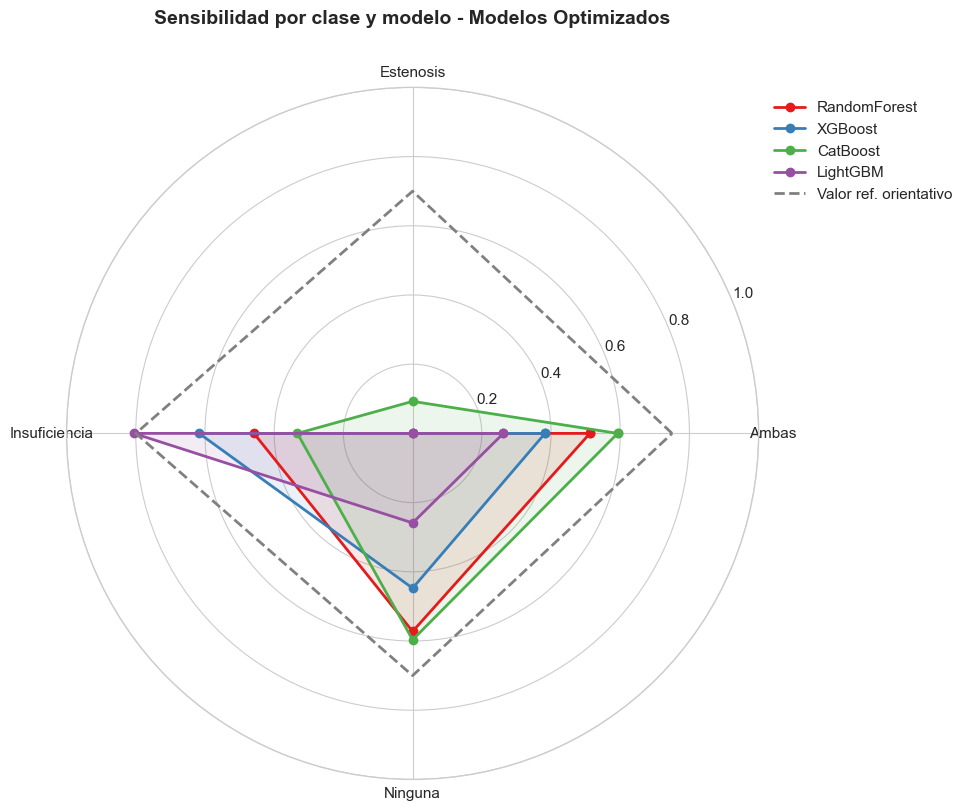

In [104]:
# Creo un gráfico de radar comparativo de sensibilidad por clase
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = list(CLASS_NAMES.values())
n_cats = len(categories)
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]

colors_radar = plt.cm.Set1(range(len(all_results_opt)))

for idx, r in enumerate(all_results_opt):
    values = [r['metrics_val']['by_class'][c]['recall'] for c in categories]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=r['name'], color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.1, color=colors_radar[idx])

# Añado los valores de referencia (línea punteada, no "umbral mínimo")
ref_values = [REFERENCE_VALUES['guideline_sensitivity'][c]['value'] for c in categories]
ref_values += ref_values[:1]
ax.plot(angles, ref_values, '--', linewidth=2, label='Valor ref. orientativo', color='gray')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Sensibilidad por clase y modelo - Modelos Optimizados', fontweight='bold', size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()
plt.close()

### Realizo el estudio en TEST

[2026-01-11 18:33:10] Evaluando RandomForest en TEST...
RandomForest - TEST (CONJUNTO SELLADO)
Métricas globales:
Accuracy:                 0.4872
Balanced Accuracy:        0.3829
Macro F1-Score:           0.3510
Weighted F1-Score:        0.4925
AUC-ROC (macro):          0.6646
Log-Loss:                 1.0779
Brier Score (macro):      0.1525
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.3339     0.4993     0.4002     0.7585     0.3883        731
Estenosis           0.0000     0.0000     0.0000     0.6210     0.0325         94
Insuficiencia       0.6561     0.4695     0.5473     0.5752     0.6468       2833
Ninguna             0.3841     0.5627     0.4565     0.7039     0.4041       1157


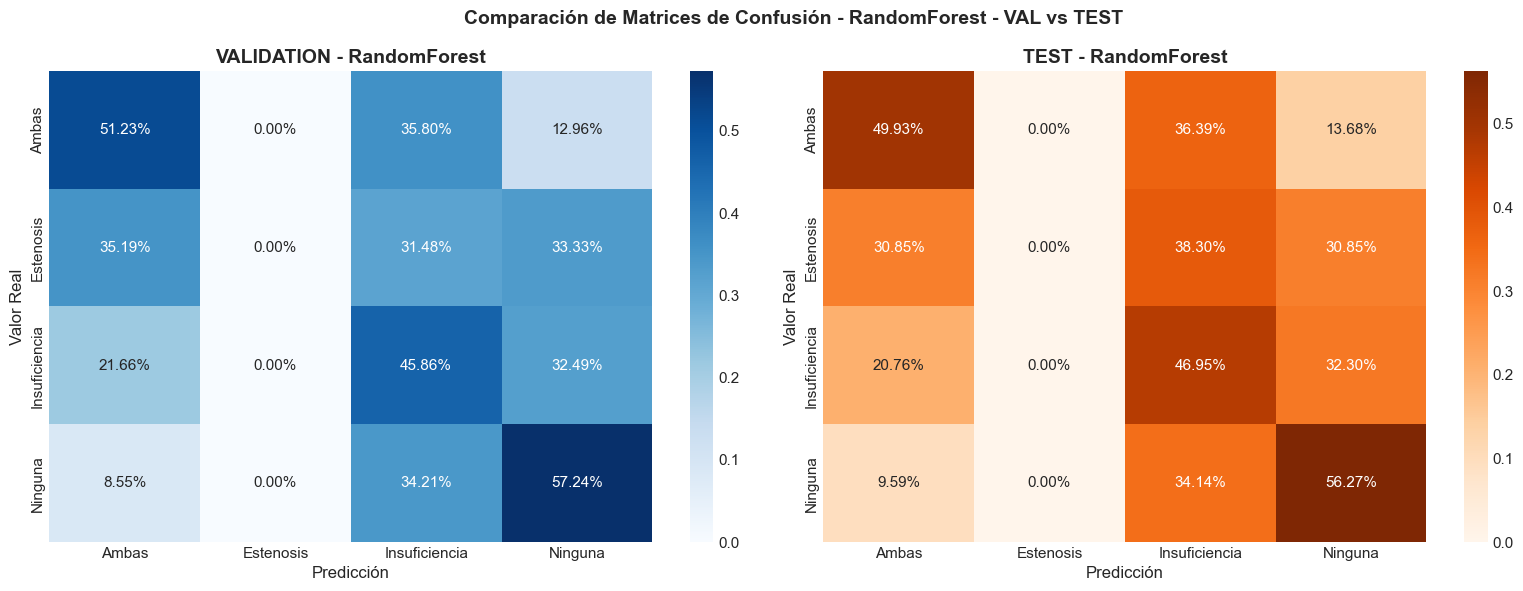

[2026-01-11 18:33:10] Evaluando XGBoost en TEST...
XGBoost - TEST (CONJUNTO SELLADO)
Métricas globales:
Accuracy:                 0.5232
Balanced Accuracy:        0.3618
Macro F1-Score:           0.3551
Weighted F1-Score:        0.5222
AUC-ROC (macro):          0.6456
Log-Loss:                 1.0180
Brier Score (macro):      0.1476
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.3832     0.3995     0.3912     0.7419     0.3878        731
Estenosis           0.0000     0.0000     0.0000     0.5776     0.0279         94
Insuficiencia       0.6335     0.6054     0.6191     0.5722     0.6413       2833
Ninguna             0.3818     0.4425     0.4099     0.6907     0.3871       1157


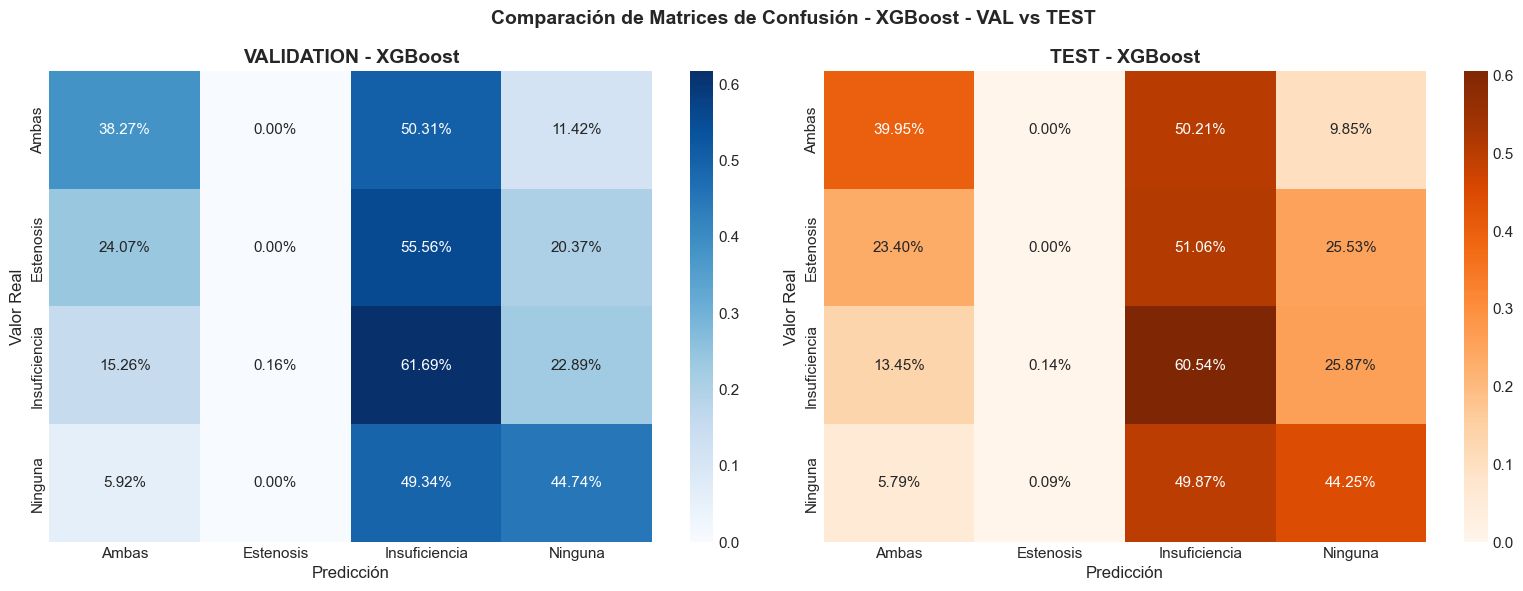

[2026-01-11 18:33:11] Evaluando CatBoost en TEST...
CatBoost - TEST (CONJUNTO SELLADO)
Métricas globales:
Accuracy:                 0.4345
Balanced Accuracy:        0.4002
Macro F1-Score:           0.3445
Weighted F1-Score:        0.4382
AUC-ROC (macro):          0.6563
Log-Loss:                 1.1266
Brier Score (macro):      0.1619
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.3195     0.5814     0.4124     0.7582     0.4058        731
Estenosis           0.0467     0.0745     0.0574     0.5909     0.0288         94
Insuficiencia       0.6671     0.3382     0.4488     0.5761     0.6531       2833
Ninguna             0.3697     0.6067     0.4594     0.6999     0.3937       1157


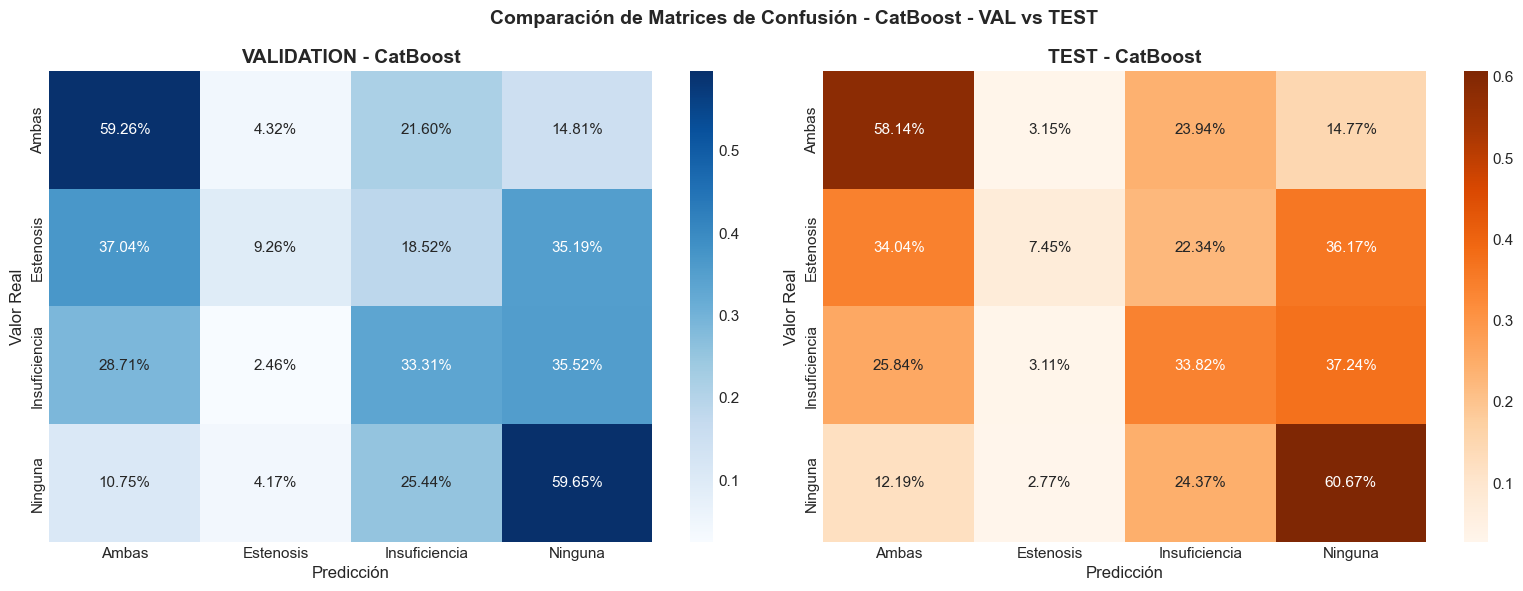

[2026-01-11 18:33:11] Evaluando LightGBM en TEST...
LightGBM - TEST (CONJUNTO SELLADO)
Métricas globales:
Accuracy:                 0.5504
Balanced Accuracy:        0.3173
Macro F1-Score:           0.3219
Weighted F1-Score:        0.5180
AUC-ROC (macro):          0.6265
Log-Loss:                 1.2759
Brier Score (macro):      0.1568
Métricas por clase:
Clase            Precision     Recall         F1    AUC-ROC     AUC-PR    Support
Ambas               0.4215     0.2572     0.3195     0.7169     0.3491        731
Estenosis           0.0000     0.0000     0.0000     0.5736     0.0250         94
Insuficiencia       0.6095     0.7702     0.6805     0.5554     0.6304       2833
Ninguna             0.3549     0.2420     0.2878     0.6601     0.3517       1157


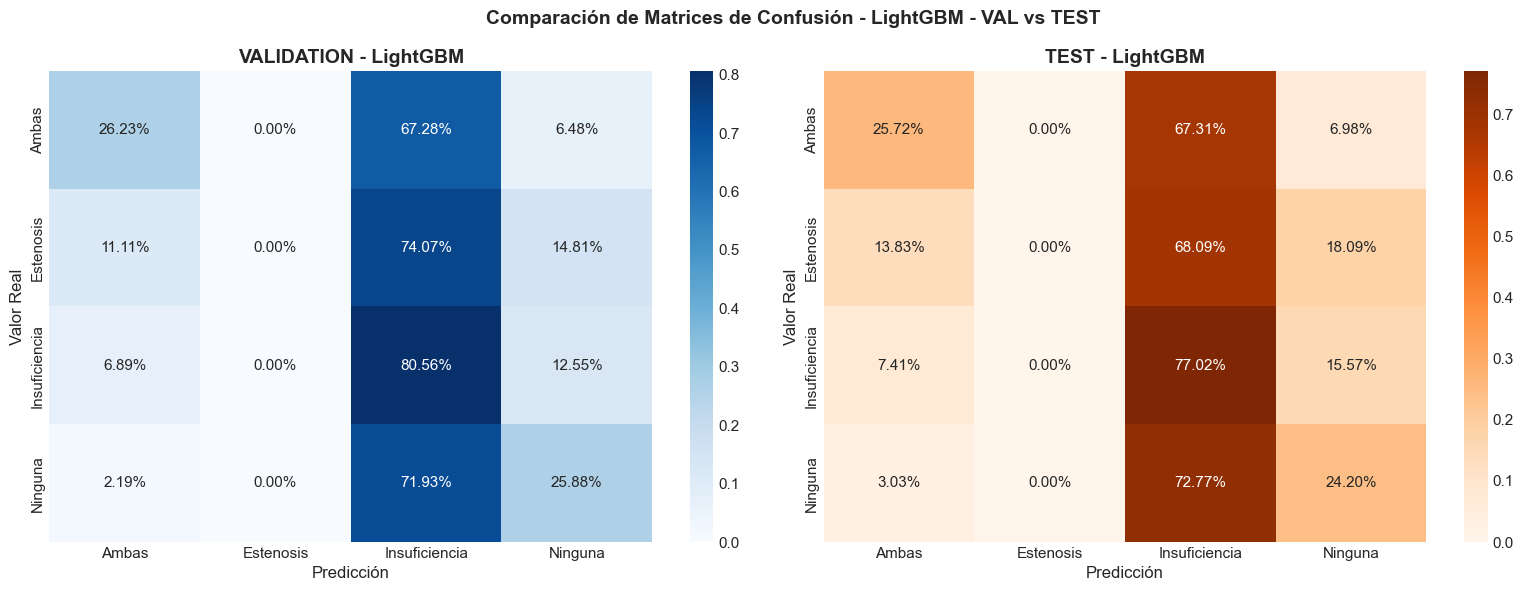

In [105]:
final_results = []

for r in all_results_opt:
    model = r['model']
    name = r['name']
    
    log(f"Evaluando {name} en TEST...")
    
    # Recupero las métricas de CV
    cv_score_mean = r['cv_results'].get('f1_macro_train_mean', np.nan)
    cv_score_std = r['cv_results'].get('f1_macro_train_std', np.nan)
    
    # Recupero las métricas de VALIDATION
    val_f1 = r['metrics_val']['f1_macro']
    val_auc = r['metrics_val']['auc_roc_macro']
    val_recall_macro = r['metrics_val']['recall_macro']
    val_precision_macro = r['metrics_val']['precision_macro']
    
    #  Calculo las métricas en TEST
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)
    
    metrics_test = calculate_all_metrics(y_test.values, y_pred_test, y_proba_test)
    
    # Almacenar todo
    final_results.append({
        'Model': name,
        # CV
        'CV_F1_mean': cv_score_mean,
        'CV_F1_std': cv_score_std,
        # VAL
        'VAL_F1': val_f1,
        'VAL_AUC': val_auc,
        'VAL_Recall': val_recall_macro,
        'VAL_Precision': val_precision_macro,
        # TEST
        'TEST_F1': metrics_test['f1_macro'],
        'TEST_AUC': metrics_test['auc_roc_macro'],
        'TEST_Recall': metrics_test['recall_macro'],
        'TEST_Precision': metrics_test['precision_macro'],
        'TEST_LogLoss': metrics_test['log_loss'],
        # Almacenar métricas completas de TEST
        'metrics_test_full': metrics_test
    })
    
    # Muestro las métricas de TEST
    show_metrics(metrics_test, f"{name} - TEST (CONJUNTO SELLADO)")
    
    # Muestro las matrices de confusión VAL vs TEST
    cm_val = r['metrics_val']['confusion_matrix']
    cm_test = metrics_test['confusion_matrix']
    class_names = [CLASS_NAMES[i] for i in range(N_CLASSES)]
    model_title = name
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalizo
    cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

    # Muestro las matrices de confusión
    # VALIDATION (izquierda)
    sns.heatmap(cm_val_norm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Valor Real')
    axes[0].set_title(f'VALIDATION - {model_title}', fontweight='bold')  # ← Corregido

    # TEST (derecha)
    sns.heatmap(cm_test_norm, annot=True, fmt='.2%', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Valor Real')
    axes[1].set_title(f'TEST - {model_title}', fontweight='bold')  # ← Corregido

    plt.suptitle(f'Comparación de Matrices de Confusión - {model_title} - VAL vs TEST', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close()


In [106]:
# Muestro la tabla comparativa final
print("TABLA COMPARATIVA FINAL - CV / VAL / TEST")
df_final = pd.DataFrame(final_results)

# Preparo el formato para la tabla principal
print("MACRO F1-SCORE:")
print(f"{'Modelo':<15} | {'Train (CV)':<20} | {'Val (hold-out)':<15} | {'Test (hold-out)':<15}")
print("-" * 80)
for _, row in df_final.iterrows():
    cv_str = f"{row['CV_F1_mean']:.4f}±{row['CV_F1_std']:.4f}"
    print(f"{row['Model']:<15} | {cv_str:<20} | {row['VAL_F1']:<15.4f} | {row['TEST_F1']:<15.4f}")

print("AUC-ROC:")
print(f"{'Modelo':<15} | {'Val':<15} | {'Test':<15}")
for _, row in df_final.iterrows():
    print(f"{row['Model']:<15} | {row['VAL_AUC']:<15.4f} | {row['TEST_AUC']:<15.4f}")

print("SENSIBILIDAD (Recall Macro):")
print(f"{'Modelo':<15} | {'Val':<15} | {'Test':<15}")
for _, row in df_final.iterrows():
    print(f"{row['Model']:<15} | {row['VAL_Recall']:<15.4f} | {row['TEST_Recall']:<15.4f}")

# Guardo los resultados
df_final_export = df_final.drop('metrics_test_full', axis=1)
df_final_export.to_csv(
    os.path.join(RESULTS_PATH, 'TFG-Modelado_final_comparison_CV_VAL_TEST.csv'), 
    index=False
)

TABLA COMPARATIVA FINAL - CV / VAL / TEST
MACRO F1-SCORE:
Modelo          | Train (CV)           | Val (hold-out)  | Test (hold-out)
--------------------------------------------------------------------------------
RandomForest    | 0.8267±0.0035        | 0.3487          | 0.3510         
XGBoost         | 0.9758±0.0003        | 0.3527          | 0.3551         
CatBoost        | 0.6453±0.0026        | 0.3454          | 0.3445         
LightGBM        | 1.0000±0.0000        | 0.3377          | 0.3219         
AUC-ROC:
Modelo          | Val             | Test           
RandomForest    | 0.6537          | 0.6646         
XGBoost         | 0.6528          | 0.6456         
CatBoost        | 0.6684          | 0.6563         
LightGBM        | 0.6348          | 0.6265         
SENSIBILIDAD (Recall Macro):
Modelo          | Val             | Test           
RandomForest    | 0.3858          | 0.3829         
XGBoost         | 0.3617          | 0.3618         
CatBoost        | 0.4037        

In [107]:
# Creo el análisis de generalización
print("ANÁLISIS DE GENERALIZACIÓN")

print("GAP CV → VAL:")
for _, row in df_final.iterrows():
    gap_cv_val = row['CV_F1_mean'] - row['VAL_F1']
    print(f"{row['Model']:<15}: {gap_cv_val:+.4f} ({gap_cv_val*100:+.1f}%)")

print("\nGAP VAL → TEST:")
for _, row in df_final.iterrows():
    gap_val_test = row['VAL_F1'] - row['TEST_F1']
    print(f"{row['Model']:<15}: {gap_val_test:+.4f} ({gap_val_test*100:+.1f}%)")

print("\nGAP CV → TEST (total):")
for _, row in df_final.iterrows():
    gap_cv_test = row['CV_F1_mean'] - row['TEST_F1']
    print(f"{row['Model']:<15}: {gap_cv_test:+.4f} ({gap_cv_test*100:+.1f}%)")

ANÁLISIS DE GENERALIZACIÓN
GAP CV → VAL:
RandomForest   : +0.4780 (+47.8%)
XGBoost        : +0.6231 (+62.3%)
CatBoost       : +0.2999 (+30.0%)
LightGBM       : +0.6623 (+66.2%)

GAP VAL → TEST:
RandomForest   : -0.0023 (-0.2%)
XGBoost        : -0.0023 (-0.2%)
CatBoost       : +0.0009 (+0.1%)
LightGBM       : +0.0158 (+1.6%)

GAP CV → TEST (total):
RandomForest   : +0.4757 (+47.6%)
XGBoost        : +0.6207 (+62.1%)
CatBoost       : +0.3008 (+30.1%)
LightGBM       : +0.6781 (+67.8%)


In [108]:
# Creo el análisis de sensibilidad por clase
print("SENSIBILIDAD POR CLASE (TEST)")

for result in final_results:
    print(f"\n{result['Model']}:")
    print(f"{'Clase':<15} | {'Val':<10} | {'Test':<10} | {'Δ':<10}")

    # Obtengo métricas por clase de VAL
    val_by_class = next(r['metrics_val']['by_class'] for r in all_results_opt if r['name'] == result['Model'])
    test_by_class = result['metrics_test_full']['by_class']
    
    for clase in CLASS_NAMES.values():
        val_recall = val_by_class[clase]['recall']
        test_recall = test_by_class[clase]['recall']
        diff = test_recall - val_recall
        
        print(f"{clase:<15} | {val_recall:<10.4f} | {test_recall:<10.4f} | {diff:+.4f}")

SENSIBILIDAD POR CLASE (TEST)

RandomForest:
Clase           | Val        | Test       | Δ         
Ambas           | 0.5123     | 0.4993     | -0.0130
Estenosis       | 0.0000     | 0.0000     | +0.0000
Insuficiencia   | 0.4586     | 0.4695     | +0.0109
Ninguna         | 0.5724     | 0.5627     | -0.0097

XGBoost:
Clase           | Val        | Test       | Δ         
Ambas           | 0.3827     | 0.3995     | +0.0167
Estenosis       | 0.0000     | 0.0000     | +0.0000
Insuficiencia   | 0.6169     | 0.6054     | -0.0115
Ninguna         | 0.4474     | 0.4425     | -0.0048

CatBoost:
Clase           | Val        | Test       | Δ         
Ambas           | 0.5926     | 0.5814     | -0.0112
Estenosis       | 0.0926     | 0.0745     | -0.0181
Insuficiencia   | 0.3331     | 0.3382     | +0.0051
Ninguna         | 0.5965     | 0.6067     | +0.0103

LightGBM:
Clase           | Val        | Test       | Δ         
Ambas           | 0.2623     | 0.2572     | -0.0052
Estenosis       | 0.0000   

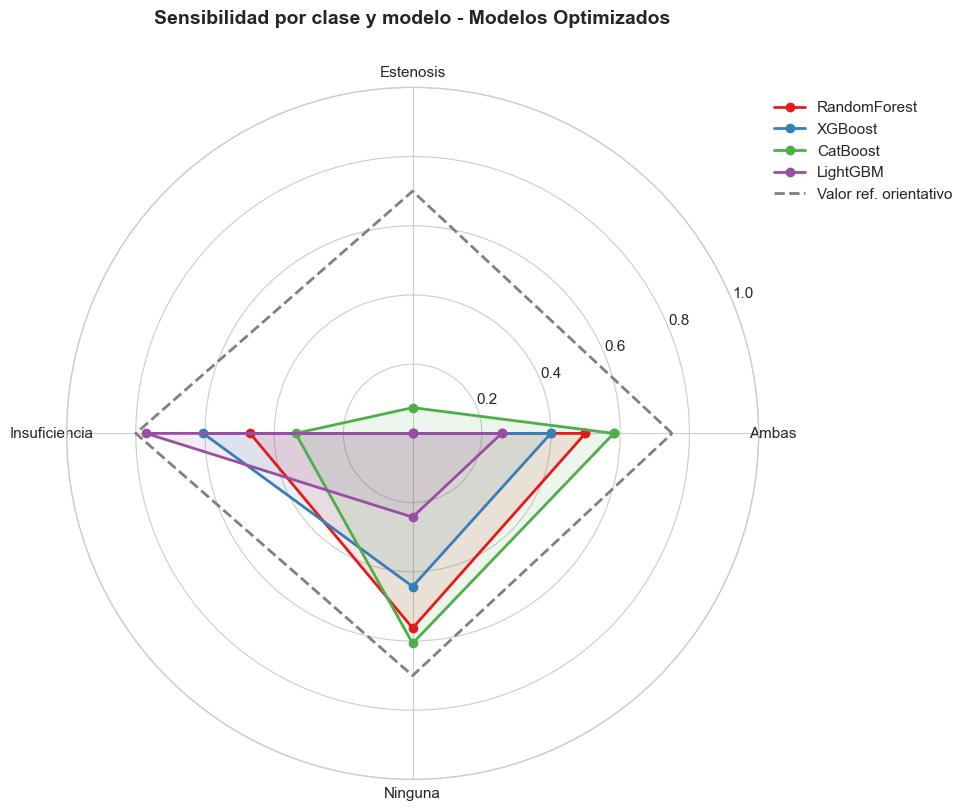

In [109]:
# Creo un gráfico de radar comparativo de sensibilidad por clase
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = list(CLASS_NAMES.values())
n_cats = len(categories)
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]

colors_radar = plt.cm.Set1(range(len(final_results)))

for idx, r in enumerate(final_results):
    values = [r['metrics_test_full']['by_class'][c]['recall'] for c in categories]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=r['Model'], color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.1, color=colors_radar[idx])

# Añado los valores de referencia (línea punteada, no "umbral mínimo")
ref_values = [REFERENCE_VALUES['guideline_sensitivity'][c]['value'] for c in categories]
ref_values += ref_values[:1]
ax.plot(angles, ref_values, '--', linewidth=2, label='Valor ref. orientativo', color='gray')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Sensibilidad por clase y modelo - Modelos Optimizados', fontweight='bold', size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()
plt.close()

--- ANÁLISIS DE COHERENCIA (SANITY CHECK) ---


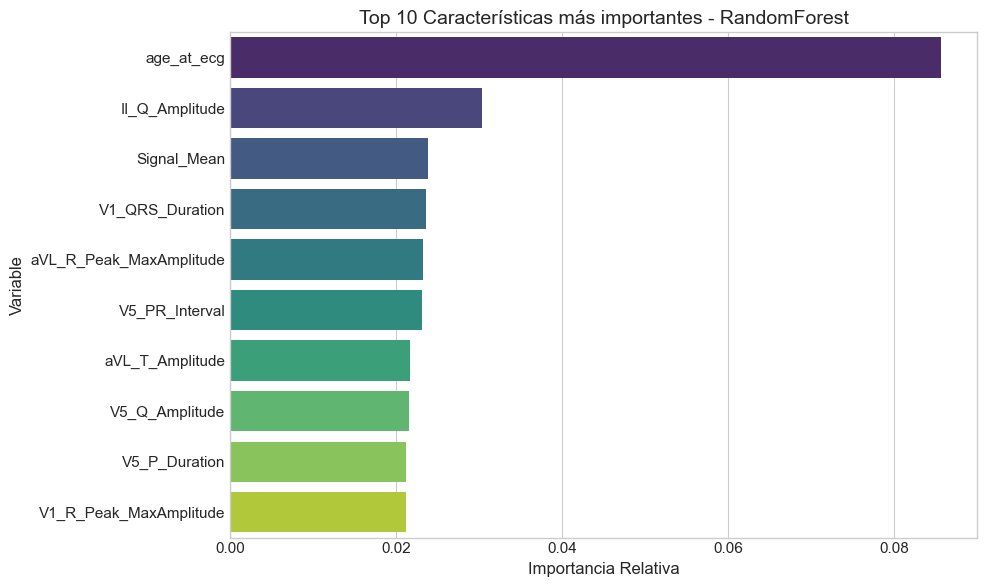

Top 5 variables para LightGBM: ['age_at_ecg', 'II_Q_Amplitude', 'Signal_Mean', 'V1_QRS_Duration', 'aVL_R_Peak_MaxAmplitude']


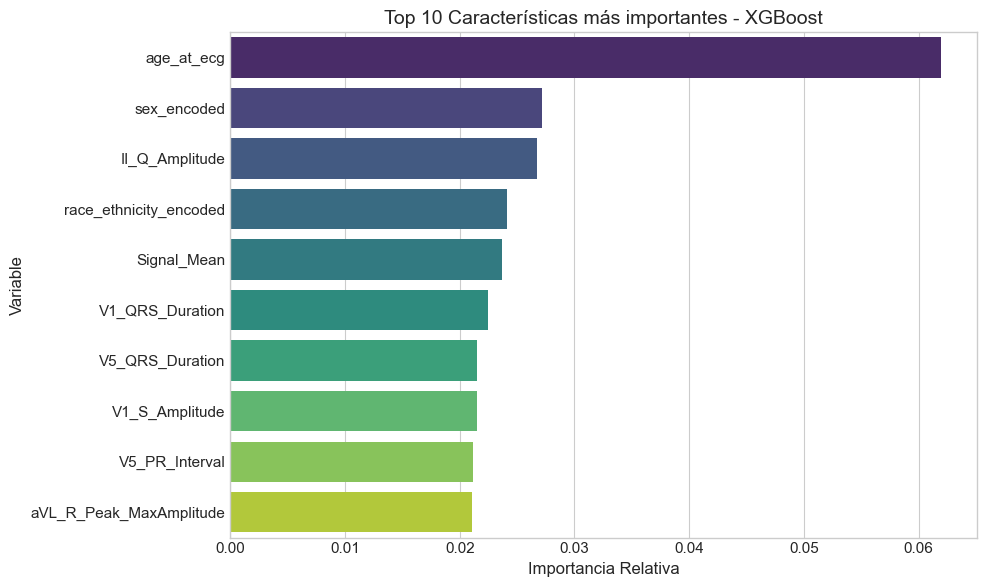

Top 5 variables para LightGBM: ['age_at_ecg', 'sex_encoded', 'II_Q_Amplitude', 'race_ethnicity_encoded', 'Signal_Mean']


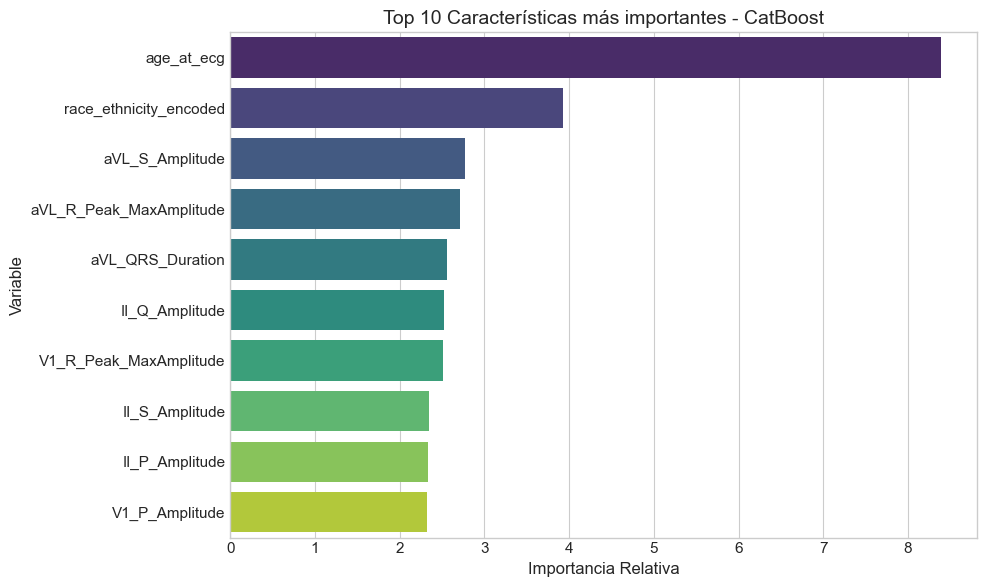

Top 5 variables para LightGBM: ['age_at_ecg', 'race_ethnicity_encoded', 'aVL_S_Amplitude', 'aVL_R_Peak_MaxAmplitude', 'aVL_QRS_Duration']


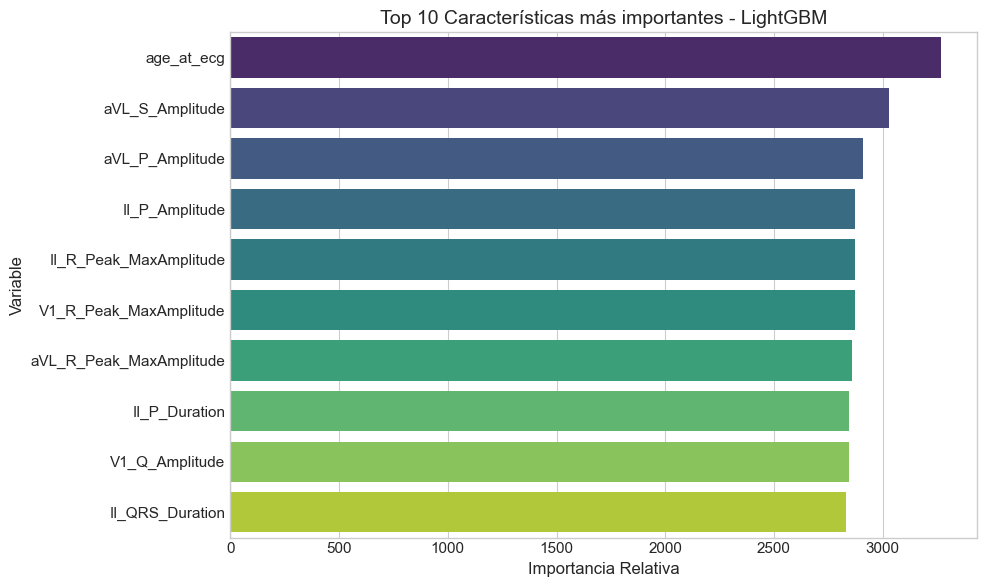

Top 5 variables para LightGBM: ['age_at_ecg', 'aVL_S_Amplitude', 'aVL_P_Amplitude', 'II_P_Amplitude', 'II_R_Peak_MaxAmplitude']


In [110]:
def plot_feature_importance(model, model_name, feature_names, top_n=10):

    if hasattr(model, 'feature_importances_'):
        # Sklearn (RandomForest), XGBoost, LightGBM
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        # CatBoost
        importances = model.get_feature_importance()
    else:
        print(f"El modelo {model_name} no tiene método de importancia nativa conocido.")
        return

    df_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # 3. Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_imp.head(top_n),
        x='importance',
        y='feature',
        palette='viridis'
    )
    plt.title(f'Top {top_n} Características más importantes - {model_name}')
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()

    # Retorn0 el top 5 para análisis textual rápido
    return df_imp.head(5)['feature'].tolist()


print("--- ANÁLISIS DE COHERENCIA (SANITY CHECK) ---")
for r in all_results_opt:
    top_features = plot_feature_importance(r['model'], r['name'], X_train.columns)
    print(f"Top 5 variables para {name}: {top_features}")

## Guardar la configuración completa del proceso
Se procede a almacenar la configuración del proceso para su posterior reproducibilidad.

In [111]:
EXPERIMENT_CONFIG = {
    'metadata': {
        'title': 'Soporte al diagnóstico de patologías cardíacas estructurales mediante ECG, XAI y UQ',
        'phase': 'Modelado (CRISP-DM)',
        'creation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'reference_frameworks': ['TRIPOD-AI', 'AI Act 2024/1689', 'CRISP-DM']
    },
    'data': {
        'n_features': len(FEATURE_NAMES),
        'n_classes': N_CLASSES,
        'sizes': {'train': len(X_train), 'val': len(X_val), 'cal': len(X_cal), 'test': len(X_test)}
    },
    'configuration': {
        'random_state': RANDOM_STATE,
        'n_splits_cv': N_SPLITS,
        'n_trials_optuna': N_TRIALS_OPTUNA,
        'class_weights': {str(k): float(v) for k, v in CLASS_WEIGHTS.items()}
    },
    'reference_value': {
        'description': 'Orientativos, NO validados clínicamente',
        'context': REFERENCE_VALUES['context'],
    }
}

with open(CONFIG_FILE, 'w') as f:
    json.dump(EXPERIMENT_CONFIG, f, indent=2, default=str)

# Bibliografía

<mark>Pendiente de formatear y numerar de forma correcta</mark>

**[1] Johnson JM, Khoshgoftaar TM. Survey on deep learning with class imbalance. J Big Data. 2019;6:27. https://doi.org/10.1186/s40537-019-0192-5**

**[2] https://certidevs.com/tutorial-scikit-learn-preprocesamiento-datos-desbalanceados**

**[3] Liu, L., Wu, X., Li, S. et al. Solving the class imbalance problem using ensemble algorithm: application of screening for aortic dissection. BMC Med Inform Decis Mak 22, 82 (2022). https://doi.org/10.1186/s12911-022-01821-w**

**[4] https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html**

**[5] Saito T, Rehmsmeier M. The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. *PLoS ONE*. 2015;10(3):e0118432. https://doi.org/10.1371/journal.pone.0118432**

**[6] Fawcett T. An introduction to ROC analysis. Pattern Recognit Lett. 2006;27(8):861-874. https://doi.org/10.1016/j.patrec.2005.10.010**

**[7] Guo C, Pleiss G, Sun Y, Weinberger KQ. On Calibration of Modern Neural Networks. Proceedings of the 34th International Conference on Machine Learning. 2017;70:1321-1330. Disponible en: http://proceedings.mlr.press/v70/guo17a.html**

**[8] Brier GW. Verification of forecasts expressed in terms of probability. Mon Weather Rev. 1950;78(1):1-3. https://doi.org/10.1175/1520-0493(1950)078<0001:VOFEIT>2.0.CO;2**

**[9] Brodersen KH, Ong CS, Stephan KE, Buhmann JM. The Balanced Accuracy and Its Posterior Distribution. 20th International Conference on Pattern Recognition. 2010:3121-3124. https://doi.org/10.1109/ICPR.2010.764**

**[10] Kohavi R. A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. *Proceedings of the 14th International Joint Conference on Artificial Intelligence*. 1995;2:1137-1143. Disponible en: https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf**

**[11] Akiba T, et al. Optuna: A Next-generation Hyperparameter Optimization Framework. KDD. 2019:2623-2631.**

**[12] Budholiya K, et al. An optimized XGBoost based diagnostic system for heart disease. J King Saud Univ. 2022;34:4514-4523.**

**[13] Chen L, et al. Prediction of cardiovascular disease based on PSO-XGBoost. Sci Rep. 2025;15:96520.**

**[14] Bentéjac C, et al. A comparative analysis of gradient boosting algorithms. Artif Intell Rev. 2021;54:1937-1967.**

**[15] Breiman L. Random Forests. Machine Learning. 2001;45(1):5-32.**

**[16] Breiman L, Friedman JH, Olshen RA, Stone CJ. Classification and Regression Trees. *Wadsworth International Group*. 1984. ISBN: 978-0412048418.**